# Statistical Arbitrage on L/T Valuation Mispricing with Dynamic Liquidation Rules

In [ ]:
import pandas as pd
import numpy as np
import yfinance as yf
import pyfolio as pf
from talib import ATR
from talib import TSF
import optuna
import matplotlib.pyplot as plt
from pyfolio import timeseries as pf

from numpy import *
from numpy.linalg import multi_dot

# Import cufflinks
import cufflinks as cf
cf.set_config_file(offline=True, dimensions=((1000,600))) # theme= 'henanigans'

# Import plotly express for EF plot
import plotly.express as px
# px.defaults.template = "plotly_dark"
px.defaults.width, px.defaults.height = 1000, 600

import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.precision', 3)

ticker = "^KLSE"

start1 = "2018-07-01"
end1 = "2022-12-31"

start2 = "2022-07-01"
end2 = "2023-12-31"

# Single Stock Before Optimizating Parameters

In [ ]:
# Define a function to calculate the Z-Score
def Z_Score(df, window):
    df['mean'] = df['PremDisc%'].rolling(window=window).mean()
    df['std'] = df['PremDisc%'].rolling(window=window).std()
    df['Z_Score'] = (df['PremDisc%'] - df['mean']) / df['std']
    return df

def ZScore(df, window):
    df['Mean'] = df['MisPricing%'].rolling(window=window).mean()
    df['Std'] = df['MisPricing%'].rolling(window=window).std()
    df['ZScore'] = (df['MisPricing%'] - df['Mean']) / df['Std']
    return df

df = yf.download(ticker, start=start1, end=end1)
df["Volume"] = 1 / (df["Adj Close"] / df["Close"]) * df["Volume"] 
df["Open"] = df["Adj Close"] / df["Close"] * df["Open"] 
df["High"] = df["Adj Close"] / df["Close"] * df["High"] 
df["Low"] = df["Adj Close"] / df["Close"] * df["Low"] 
df["Close"] = df["Adj Close"] / df["Close"] * df["Close"]

df = df[df['Volume'] != 0]
df = df.fillna(method='ffill')
#df = df.fillna(method='bfill')
df.dropna(inplace=True)

# Calculate the SMA
df["SMA"] = df["Close"].rolling(window=33).mean()

# Calculate the TSF
df["TSF"] = TSF(df["Close"].values, timeperiod=33)

# Calculate the premium/discount
df["PremDisc%"] = (df["Close"]/df["SMA"] - 1)*100

# Calculate Pct of MisPricing
df["MisPricing%"] = (df["TSF"]/df["Close"] - 1)*100

# Calculate Z-Score
df = Z_Score(df, window=13)

# Calculate ZScore
df = ZScore(df, window=13)

# Define buy and sell zones
buyZScoreTH = 1.65
sellZScoreTH = 1.65

buyZone = (df["Z_Score"] > -1*buyZScoreTH) & (df["ZScore"] > -1*buyZScoreTH)
prebuyZone = (df["Z_Score"].shift(1) <= -1*buyZScoreTH) & (df["ZScore"].shift(1) <= -1*buyZScoreTH)
sellZone1 = (df["Z_Score"] < 1*sellZScoreTH) & (df["ZScore"] < 1*sellZScoreTH)
presellZone1 = (df["Z_Score"].shift(1) >= 1*sellZScoreTH) & (df["ZScore"].shift(1) >= 1*sellZScoreTH)
sellZone2 = ((df["Z_Score"] < 0) & (df["Z_Score"].shift(1) > 0)) | ((df["ZScore"] < 0) & (df["ZScore"].shift(1) > 0))

# Generate trading signals
df["BuySignal"] = np.where(buyZone & prebuyZone, 1, 0)
df["SellSignal"] = np.where((sellZone1 & presellZone1) | sellZone2, -1, 0)
df["Signal"] = df["BuySignal"] + df["SellSignal"]

# Calculate the ATR
df["ATR"] = ATR(df["High"].values, df["Low"].values, df["Close"].values, timeperiod=13)

# Define SL and TP multipliers
SL_multiplier = 1
TP_multiplier = 3

# Initialize SL and TP levels to NaN
df["SL"] = np.nan
df["TP"] = np.nan

# Define initial capital
capital = 10000

# Calculate the number of shares to buy
df["Shares"] = capital // (df["ATR"] * 100)

# Create a variable to hold the entry price
entry_price = 0

# Define SL and TP levels based on entry price
for i in range(len(df)):
    if df["Signal"].iloc[i] == 1:
        entry_price = df["Close"].iloc[i]
        df["SL"].iloc[i] = entry_price - SL_multiplier * df["ATR"].iloc[i]
        df["TP"].iloc[i] = entry_price + TP_multiplier * df["ATR"].iloc[i]
    elif df["Signal"].iloc[i] == -1:
        entry_price = 0
        df["SL"].iloc[i] = np.nan
        df["TP"].iloc[i] = np.nan
    else:
        df["SL"].iloc[i] = df["SL"].iloc[i-1]
        df["TP"].iloc[i] = df["TP"].iloc[i-1]

# Fill in the rest of SL and TP columns
df["SL"].fillna(method='ffill', inplace=True)
df["TP"].fillna(method='ffill', inplace=True)

# Calculate daily returns based on trading signals
df['returns'] = df['Close'].pct_change() * df['Signal'].shift()

# Calculate Buy-and-Hold Returns
df["B&H_Returns"] = df["Close"].pct_change()

# Calculate cumulative returns
df['cumulative_returns'] = (1 + df['returns']).cumprod()

# Calculate buy-and-hold cumulative returns
df["B&H_Cumulative_Returns"] = (1 + df["B&H_Returns"]).cumprod()

# Print the DataFrame
print(df)

# Plot cumulative returns
plt.figure(figsize=(13,8))

# Plot the strategy's cumulative returns
plt.plot(df['cumulative_returns'], label='Strategy Returns')

# Plot the buy-and-hold cumulative returns
plt.plot(df["B&H_Cumulative_Returns"], label='Buy & Hold Returns')

plt.title('Cumulative Returns of the Strategy vs Buy & Hold')
plt.legend(loc='best')
plt.show()

# Single Stock Optimization 

In [ ]:
import optuna
from optuna.samplers import TPESampler

def objective(trial):
    # Define the hyperparameters
    sma_window = trial.suggest_int('sma_window', 33, 233)
    zscore_window = trial.suggest_int('zscore_window', 3, 33)
    buyZScoreTH = trial.suggest_float('buyZScoreTH', 1.0, 3.0)
    sellZScoreTH = trial.suggest_float('sellZScoreTH', 1.0, 3.0)
    SL_multiplier = trial.suggest_float('SL_multiplier', 0.5, 2.0)
    TP_multiplier = trial.suggest_float('TP_multiplier', 1.0, 5.0)
    ATR_window = trial.suggest_int('ATR_window', 3, 13)

    # Fetch the data
    df = yf.download('^KLSE', start=start1, end=end2)

    # Calculate the SMA
    df["SMA"] = df["Close"].rolling(window=sma_window).mean()
    
    # Calculate the TSF
    df["TSF"] = TSF(df["Close"].values, timeperiod=sma_window)

    # Calculate the premium/discount
    df["PremDisc%"] = (df["Close"]/df["SMA"] - 1)*100
    
    # Calculate Pct of MisPricing
    df["MisPricing%"] = (df["TSF"]/df["Close"] - 1)*100

    # Calculate Z-Score
    df = Z_Score(df, window=zscore_window)
    
    # Calculate ZScore
    df = ZScore(df, window=zscore_window)

    buyZone = (df["Z_Score"] > -1*buyZScoreTH) & (df["ZScore"] > -1*buyZScoreTH)
    prebuyZone = (df["Z_Score"].shift(1) <= -1*buyZScoreTH) & (df["ZScore"].shift(1) <= -1*buyZScoreTH)
    sellZone1 = (df["Z_Score"] < 1*sellZScoreTH) & (df["ZScore"] < 1*sellZScoreTH)
    presellZone1 = (df["Z_Score"].shift(1) >= 1*sellZScoreTH) & (df["ZScore"].shift(1) >= 1*sellZScoreTH)
    sellZone2 = ((df["Z_Score"] < 0) & (df["Z_Score"].shift(1) > 0)) | ((df["ZScore"] < 0) & (df["ZScore"].shift(1) > 0))

    df["BuySignal"] = np.where(buyZone & prebuyZone, 1, 0)
    df["SellSignal"] = np.where((sellZone1 & presellZone1) | sellZone2, -1, 0)
    df["Signal"] = df["BuySignal"] + df["SellSignal"]

    df["ATR"] = ATR(df["High"].values, df["Low"].values, df["Close"].values, timeperiod=ATR_window)

    df["SL"] = np.nan
    df["TP"] = np.nan

    capital = 10000
    df["Shares"] = capital // (df["ATR"] * 100)

    entry_price = 0

    for i in range(len(df)):
        if df["Signal"].iloc[i] == 1:
            entry_price = df["Close"].iloc[i]
            df["SL"].iloc[i] = entry_price - SL_multiplier * df["ATR"].iloc[i]
            df["TP"].iloc[i] = entry_price + TP_multiplier * df["ATR"].iloc[i]
        elif df["Signal"].iloc[i] == -1:
            entry_price = 0
            df["SL"].iloc[i] = np.nan
            df["TP"].iloc[i] = np.nan
        else:
            df["SL"].iloc[i] = df["SL"].iloc[i-1]
            df["TP"].iloc[i] = df["TP"].iloc[i-1]

    df["SL"].fillna(method='ffill', inplace=True)
    df["TP"].fillna(method='ffill', inplace=True)

    df['returns'] = df['Close'].pct_change() * df['Signal'].shift()

    df['cumulative_returns'] = (1 + df['returns']).cumprod()

    return df['returns'].mean()

# Define the study and run the optimization
sampler = TPESampler(seed=13)
study = optuna.create_study(direction='maximize', sampler=sampler)
study.optimize(objective, n_trials=108)

# Print the best parameters
best_params = study.best_params
print("Best parameters: ", best_params)

# Print the best value (i.e., the return)
best_value = study.best_value
print("Best value (return): ", best_value)

best_params = study.best_params

best_sma_window = best_params['sma_window']
best_zscore_window = best_params['zscore_window']
best_buyZScoreTH = best_params['buyZScoreTH']
best_sellZScoreTH = best_params['sellZScoreTH']
best_SL_multiplier = best_params['SL_multiplier']
best_TP_multiplier = best_params['TP_multiplier']
best_ATR_window = best_params['ATR_window']

print(f"Best SMA Window: {best_sma_window}")
print(f"Best Z-Score Window: {best_zscore_window}")
print(f"Best Buy Z-Score Threshold: {best_buyZScoreTH}")
print(f"Best Sell Z-Score Threshold: {best_sellZScoreTH}")
print(f"Best Stop Loss Multiplier: {best_SL_multiplier}")
print(f"Best Take Profit Multiplier: {best_TP_multiplier}")
print(f"Best ATR Window: {best_ATR_window}")

# Single Stock with Optimized Parameters - 1st Period 

In [ ]:
# Define a function to calculate the Z-Score
def Z_Score(df, window):
    df['mean'] = df['PremDisc%'].rolling(window=window).mean()
    df['std'] = df['PremDisc%'].rolling(window=window).std()
    df['Z_Score'] = (df['PremDisc%'] - df['mean']) / df['std']
    return df

def ZScore(df, window):
    df['Mean'] = df['MisPricing%'].rolling(window=window).mean()
    df['Std'] = df['MisPricing%'].rolling(window=window).std()
    df['ZScore'] = (df['MisPricing%'] - df['Mean']) / df['Std']
    return df

df = yf.download(ticker, start=start1, end=end1)

df["Volume"] = 1 / (df["Adj Close"] / df["Close"]) * df["Volume"] 
df["Open"] = df["Adj Close"] / df["Close"] * df["Open"] 
df["High"] = df["Adj Close"] / df["Close"] * df["High"] 
df["Low"] = df["Adj Close"] / df["Close"] * df["Low"] 
df["Close"] = df["Adj Close"] / df["Close"] * df["Close"]

df = df[df['Volume'] != 0]
df = df.fillna(method='ffill')
#df = df.fillna(method='bfill')
df.dropna(inplace=True)

# Calculate the SMA
df["SMA"] = df["Close"].rolling(window=best_sma_window).mean()

# Calculate the TSF
df["TSF"] = TSF(df["Close"].values, timeperiod=best_sma_window)

# Calculate the premium/discount
df["PremDisc%"] = (df["Close"]/df["SMA"] - 1)*100

# Calculate Pct of MisPricing
df["MisPricing%"] = (df["TSF"]/df["Close"] - 1)*100

# Calculate Z-Score
df = Z_Score(df, window=best_zscore_window)

# Calculate ZScore
df = ZScore(df, window=best_zscore_window)


# Define buy and sell zones
buyZScoreTH = best_buyZScoreTH
sellZScoreTH = best_sellZScoreTH

buyZone = (df["Z_Score"] > -1*buyZScoreTH) & (df["ZScore"] > -1*buyZScoreTH)
prebuyZone = (df["Z_Score"].shift(1) <= -1*buyZScoreTH) & (df["ZScore"].shift(1) <= -1*buyZScoreTH)
sellZone1 = (df["Z_Score"] < 1*sellZScoreTH) & (df["ZScore"] < 1*sellZScoreTH)
presellZone1 = (df["Z_Score"].shift(1) >= 1*sellZScoreTH) & (df["ZScore"].shift(1) >= 1*sellZScoreTH)
sellZone2 = ((df["Z_Score"] < 0) & (df["Z_Score"].shift(1) > 0)) | ((df["ZScore"] < 0) & (df["ZScore"].shift(1) > 0))


# Generate trading signals
df["BuySignal"] = np.where(buyZone & prebuyZone, 1, 0)
df["SellSignal"] = np.where((sellZone1 & presellZone1) | sellZone2, -1, 0)
df["Signal"] = df["BuySignal"] + df["SellSignal"]


# Calculate the ATR
df["ATR"] = ATR(df["High"].values, df["Low"].values, df["Close"].values, timeperiod=best_ATR_window)

# Define SL and TP multipliers
SL_multiplier = best_SL_multiplier
TP_multiplier = best_TP_multiplier

# Initialize SL and TP levels to NaN
df["SL"] = np.nan
df["TP"] = np.nan


# Define initial capital
capital = 10000

# Calculate the number of shares to buy
df["Shares"] = capital // (df["ATR"] * 100)

# Create a variable to hold the entry price
entry_price = 0

# Define SL and TP levels based on entry price
for i in range(len(df)):
    if df["Signal"].iloc[i] == 1:
        entry_price = df["Close"].iloc[i]
        df["SL"].iloc[i] = entry_price - SL_multiplier * df["ATR"].iloc[i]
        df["TP"].iloc[i] = entry_price + TP_multiplier * df["ATR"].iloc[i]
    elif df["Signal"].iloc[i] == -1:
        entry_price = 0
        df["SL"].iloc[i] = np.nan
        df["TP"].iloc[i] = np.nan
    else:
        df["SL"].iloc[i] = df["SL"].iloc[i-1]
        df["TP"].iloc[i] = df["TP"].iloc[i-1]

# Fill in the rest of SL and TP columns
df["SL"].fillna(method='ffill', inplace=True)
df["TP"].fillna(method='ffill', inplace=True)


# Calculate daily returns based on trading signals
df['returns'] = df['Close'].pct_change() * df['Signal'].shift()

# Calculate Buy-and-Hold Returns
df["B&H_Returns"] = df["Close"].pct_change()

# Calculate cumulative returns
df['cumulative_returns'] = (1 + df['returns']).cumprod()

# Calculate buy-and-hold cumulative returns
df["B&H_Cumulative_Returns"] = (1 + df["B&H_Returns"]).cumprod()

# Print the DataFrame
print(df)


# Plot cumulative returns
plt.figure(figsize=(13,8))

# Plot the strategy's cumulative returns
plt.plot(df['cumulative_returns'], label='Strategy Returns')

# Plot the buy-and-hold cumulative returns
plt.plot(df["B&H_Cumulative_Returns"], label='Buy & Hold Returns')

plt.title('Cumulative Returns of the Strategy vs Buy & Hold')
plt.legend(loc='best')
plt.show()

# Single Stock with Optimized Parameters - 2nd Period 

In [ ]:
# Define a function to calculate the Z-Score
def Z_Score(df, window):
    df['mean'] = df['PremDisc%'].rolling(window=window).mean()
    df['std'] = df['PremDisc%'].rolling(window=window).std()
    df['Z_Score'] = (df['PremDisc%'] - df['mean']) / df['std']
    return df

def ZScore(df, window):
    df['Mean'] = df['MisPricing%'].rolling(window=window).mean()
    df['Std'] = df['MisPricing%'].rolling(window=window).std()
    df['ZScore'] = (df['MisPricing%'] - df['Mean']) / df['Std']
    return df

df = yf.download(ticker, start=start2, end=end2)

df["Volume"] = 1 / (df["Adj Close"] / df["Close"]) * df["Volume"] 
df["Open"] = df["Adj Close"] / df["Close"] * df["Open"] 
df["High"] = df["Adj Close"] / df["Close"] * df["High"] 
df["Low"] = df["Adj Close"] / df["Close"] * df["Low"] 
df["Close"] = df["Adj Close"] / df["Close"] * df["Close"]

df = df[df['Volume'] != 0]
df = df.fillna(method='ffill')
#df = df.fillna(method='bfill')
df.dropna(inplace=True)

# Calculate the SMA
df["SMA"] = df["Close"].rolling(window=best_sma_window).mean()

# Calculate the TSF
df["TSF"] = TSF(df["Close"].values, timeperiod=best_sma_window)

# Calculate the premium/discount
df["PremDisc%"] = (df["Close"]/df["SMA"] - 1)*100

# Calculate Pct of MisPricing
df["MisPricing%"] = (df["TSF"]/df["Close"] - 1)*100

# Calculate Z-Score
df = Z_Score(df, window=best_zscore_window)

# Calculate ZScore
df = ZScore(df, window=best_zscore_window)


# Define buy and sell zones
buyZScoreTH = best_buyZScoreTH
sellZScoreTH = best_sellZScoreTH

buyZone = (df["Z_Score"] > -1*buyZScoreTH) & (df["ZScore"] > -1*buyZScoreTH)
prebuyZone = (df["Z_Score"].shift(1) <= -1*buyZScoreTH) & (df["ZScore"].shift(1) <= -1*buyZScoreTH)
sellZone1 = (df["Z_Score"] < 1*sellZScoreTH) & (df["ZScore"] < 1*sellZScoreTH)
presellZone1 = (df["Z_Score"].shift(1) >= 1*sellZScoreTH) & (df["ZScore"].shift(1) >= 1*sellZScoreTH)
sellZone2 = ((df["Z_Score"] < 0) & (df["Z_Score"].shift(1) > 0)) | ((df["ZScore"] < 0) & (df["ZScore"].shift(1) > 0))


# Generate trading signals
df["BuySignal"] = np.where(buyZone & prebuyZone, 1, 0)
df["SellSignal"] = np.where((sellZone1 & presellZone1) | sellZone2, -1, 0)
df["Signal"] = df["BuySignal"] + df["SellSignal"]


# Calculate the ATR
df["ATR"] = ATR(df["High"].values, df["Low"].values, df["Close"].values, timeperiod=best_ATR_window)

# Define SL and TP multipliers
SL_multiplier = best_SL_multiplier
TP_multiplier = best_TP_multiplier

# Initialize SL and TP levels to NaN
df["SL"] = np.nan
df["TP"] = np.nan


# Define initial capital
capital = 10000

# Calculate the number of shares to buy
df["Shares"] = capital // (df["ATR"] * 100)

# Create a variable to hold the entry price
entry_price = 0

# Define SL and TP levels based on entry price
for i in range(len(df)):
    if df["Signal"].iloc[i] == 1:
        entry_price = df["Close"].iloc[i]
        df["SL"].iloc[i] = entry_price - SL_multiplier * df["ATR"].iloc[i]
        df["TP"].iloc[i] = entry_price + TP_multiplier * df["ATR"].iloc[i]
    elif df["Signal"].iloc[i] == -1:
        entry_price = 0
        df["SL"].iloc[i] = np.nan
        df["TP"].iloc[i] = np.nan
    else:
        df["SL"].iloc[i] = df["SL"].iloc[i-1]
        df["TP"].iloc[i] = df["TP"].iloc[i-1]

# Fill in the rest of SL and TP columns
df["SL"].fillna(method='ffill', inplace=True)
df["TP"].fillna(method='ffill', inplace=True)


# Calculate daily returns based on trading signals
df['returns'] = df['Close'].pct_change() * df['Signal'].shift()

# Calculate Buy-and-Hold Returns
df["B&H_Returns"] = df["Close"].pct_change()

# Calculate cumulative returns
df['cumulative_returns'] = (1 + df['returns']).cumprod()

# Calculate buy-and-hold cumulative returns
df["B&H_Cumulative_Returns"] = (1 + df["B&H_Returns"]).cumprod()

# Print the DataFrame
print(df)


# Plot cumulative returns
plt.figure(figsize=(13,8))

# Plot the strategy's cumulative returns
plt.plot(df['cumulative_returns'], label='Strategy Returns')

# Plot the buy-and-hold cumulative returns
plt.plot(df["B&H_Cumulative_Returns"], label='Buy & Hold Returns')

plt.title('Cumulative Returns of the Strategy vs Buy & Hold')
plt.legend(loc='best')
plt.show()

# The advantages and potential pitfalls of this strategy:

# Further Enhancement for Multiple Stocks (but with the same Single Strategy)

# Optimizing for Respective Stock's Best Parameters

In [ ]:
def Z_Score(df, window):
    df['mean'] = df['PremDisc%'].rolling(window=window).mean()
    df['std'] = df['PremDisc%'].rolling(window=window).std()
    df['Z_Score'] = (df['PremDisc%'] - df['mean']) / df['std']
    return df


def ZScore(df, window):
    df['Mean'] = df['MisPricing%'].rolling(window=window).mean()
    df['Std'] = df['MisPricing%'].rolling(window=window).std()
    df['ZScore'] = (df['MisPricing%'] - df['Mean']) / df['Std']
    return df


def calculate_strategy_return(df, params):

    df["SMA"] = df["Close"].rolling(window=params['sma_window']).mean()
    df["PremDisc%"] = (df["Close"]/df["SMA"] - 1)*100
    df = Z_Score(df, window=params['zscore_window'])

    df["TSF"] = TSF(df["Close"].values, timeperiod=params['sma_window'])
    df["MisPricing%"] = (df["TSF"]/df["Close"] - 1)*100
    df = ZScore(df, window=params['zscore_window'])
    
    buyZone = (df["Z_Score"] > -1*params['buyZScoreTH']) & (df["ZScore"] > -1*params['buyZScoreTH'])
    prebuyZone = (df["Z_Score"].shift(1) <= -1*params['buyZScoreTH']) & (df["ZScore"].shift(1) <= -1*params['buyZScoreTH'])
    sellZone1 = (df["Z_Score"] < 1*params['sellZScoreTH']) & (df["ZScore"] < 1*params['sellZScoreTH'])
    presellZone1 = (df["Z_Score"].shift(1) >= 1*params['sellZScoreTH']) & (df["ZScore"].shift(1) >= 1*params['sellZScoreTH'])
    sellZone2 = ((df["Z_Score"] < 0) & (df["Z_Score"].shift(1) > 0)) | ((df["ZScore"] < 0) & (df["ZScore"].shift(1) > 0))

    df["BuySignal"] = np.where(buyZone & prebuyZone, 1, 0)
    df["SellSignal"] = np.where((sellZone1 & presellZone1) | sellZone2, -1, 0)
    df["Signal"] = df["BuySignal"] + df["SellSignal"]
    
    df["ATR"] = ATR(df["High"].values, df["Low"].values, df["Close"].values, timeperiod=params['ATR_window'])
    
    df["SL"] = np.where(df["Signal"]==1, df["Close"] - params['SL_multiplier'] * df["ATR"], np.nan)
    df["TP"] = np.where(df["Signal"]==1, df["Close"] + params['TP_multiplier'] * df["ATR"], np.nan)
    df["SL"].fillna(method='ffill', inplace=True)
    df["TP"].fillna(method='ffill', inplace=True)
    
    df['returns'] = df['Close'].pct_change() * df['Signal'].shift()
    
    return df['returns']


def objective(trial, df):
    
    params = {
        'sma_window': trial.suggest_int('sma_window', 33, 233),
        'zscore_window': trial.suggest_int('zscore_window', 3, 33),
        'buyZScoreTH': trial.suggest_float('buyZScoreTH', 1.0, 3.0),
        'sellZScoreTH': trial.suggest_float('sellZScoreTH', 1.0, 3.0),
        'SL_multiplier': trial.suggest_float('SL_multiplier', 0.5, 2.0),
        'TP_multiplier': trial.suggest_float('TP_multiplier', 1.0, 5.0),
        'ATR_window': trial.suggest_int('ATR_window', 3, 13)
    }
    returns = calculate_strategy_return(df.copy(), params)
    sharpe_ratio = pf.sharpe_ratio(returns.dropna())
    
    return sharpe_ratio

In [ ]:
tickers = [
    "4707.KL", "4715.KL", "7277.KL", "4065.KL", "5819.KL", "1023.KL", "2445.KL", "8869.KL", "1155.KL", "1295.KL",
    "1066.KL", "4197.KL", "5285.KL", "7084.KL","1082.KL", "5183.KL", "6033.KL", "1961.KL", "6947.KL", "5209.KL",
    "0166.KL", "6888.KL", "6012.KL", "5225.KL", "4863.KL", "3182.KL", "3816.KL", "5681.KL", "1015.KL", "5296.KL", 
    "5398.KL", "0117.KL", "7221.KL", "0069.KL", "7108.KL", "5259.KL", "5166.KL", "1023.KL", "8907.KL", "5286.KL", 
    "5099.KL", "5231.KL", "0045.KL", "6742.KL", "7250.KL", "7079.KL", "5878.KL", "5673.KL", "7168.KL", "6399.KL", 
    "7228.KL", "0120.KL", "1589.KL", "4383.KL", "1171.KL", "5288.KL", "7188.KL", "1066.KL", "6888.KL", 
    "5273.KL", "7293.KL", "0082.KL", "3662.KL", "5238.KL", "9385.KL", "5211.KL", "5182.KL", "3336.KL", "0032.KL", 
    "5254.KL", "7241.KL", "6633.KL", "5401.KL", "5302.KL", "5264.KL", "7173.KL", "5276.KL", "3816.KL", "7035.KL", 
    "3514.KL", "4022.KL", "5187.KL", "2062.KL", "2488.KL", "8273.KL", "7095.KL", "3247.KL", "0021.KL", "5062.KL",
    "0157.KL", "5112.KL", "0060.KL", "0091.KL", "1724.KL", "0185.KL", "4588.KL", "7237.KL", "5106.KL", "0091.KL",
    "5249.KL", "8052.KL", "5983.KL", "6483.KL", "7100.KL", "0131.KL", "7246.KL", "0174.KL", "3255.KL", "5168.KL",
    "7197.KL", "5162.KL", "7128.KL", "5843.KL", "5222.KL", "5053.KL", "7029.KL", "7090.KL", "0136.KL", "2089.KL",
    "5649.KL", "5239.KL", "7498.KL", "0153.KL", "4286.KL", "7014.KL", "3689.KL", "9377.KL", "7595.KL", "0190.KL",
    "7231.KL", "5269.KL", "5116.KL", "7103.KL", "7134.KL", "0173.KL", "7010.KL", "7412.KL", "6041.KL", "2828.KL",
    "3158.KL", "1163.KL", "5908.KL", "5015.KL", "5606.KL", "3905.KL", "6351.KL", "7073.KL", "9466.KL", "7017.KL",
    "6211.KL", "9687.KL", "7176.KL", "5008.KL", "9369.KL", "5035.KL", "2607.KL", "7765.KL", "8486.KL", "03048.KL",
    "5069.KL", "0138.KL", "0069.KL", "7108.KL", "5210.KL", "5259.KL", "0117.KL", "5166.KL", "7201.KL", "0034.KL",
    "1023.KL", "5398.KL", "8907.KL", "5099.KL", "3395.KL", "7113.KL", "7043.KL", "5219.KL", "5878.KL", "7079.KL",
    "0120.KL", "5673.KL", "5115.KL", "0232.KL", "7249.KL", "6399.KL",  "5983.KL", "7100.KL", "6483.KL", "5292.KL",
    "0045.KL", "5286.KL", "5231.KL", "7082.KL", "7250.KL", "0075.KL", "1066.KL", "0165.KL", "6742.KL", "4383.KL", 
    "5142.KL", "1171.KL", "4464.KL", "6888.KL", "5238.KL", "0180.KL", "0104.KL",
    "7293.KL", "7228.KL", "5273.KL", "3662.KL", "5031.KL", "7168.KL", "7241.KL", "0032.KL", "7188.KL",
    "5302.KL", "0095.KL", "5088.KL", "0082.KL", "8583.KL", "0189.KL", "0118.KL", "5211.KL", "5254.KL", "2488.KL",
    "5288.KL", "3816.KL", "0123.KL", "5182.KL", "0150.KL", "3336.KL", "9385.KL", "0066.KL", "0227.KL", "7173.KL",
    "0208.KL", "7035.KL", "3174.KL", "6633.KL", "5187.KL", "4588.KL", "5264.KL", "3247.KL",
    "0021.KL", "0223.KL", "5276.KL", "0172.KL", "5106.KL", "5401.KL", "3514.KL", "0157.KL", "5249.KL", "8052.KL",
    "7223.KL", "7246.KL", "8273.KL", "5112.KL", "0185.KL", "0060.KL", "8524.KL", "5062.KL", "0131.KL", "7237.KL"]

unique_tickers = list(set(tickers))

tickers = unique_tickers
start1 = "2018-07-01"
end1 = "2022-12-31"

returns_df = pd.DataFrame()
best_params_df = pd.DataFrame()
highest_sharpe_ratios = {}


for ticker in tickers:
    try:
        
        df = yf.download(ticker, start=start1, end=end1)
        df["Volume"] = 1 / (df["Adj Close"] / df["Close"]) * df["Volume"] 
        df["Open"] = df["Adj Close"] / df["Close"] * df["Open"] 
        df["High"] = df["Adj Close"] / df["Close"] * df["High"] 
        df["Low"] = df["Adj Close"] / df["Close"] * df["Low"] 
        df["Close"] = df["Adj Close"]

        df = df[df['Volume'] != 0]
        df.fillna(method='ffill', inplace=True)

        study = optuna.create_study(direction='maximize')
        study.optimize(lambda trial: objective(trial, df), n_trials=108)
        best_params = study.best_params
        print(f"Best params for {ticker}: {best_params}")
        returns = calculate_strategy_return(df, best_params)
        returns_df[ticker] = returns
        best_params_df = best_params_df.append(pd.Series(best_params, name=ticker))
        highest_sharpe_ratios[ticker] = study.best_value

    except Exception as e:
        print(ticker)
        
equity_curve = (1 + returns_df).cumprod()

highest_sharpe_ratios_df = pd.DataFrame.from_dict(highest_sharpe_ratios, orient='index', columns=['Highest Sharpe Ratio'])

# Combine best_params_df and highest_sharpe_ratios_df into a single dataframe
combined_df = pd.concat([best_params_df, highest_sharpe_ratios_df], axis=1)

# Write combined_df to a CSV file
combined_df.to_csv("best_params.csv")

output_df = pd.concat([returns_df, highest_sharpe_ratios_df, equity_curve], axis=1)

print(output_df)

In [ ]:
top_tickers_df = highest_sharpe_ratios_df.sort_values('Highest Sharpe Ratio', ascending=False).head(30)
bottom_tickers_df = highest_sharpe_ratios_df.sort_values('Highest Sharpe Ratio', ascending=False).tail(30)
print(top_tickers_df)
print(bottom_tickers_df)

tickers_df = pd.concat([top_tickers_df, bottom_tickers_df], axis=1)
# First, ensure that your list has unique tickers only
#unique_tickers = list(set(tickers))

# Calculate the number of tickers to trim
num_tickers = len(tickers_df)
num_to_trim = int(num_tickers * 0.25)

# Sort the tickers if needed, though in case of ticker symbols it might not make much sense
#unique_tickers.sort()

# Create a new list that excludes the top and bottom 25%
tickers_df = tickers_df[num_to_trim:-num_to_trim]
print(tickers_df)

# Run Back- and Forward Test to Selected Stocks

In [ ]:
# Run the Back-Test

tickers = tickers_df.index#top_tickers_df.index

start1 = "2018-07-01"
end1 = "2022-12-31"


# Load the best parameters
best_params = pd.read_csv('best_params.csv', index_col=0)  # Assuming ticker symbols are in the first column


for ticker in tickers:
    try:
        # Define a function to calculate the Z-Score
        def Z_Score(df, window):
            df['mean'] = df['PremDisc%'].rolling(window=window).mean()
            df['std'] = df['PremDisc%'].rolling(window=window).std()
            df['Z_Score'] = (df['PremDisc%'] - df['mean']) / df['std']
            return df
        
        def ZScore(df, window):
            df['Mean'] = df['MisPricing%'].rolling(window=window).mean()
            df['Std'] = df['MisPricing%'].rolling(window=window).std()
            df['ZScore'] = (df['MisPricing%'] - df['Mean']) / df['Std']
            return df

        # Fetch the data
        df = yf.download(ticker, start=start1, end=end1)

        df["Volume"] = 1 / (df["Adj Close"] / df["Close"]) * df["Volume"] 
        df["Open"] = df["Adj Close"] / df["Close"] * df["Open"] 
        df["High"] = df["Adj Close"] / df["Close"] * df["High"] 
        df["Low"] = df["Adj Close"] / df["Close"] * df["Low"] 
        df["Close"] = df["Adj Close"]
        df = df[df['Volume'] != 0]
        df.fillna(method='ffill', inplace=True)
        print(df)

        # Get the best parameters for this ticker
        params = best_params.loc[ticker]

        # Calculate the SMA
        df["SMA"] = df["Close"].rolling(window=int(params['sma_window'])).mean()

        # Calculate the premium/discount
        df["PremDisc%"] = (df["Close"]/df["SMA"] - 1)*100

        # Calculate Z-Score
        df = Z_Score(df, window=int(params['zscore_window']))

        df["TSF"] = TSF(df["Close"].values, timeperiod=int(params['sma_window']))
        df["MisPricing%"] = (df["TSF"]/df["Close"] - 1)*100
        df = ZScore(df, window=int(params['zscore_window']))

        
        # Define buy and sell zones
        buyZScoreTH = params['buyZScoreTH']
        sellZScoreTH = params['sellZScoreTH']

        buyZone = (df["Z_Score"] > -1*buyZScoreTH) & (df["ZScore"] > -1*buyZScoreTH)
        prebuyZone = (df["Z_Score"].shift(1) <= -1*buyZScoreTH) & (df["ZScore"].shift(1) <= -1*buyZScoreTH)
        sellZone1 = (df["Z_Score"] < 1*sellZScoreTH) & (df["ZScore"] < 1*sellZScoreTH)
        presellZone1 = (df["Z_Score"].shift(1) >= 1*sellZScoreTH) & (df["ZScore"].shift(1) >= 1*sellZScoreTH)
        sellZone2 = ((df["Z_Score"] < 0) & (df["Z_Score"].shift(1) > 0)) | ((df["ZScore"] < 0) & (df["ZScore"].shift(1) > 0))


        # Generate trading signals
        df["BuySignal"] = np.where(buyZone & prebuyZone, 1, 0)
        df["SellSignal"] = np.where((sellZone1 & presellZone1) | sellZone2, -1, 0)
        df["Signal"] = df["BuySignal"] + df["SellSignal"]

        # Calculate the ATR
        df["ATR"] = ATR(df["High"].values, df["Low"].values, df["Close"].values, timeperiod=int(params['ATR_window']))

        # Define SL and TP multipliers
        SL_multiplier = params['SL_multiplier']
        TP_multiplier = params['TP_multiplier']

        # Initialize SL and TP levels to NaN
        df["SL"] = np.nan
        df["TP"] = np.nan

        # Define initial capital
        capital = 10000

        # Calculate the number of shares to buy
        df["Shares"] = capital // (df["ATR"] * 100)

        # Create a variable to hold the entry price
        entry_price = 0

        # Define SL and TP levels based on entry price
        for i in range(len(df)):
            if df["Signal"].iloc[i] == 1:
                entry_price = df["Close"].iloc[i]
                df["SL"].iloc[i] = entry_price - SL_multiplier * df["ATR"].iloc[i]
                df["TP"].iloc[i] = entry_price + TP_multiplier * df["ATR"].iloc[i]
            elif df["Signal"].iloc[i] == -1:
                entry_price = 0
                df["SL"].iloc[i] = np.nan
                df["TP"].iloc[i] = np.nan
            else:
                df["SL"].iloc[i] = df["SL"].iloc[i-1]
                df["TP"].iloc[i] = df["TP"].iloc[i-1]

        # Fill in the rest of SL and TP columns
        df["SL"].fillna(method='ffill', inplace=True)
        df["TP"].fillna(method='ffill', inplace=True)

        # Calculate daily returns based on trading signals
        df['returns'] = df['Close'].pct_change() * df['Signal'].shift()

        # Calculate Buy-and-Hold Returns
        df["B&H_Returns"] = df["Close"].pct_change()

        # Calculate cumulative returns
        df['cumulative_returns'] = (1 + df['returns']).cumprod()

        # Calculate buy-and-hold cumulative returns
        df["B&H_Cumulative_Returns"] = (1 + df["B&H_Returns"]).cumprod()

        # Print the DataFrame
        print(df)

        # Plot cumulative returns
        plt.figure(figsize=(13,8))

        # Plot the strategy's cumulative returns
        plt.plot(df['cumulative_returns'], label='Strategy Returns')

        # Plot the buy-and-hold cumulative returns
        plt.plot(df["B&H_Cumulative_Returns"], label='Buy & Hold Returns')

        plt.title('Cumulative Returns of the Strategy vs Buy & Hold')
        plt.legend(loc='best')
        plt.show()
        
    except Exception as e:
        print(ticker)

In [ ]:
# Run the Forward-Test

tickers = tickers_df.index#top_tickers_df.index

start2 = "2022-07-01"
end2 = "2023-12-31"


# Load the best parameters
best_params = pd.read_csv('best_params.csv', index_col=0)  # Assuming ticker symbols are in the first column


for ticker in tickers:
    try:
        # Define a function to calculate the Z-Score
        def Z_Score(df, window):
            df['mean'] = df['PremDisc%'].rolling(window=window).mean()
            df['std'] = df['PremDisc%'].rolling(window=window).std()
            df['Z_Score'] = (df['PremDisc%'] - df['mean']) / df['std']
            return df
        
        def ZScore(df, window):
            df['Mean'] = df['MisPricing%'].rolling(window=window).mean()
            df['Std'] = df['MisPricing%'].rolling(window=window).std()
            df['ZScore'] = (df['MisPricing%'] - df['Mean']) / df['Std']
            return df

        # Fetch the data
        df = yf.download(ticker, start=start2, end=end2)

        df["Volume"] = 1 / (df["Adj Close"] / df["Close"]) * df["Volume"] 
        df["Open"] = df["Adj Close"] / df["Close"] * df["Open"] 
        df["High"] = df["Adj Close"] / df["Close"] * df["High"] 
        df["Low"] = df["Adj Close"] / df["Close"] * df["Low"] 
        df["Close"] = df["Adj Close"]
        df = df[df['Volume'] != 0]
        df.fillna(method='ffill', inplace=True)
        print(df)

        # Get the best parameters for this ticker
        params = best_params.loc[ticker]

        # Calculate the SMA
        df["SMA"] = df["Close"].rolling(window=int(params['sma_window'])).mean()

        # Calculate the premium/discount
        df["PremDisc%"] = (df["Close"]/df["SMA"] - 1)*100

        # Calculate Z-Score
        df = Z_Score(df, window=int(params['zscore_window']))

        df["TSF"] = TSF(df["Close"].values, timeperiod=int(params['sma_window']))
        df["MisPricing%"] = (df["TSF"]/df["Close"] - 1)*100
        df = ZScore(df, window=int(params['zscore_window']))

        
        # Define buy and sell zones
        buyZScoreTH = params['buyZScoreTH']
        sellZScoreTH = params['sellZScoreTH']

        buyZone = (df["Z_Score"] > -1*buyZScoreTH) & (df["ZScore"] > -1*buyZScoreTH)
        prebuyZone = (df["Z_Score"].shift(1) <= -1*buyZScoreTH) & (df["ZScore"].shift(1) <= -1*buyZScoreTH)
        sellZone1 = (df["Z_Score"] < 1*sellZScoreTH) & (df["ZScore"] < 1*sellZScoreTH)
        presellZone1 = (df["Z_Score"].shift(1) >= 1*sellZScoreTH) & (df["ZScore"].shift(1) >= 1*sellZScoreTH)
        sellZone2 = ((df["Z_Score"] < 0) & (df["Z_Score"].shift(1) > 0)) | ((df["ZScore"] < 0) & (df["ZScore"].shift(1) > 0))


        # Generate trading signals
        df["BuySignal"] = np.where(buyZone & prebuyZone, 1, 0)
        df["SellSignal"] = np.where((sellZone1 & presellZone1) | sellZone2, -1, 0)
        df["Signal"] = df["BuySignal"] + df["SellSignal"]

        # Calculate the ATR
        df["ATR"] = ATR(df["High"].values, df["Low"].values, df["Close"].values, timeperiod=int(params['ATR_window']))

        # Define SL and TP multipliers
        SL_multiplier = params['SL_multiplier']
        TP_multiplier = params['TP_multiplier']

        # Initialize SL and TP levels to NaN
        df["SL"] = np.nan
        df["TP"] = np.nan

        # Define initial capital
        capital = 10000

        # Calculate the number of shares to buy
        df["Shares"] = capital // (df["ATR"] * 100)

        # Create a variable to hold the entry price
        entry_price = 0

        # Define SL and TP levels based on entry price
        for i in range(len(df)):
            if df["Signal"].iloc[i] == 1:
                entry_price = df["Close"].iloc[i]
                df["SL"].iloc[i] = entry_price - SL_multiplier * df["ATR"].iloc[i]
                df["TP"].iloc[i] = entry_price + TP_multiplier * df["ATR"].iloc[i]
            elif df["Signal"].iloc[i] == -1:
                entry_price = 0
                df["SL"].iloc[i] = np.nan
                df["TP"].iloc[i] = np.nan
            else:
                df["SL"].iloc[i] = df["SL"].iloc[i-1]
                df["TP"].iloc[i] = df["TP"].iloc[i-1]

        # Fill in the rest of SL and TP columns
        df["SL"].fillna(method='ffill', inplace=True)
        df["TP"].fillna(method='ffill', inplace=True)

        # Calculate daily returns based on trading signals
        df['returns'] = df['Close'].pct_change() * df['Signal'].shift()

        # Calculate Buy-and-Hold Returns
        df["B&H_Returns"] = df["Close"].pct_change()

        # Calculate cumulative returns
        df['cumulative_returns'] = (1 + df['returns']).cumprod()

        # Calculate buy-and-hold cumulative returns
        df["B&H_Cumulative_Returns"] = (1 + df["B&H_Returns"]).cumprod()

        # Print the DataFrame
        print(df)

        # Plot cumulative returns
        plt.figure(figsize=(13,8))

        # Plot the strategy's cumulative returns
        plt.plot(df['cumulative_returns'], label='Strategy Returns')

        # Plot the buy-and-hold cumulative returns
        plt.plot(df["B&H_Cumulative_Returns"], label='Buy & Hold Returns')

        plt.title('Cumulative Returns of the Strategy vs Buy & Hold')
        plt.legend(loc='best')
        plt.show()
        
    except Exception as e:
        print(ticker)

# Incorporating MPT into The Strategy!

# Getting The Historical Stratyegy Return and Hypothetical Equity Curve for Each and Every Stocks

In [ ]:
# Create an empty dataframe to store equity curves
equity_curve_df = pd.DataFrame()

# Loop through the tickers
for ticker in tickers:
    
    try:
        
        # Define a function to calculate the Z-Score
        def Z_Score(df, window):
            df['mean'] = df['PremDisc%'].rolling(window=window).mean()
            df['std'] = df['PremDisc%'].rolling(window=window).std()
            df['Z_Score'] = (df['PremDisc%'] - df['mean']) / df['std']
            return df
        
        def ZScore(df, window):
            df['Mean'] = df['MisPricing%'].rolling(window=window).mean()
            df['Std'] = df['MisPricing%'].rolling(window=window).std()
            df['ZScore'] = (df['MisPricing%'] - df['Mean']) / df['Std']
            return df

        # Fetch the data
        df = yf.download(ticker, start=start1, end=end2)

        df["Volume"] = 1 / (df["Adj Close"] / df["Close"]) * df["Volume"] 
        df["Open"] = df["Adj Close"] / df["Close"] * df["Open"] 
        df["High"] = df["Adj Close"] / df["Close"] * df["High"] 
        df["Low"] = df["Adj Close"] / df["Close"] * df["Low"] 
        df["Close"] = df["Adj Close"]
        df = df[df['Volume'] != 0]
        df.fillna(method='ffill', inplace=True)
        print(df)

        # Get the best parameters for this ticker
        params = best_params.loc[ticker]

        # Calculate the SMA
        df["SMA"] = df["Close"].rolling(window=int(params['sma_window'])).mean()

        # Calculate the premium/discount
        df["PremDisc%"] = (df["Close"]/df["SMA"] - 1)*100

        # Calculate Z-Score
        df = Z_Score(df, window=int(params['zscore_window']))
        
        # Adding in New Trading Rules
        df["TSF"] = TSF(df["Close"].values, timeperiod=int(params['sma_window']))
        df["MisPricing%"] = (df["TSF"]/df["Close"] - 1)*100
        df = ZScore(df, window=int(params['zscore_window']))


        # Define buy and sell zones
        buyZScoreTH = params['buyZScoreTH']
        sellZScoreTH = params['sellZScoreTH']
        
        buyZone = (df["Z_Score"] > -1*buyZScoreTH) & (df["ZScore"] > -1*buyZScoreTH)
        prebuyZone = (df["Z_Score"].shift(1) <= -1*buyZScoreTH) & (df["ZScore"].shift(1) <= -1*buyZScoreTH)
        sellZone1 = (df["Z_Score"] < 1*sellZScoreTH) & (df["ZScore"] < 1*sellZScoreTH)
        presellZone1 = (df["Z_Score"].shift(1) >= 1*sellZScoreTH) & (df["ZScore"].shift(1) >= 1*sellZScoreTH)
        sellZone2 = ((df["Z_Score"] < 0) & (df["Z_Score"].shift(1) > 0)) | ((df["ZScore"] < 0) & (df["ZScore"].shift(1) > 0))

        # Generate trading signals
        df["BuySignal"] = np.where(buyZone & prebuyZone, 1, 0)
        df["SellSignal"] = np.where((sellZone1 & presellZone1) | sellZone2, -1, 0)
        df["Signal"] = df["BuySignal"] + df["SellSignal"]

        # Calculate the ATR
        df["ATR"] = ATR(df["High"].values, df["Low"].values, df["Close"].values, timeperiod=int(params['ATR_window']))

        # Define SL and TP multipliers
        SL_multiplier = params['SL_multiplier']
        TP_multiplier = params['TP_multiplier']

        # Initialize SL and TP levels to NaN
        df["SL"] = np.nan
        df["TP"] = np.nan

        # Define initial capital
        capital = 10000

        # Calculate the number of shares to buy
        df["Shares"] = capital // (df["ATR"] * 100)

        # Create a variable to hold the entry price
        entry_price = 0

        # Define SL and TP levels based on entry price
        for i in range(len(df)):
            if df["Signal"].iloc[i] == 1:
                entry_price = df["Close"].iloc[i]
                df["SL"].iloc[i] = entry_price - SL_multiplier * df["ATR"].iloc[i]
                df["TP"].iloc[i] = entry_price + TP_multiplier * df["ATR"].iloc[i]
            elif df["Signal"].iloc[i] == -1:
                entry_price = 0
                df["SL"].iloc[i] = np.nan
                df["TP"].iloc[i] = np.nan
            else:
                df["SL"].iloc[i] = df["SL"].iloc[i-1]
                df["TP"].iloc[i] = df["TP"].iloc[i-1]

        # Fill in the rest of SL and TP columns
        df["SL"].fillna(method='ffill', inplace=True)
        df["TP"].fillna(method='ffill', inplace=True)

        # Calculate daily returns based on trading signals
        df['returns'] = df['Close'].pct_change() * df['Signal'].shift()

        # Calculate Buy-and-Hold Returns
        df["B&H_Returns"] = df["Close"].pct_change()

        # Calculate cumulative returns
        df['cumulative_returns'] = (1 + df['returns']).cumprod()

        # Calculate buy-and-hold cumulative returns
        df["B&H_Cumulative_Returns"] = (1 + df["B&H_Returns"]).cumprod()

        # Print the DataFrame
        print(df)

        # Calculate cumulative returns
        df['cumulative_returns'] = (1 + df['returns']).cumprod()

        # Add the cumulative returns to the equity curve dataframe
        equity_curve_df[ticker] = df['cumulative_returns']

        # Plot cumulative returns
        plt.figure(figsize=(13,8))

        # Plot the strategy's cumulative returns
        plt.plot(df['cumulative_returns'], label='Strategy Returns')

        # Plot the buy-and-hold cumulative returns
        plt.plot(df["B&H_Cumulative_Returns"], label='Buy & Hold Returns')

        plt.title('Cumulative Returns of the Strategy vs Buy & Hold')
        plt.legend(loc='best')
        plt.show()
     
    except Exception as e:
        print(f"Error processing {ticker}: {e}")

# Print the equity curve dataframe
print(equity_curve_df)

# Single Strategy, Single Period MPT Performance Evaluation

In [ ]:
# Specify assets / stocks
assets = equity_curve_df.columns
print(assets)

# Number of assets
numofasset = len(assets)

# Number of portfolio for optimization
numofportfolio = 5000

df = equity_curve_df
df.fillna(method='ffill', inplace=True)
#df.dropna(inplace=True)
print(df)

# Plot Strategy Return / Equity Curve History
df['2019':].iplot(kind='line', title='Equity Curve or Compounded Returns Plot')

In [ ]:
# Dataframe of returns and volatility
returns = df.pct_change().dropna()
df1 = pd.DataFrame({
    'Ann Strategy Ret': round(returns.mean()*252*100,2),
    'Ann Strategy Vol': round(returns.std()*np.sqrt(252)*100,2)
})
df1

# Plot annualized return and volatility
df1.iplot(
    kind='bar', 
    title='Annualized Return & Volatility (%)', 
    shared_xaxes = True,  
    orientation="h") #subplots=True

df1.reset_index().iplot(
    kind="pie", 
    title='Annualized Strategy Return (%)', 
    labels='index', 
    values="Ann Strategy Ret",
    textinfo='percent+label', 
    hole=.4)

In [ ]:
def portfolio_simulation(returns):

    # Initialize the lists
    rets = []; vols = []; wts = []

    # Simulate 5,000 portfolios
    for i in range (numofportfolio):
        
        # Generate random weights
        weights = random.random(numofasset)[:, newaxis]
        
        # Set weights such that sum of weights equals 1
        weights /= sum(weights)
        
        # Portfolio statistics
        rets.append(weights.T @ array(returns.mean() * 252)[:, newaxis])        
        vols.append(sqrt(multi_dot([weights.T, returns.cov()*252, weights])))
        wts.append(weights.flatten())

    # Create a dataframe for analysis
    portdf = 100*pd.DataFrame({
        'port_rets': array(rets).flatten(),
        'port_vols': array(vols).flatten(),
        'weights': list(array(wts))
        })
    
    portdf['sharpe_ratio'] = portdf['port_rets'] / portdf['port_vols']

    return round(portdf,2)

# Create a dataframe for analysis
temp = portfolio_simulation(returns)
temp.head()

# Get the max sharpe portfolio stats
print(temp.iloc[temp.sharpe_ratio.idxmax()])

# Verify the above result
temp.describe().T

# Max sharpe ratio portfolio weights
msrpwts = temp['weights'][temp['sharpe_ratio'].idxmax()]

# Allocation to achieve max sharpe ratio portfolio
dict(zip(assets, around(msrpwts,2)))

In [ ]:
# Plot simulated portfolio
fig = px.scatter(
    temp, x='port_vols', y='port_rets', color='sharpe_ratio', 
    labels={'port_vols': 'Expected Volatility', 'port_rets': 'Expected Return','sharpe_ratio': 'Sharpe Ratio'},
    title="Monte Carlo Simulated Portfolio"
     ).update_traces(mode='markers', marker=dict(symbol='cross'))

# Plot max sharpe 
fig.add_scatter(
    mode='markers', 
    x=[temp.iloc[temp.sharpe_ratio.idxmax()]['port_vols']], 
    y=[temp.iloc[temp.sharpe_ratio.idxmax()]['port_rets']], 
    marker=dict(color='RoyalBlue', size=20, symbol='star'),
    name = 'Max Sharpe'
).update(layout_showlegend=False)

# Show spikes
fig.update_xaxes(showspikes=True)
fig.update_yaxes(showspikes=True)
fig.show()

# Single Strategy, Rolling Window MPT Performance Evaluation (with Monte Carlo Simulation)

In [ ]:
# MPT using  Monte Carlo simulation to generate a large number of random portfolios
# (5,000 in this case) and then selects the portfolio with the highest Sharpe Ratio. 
# This is a simpler and more brute-force approach, and it may not always find the global 
# optimum, especially if the number of portfolios simulated is not large enough.
# This method can be more intuitive and easier to understand, and it can sometimes find better 
# solutions, especially for complex or non-convex optimization problems. However, it can also 
# be slower and less accurate, especially for larger numbers of assets or smaller numbers of 
# simulations.

# Specify assets / stocks
assets = equity_curve_df.columns

# Number of assets
num_of_assets = len(assets)

# Number of portfolio for optimization
num_of_portfolios = 5000

# Source of Data or Equity Curve of ALL Tickers
df = equity_curve_df

# Define the rolling window size
rolling_window = 252  # You can adjust this based on your preference (e.g., 1 year)

# Initialize a DataFrame to store the rolling portfolio weights
rolling_weights_df = pd.DataFrame(index=equity_curve_df.index, columns=assets)

# Perform rolling optimization of the portfolio
for i in range(rolling_window, len(equity_curve_df)):
    window_returns = equity_curve_df.iloc[i - rolling_window:i]  # Get the returns for the rolling window

    # Define the function for portfolio simulation with random weights
    def portfolio_simulation(returns):
        weights = np.random.random(num_of_assets)
        weights /= np.sum(weights)
        port_returns = np.sum(weights * returns.mean() * 252)
        port_volatility = np.sqrt(np.dot(weights.T, np.dot(returns.cov() * 252, weights)))
        sharpe_ratio = port_returns / port_volatility
        return weights, sharpe_ratio

    # Perform Monte Carlo simulation to find the maximum Sharpe ratio portfolio for the rolling window
    max_sharpe_ratio = -np.inf
    best_weights = None
    for j in range(num_of_portfolios):
        weights, sharpe_ratio = portfolio_simulation(window_returns)
        if sharpe_ratio > max_sharpe_ratio:
            max_sharpe_ratio = sharpe_ratio
            best_weights = weights

    # Store the weights of the maximum Sharpe ratio portfolio for the rolling window
    rolling_weights_df.iloc[i] = best_weights

# Forward fill any NaN values in the rolling weights DataFrame
rolling_weights_df.fillna(method='ffill', inplace=True)

# Calculate the portfolio returns based on the rolling weights
rolling_portfolio_returns = (rolling_weights_df.shift() * equity_curve.pct_change()).sum(axis=1)

# Calculate the cumulative returns of the rolling portfolio
cumulative_returns = (1 + rolling_portfolio_returns).cumprod()

# Print the DataFrame with the rolling portfolio returns and cumulative returns
rolling_portfolio_df = pd.DataFrame({
    'Rolling_Portfolio_Returns': rolling_portfolio_returns,
    'Cumulative_Returns': cumulative_returns
})
print(rolling_portfolio_df)

import matplotlib.pyplot as plt

# Plot the cumulative returns of the portfolio
plt.figure(figsize=(13, 8))
plt.plot(rolling_portfolio_df['Cumulative_Returns'])
plt.title('Cumulative Returns of the Portfolio Over Time')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.grid(False)
plt.show()

# Plot the portfolio weights over time
rolling_weights_df.plot(kind='area', stacked=True, figsize=(13, 8))
plt.title('Portfolio Weights Over Time')
plt.xlabel('Date')
plt.ylabel('Weights')
plt.grid(False)
plt.show()

# Print the final portfolio weights
print('Final portfolio weights:')
print(rolling_weights_df.iloc[-1])

# Single Strategy Rolling Window MPT Performance Evaluation (with SLSQP Method)

In [ ]:
# MPT using a built-in optimization function from the scipy library, specifically the minimize 
# function with the 'SLSQP' method. This is a numerical optimization method for constrained 
# linear and non-linear optimization problems. The objective function being minimized is the 
# negative Sharpe Ratio(since we want to maximize the Sharpe Ratio), and the constraints ensure
# that the portfolio weights sum to 1. Generally more efficient and accurate, especially for 
# larger numbers of assets. 

from scipy.optimize import minimize

# Specify assets / stocks
assets = equity_curve_df.columns

# Number of assets
num_of_assets = len(assets)

# Define the rolling window size
rolling_window = 252  # You can adjust this based on your preference (e.g., 1 year)

# Initialize a DataFrame to store the rolling portfolio weights
rolling_weights_df = pd.DataFrame(index=equity_curve_df.index, columns=assets)

# Define the objective function for optimization (minimize negative Sharpe Ratio)
def objective(weights, returns):
    portfolio_return = np.sum(returns.mean() * weights) * 252
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(returns.cov() * 252, weights)))
    return -portfolio_return / portfolio_volatility

# Define the constraints for optimization
constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})

# Define the bounds for optimization
bounds = tuple((0, 1) for asset in range(num_of_assets))

# Perform rolling optimization of the portfolio
for i in range(rolling_window, len(equity_curve_df)):
    window_returns = equity_curve_df.iloc[i - rolling_window:i]  # Get the returns for the rolling window

    # Perform optimization to find the maximum Sharpe ratio portfolio for the rolling window
    result = minimize(objective, num_of_assets*[1./num_of_assets,], args=window_returns, method='SLSQP', bounds=bounds, constraints=constraints)

    # Store the weights of the maximum Sharpe ratio portfolio for the rolling window
    rolling_weights_df.iloc[i] = result.x

# Forward fill any NaN values in the rolling weights DataFrame
rolling_weights_df.fillna(method='ffill', inplace=True)

# Calculate the portfolio returns based on the rolling weights
rolling_portfolio_returns = (rolling_weights_df.shift() * equity_curve_df.pct_change()).sum(axis=1)

# Calculate the cumulative returns of the rolling portfolio
cumulative_returns = (1 + rolling_portfolio_returns).cumprod()

# Print the DataFrame with the rolling portfolio returns and cumulative returns
rolling_portfolio_df = pd.DataFrame({
    'Rolling_Portfolio_Returns': rolling_portfolio_returns,
    'Cumulative_Returns': cumulative_returns
})
print(rolling_portfolio_df)

import matplotlib.pyplot as plt

# Plot the cumulative returns of the portfolio
plt.figure(figsize=(13, 8))
plt.plot(rolling_portfolio_df['Cumulative_Returns'])
plt.title('Cumulative Returns of the Portfolio Over Time')
plt.show()

# Plot the portfolio weights over time
rolling_weights_df.plot(kind='area', stacked=True, figsize=(13, 8))
plt.title('Portfolio Weights Over Time')
plt.show()

# Print the final portfolio weights
print('Final portfolio weights:')
print(rolling_weights_df.iloc[-1])

# Double-Strategy, Single Period MPT Performance Evaluation 

In [ ]:
# Create an empty dataframe to store equity curves
equity_curve_df = pd.DataFrame()

# Create an empty dataframe to store buy and hold equity curves
bh_equity_curve_df = pd.DataFrame()

# Loop through the tickers
for ticker in tickers:
    try:
        
        # Define a function to calculate the Z-Score
        def Z_Score(df, window):
            df['mean'] = df['PremDisc%'].rolling(window=window).mean()
            df['std'] = df['PremDisc%'].rolling(window=window).std()
            df['Z_Score'] = (df['PremDisc%'] - df['mean']) / df['std']
            return df
        
        def ZScore(df, window):
            df['Mean'] = df['MisPricing%'].rolling(window=window).mean()
            df['Std'] = df['MisPricing%'].rolling(window=window).std()
            df['ZScore'] = (df['MisPricing%'] - df['Mean']) / df['Std']
            return df


        # Fetch the data
        df = yf.download(ticker, start=start1, end=end2)

        df["Volume"] = 1 / (df["Adj Close"] / df["Close"]) * df["Volume"] 
        df["Open"] = df["Adj Close"] / df["Close"] * df["Open"] 
        df["High"] = df["Adj Close"] / df["Close"] * df["High"] 
        df["Low"] = df["Adj Close"] / df["Close"] * df["Low"] 
        df["Close"] = df["Adj Close"]
        df = df[df['Volume'] != 0]
        df.fillna(method='ffill', inplace=True)
        print(df)

        # Get the best parameters for this ticker
        params = best_params.loc[ticker]

        # Calculate the SMA
        df["SMA"] = df["Close"].rolling(window=int(params['sma_window'])).mean()

        # Calculate the premium/discount
        df["PremDisc%"] = (df["Close"]/df["SMA"] - 1)*100

        # Calculate Z-Score
        df = Z_Score(df, window=int(params['zscore_window']))
        
        df["TSF"] = TSF(df["Close"].values, timeperiod=int(params['sma_window']))
        df["MisPricing%"] = (df["TSF"]/df["Close"] - 1)*100
        df = ZScore(df, window=int(params['zscore_window']))


        # Define buy and sell zones
        buyZScoreTH = params['buyZScoreTH']
        sellZScoreTH = params['sellZScoreTH']

        buyZone = (df["Z_Score"] > -1*buyZScoreTH) & (df["ZScore"] > -1*buyZScoreTH)
        prebuyZone = (df["Z_Score"].shift(1) <= -1*buyZScoreTH) & (df["ZScore"].shift(1) <= -1*buyZScoreTH)
        sellZone1 = (df["Z_Score"] < 1*sellZScoreTH) & (df["ZScore"] < 1*sellZScoreTH)
        presellZone1 = (df["Z_Score"].shift(1) >= 1*sellZScoreTH) & (df["ZScore"].shift(1) >= 1*sellZScoreTH)
        sellZone2 = ((df["Z_Score"] < 0) & (df["Z_Score"].shift(1) > 0)) | ((df["ZScore"] < 0) & (df["ZScore"].shift(1) > 0))

        # Generate trading signals
        df["BuySignal"] = np.where(buyZone & prebuyZone, 1, 0)
        df["SellSignal"] = np.where((sellZone1 & presellZone1) | sellZone2, -1, 0)
        df["Signal"] = df["BuySignal"] + df["SellSignal"]

        # Calculate the ATR
        df["ATR"] = ATR(df["High"].values, df["Low"].values, df["Close"].values, timeperiod=int(params['ATR_window']))

        # Define SL and TP multipliers
        SL_multiplier = params['SL_multiplier']
        TP_multiplier = params['TP_multiplier']

        # Initialize SL and TP levels to NaN
        df["SL"] = np.nan
        df["TP"] = np.nan

        # Define initial capital
        capital = 10000

        # Calculate the number of shares to buy
        df["Shares"] = capital // (df["ATR"] * 100)

        # Create a variable to hold the entry price
        entry_price = 0

        # Define SL and TP levels based on entry price
        for i in range(len(df)):
            if df["Signal"].iloc[i] == 1:
                entry_price = df["Close"].iloc[i]
                df["SL"].iloc[i] = entry_price - SL_multiplier * df["ATR"].iloc[i]
                df["TP"].iloc[i] = entry_price + TP_multiplier * df["ATR"].iloc[i]
            elif df["Signal"].iloc[i] == -1:
                entry_price = 0
                df["SL"].iloc[i] = np.nan
                df["TP"].iloc[i] = np.nan
            else:
                df["SL"].iloc[i] = df["SL"].iloc[i-1]
                df["TP"].iloc[i] = df["TP"].iloc[i-1]

        # Fill in the rest of SL and TP columns
        df["SL"].fillna(method='ffill', inplace=True)
        df["TP"].fillna(method='ffill', inplace=True)

        # Calculate daily returns based on trading signals
        df['returns'] = df['Close'].pct_change() * df['Signal'].shift()

        # Calculate Buy-and-Hold Returns
        df["B&H_Returns"] = df["Close"].pct_change()

        # Calculate cumulative returns
        df['cumulative_returns'] = (1 + df['returns']).cumprod()

        # Calculate buy-and-hold cumulative returns
        df["B&H_Cumulative_Returns"] = (1 + df["B&H_Returns"]).cumprod()

        # Print the DataFrame
        print(df)

        # Calculate cumulative returns
        df['cumulative_returns'] = (1 + df['returns']).cumprod()
        
        # Calculate buy-and-hold cumulative returns
        df["B&H_Cumulative_Returns"] = (1 + df["B&H_Returns"]).cumprod()

        # Add the cumulative returns to the equity curve dataframe
        equity_curve_df[ticker+'_Strategy'] = df['cumulative_returns']

        # Add the buy-and-hold cumulative returns to the buy and hold equity curve dataframe
        bh_equity_curve_df[ticker+'_B&H'] = df["B&H_Cumulative_Returns"]

        # Plot cumulative returns
        plt.figure(figsize=(13,8))

        # Plot the strategy's cumulative returns
        plt.plot(df['cumulative_returns'], label='Strategy Returns')

        # Plot the buy-and-hold cumulative returns
        plt.plot(df["B&H_Cumulative_Returns"], label='Buy & Hold Returns')

        plt.title('Cumulative Returns of the Strategy vs Buy & Hold')
        plt.legend(loc='best')
        plt.show()
     
    except Exception as e:
        print(f"Error processing {ticker}: {e}")

# Print the equity curve dataframe
print(equity_curve_df)

# Print the buy and hold equity curve dataframe
print(bh_equity_curve_df)

# Concat and Print Both the DataFrames
final_df = pd.concat([equity_curve_df, bh_equity_curve_df], axis=1)
print(final_df)

In [ ]:
# Specify assets / stocks
assets = final_df.columns
print(assets)

# Number of assets
numofasset = len(assets)

# Number of portfolio for optimization
numofportfolio = 5000

In [ ]:
df = final_df
print(df)

# Plot Strategy Return / Equity Curve History
df['2019':].iplot(kind='line', title='Equity Curve or Compounded Returns Plot')

In [ ]:
# Dataframe of returns and volatility
returns = df.pct_change().dropna()
df1 = pd.DataFrame({
    'Ann Strategy Ret': round(returns.mean()*252*100,2),
    'Ann Strategy Vol': round(returns.std()*np.sqrt(252)*100,2)
})
df1

In [ ]:
# Plot annualized return and volatility
df1.iplot(
    kind='bar', 
    title='Annualized Return & Volatility (%)', 
    shared_xaxes = True,  
    orientation="h") #subplots=True

In [ ]:
df1.reset_index().iplot(
    kind="pie", 
    title='Annualized Strategy Return (%)', 
    labels='index', 
    values="Ann Strategy Ret",
    textinfo='percent+label', 
    hole=.4)

In [ ]:
def portfolio_simulation(returns):

    # Initialize the lists
    rets = []; vols = []; wts = []

    # Simulate 5,000 portfolios
    for i in range (numofportfolio):
        
        # Generate random weights
        weights = random.random(numofasset)[:, newaxis]
        
        # Set weights such that sum of weights equals 1
        weights /= sum(weights)
        
        # Portfolio statistics
        rets.append(weights.T @ array(returns.mean() * 252)[:, newaxis])        
        vols.append(sqrt(multi_dot([weights.T, returns.cov()*252, weights])))
        wts.append(weights.flatten())

    # Create a dataframe for analysis
    portdf = 100*pd.DataFrame({
        'port_rets': array(rets).flatten(),
        'port_vols': array(vols).flatten(),
        'weights': list(array(wts))
        })
    
    portdf['sharpe_ratio'] = portdf['port_rets'] / portdf['port_vols']

    return round(portdf,2)

In [ ]:
# Create a dataframe for analysis
temp = portfolio_simulation(returns)
temp.head()

In [ ]:
# Get the max sharpe portfolio stats
print(temp.iloc[temp.sharpe_ratio.idxmax()])

In [ ]:
# Verify the above result
temp.describe().T

In [ ]:
# Max sharpe ratio portfolio weights
msrpwts = temp['weights'][temp['sharpe_ratio'].idxmax()]

# Allocation to achieve max sharpe ratio portfolio
dict(zip(assets, around(msrpwts,2)))

In [ ]:
# Plot simulated portfolio
fig = px.scatter(
    temp, x='port_vols', y='port_rets', color='sharpe_ratio', 
    labels={'port_vols': 'Expected Volatility', 'port_rets': 'Expected Return','sharpe_ratio': 'Sharpe Ratio'},
    title="Monte Carlo Simulated Portfolio"
     ).update_traces(mode='markers', marker=dict(symbol='cross'))

# Plot max sharpe 
fig.add_scatter(
    mode='markers', 
    x=[temp.iloc[temp.sharpe_ratio.idxmax()]['port_vols']], 
    y=[temp.iloc[temp.sharpe_ratio.idxmax()]['port_rets']], 
    marker=dict(color='RoyalBlue', size=20, symbol='star'),
    name = 'Max Sharpe'
).update(layout_showlegend=False)

# Show spikes
fig.update_xaxes(showspikes=True)
fig.update_yaxes(showspikes=True)
fig.show()

# Double-Strategy, Rolling Window MPT Performance Evaluation (with Monte Carlo Simulation)

In [ ]:
# MPT using  Monte Carlo simulation to generate a large number of random portfolios
# (5,000 in this case) and then selects the portfolio with the highest Sharpe Ratio. 
# This is a simpler and more brute-force approach, and it may not always find the global 
# optimum, especially if the number of portfolios simulated is not large enough.
# This method can be more intuitive and easier to understand, and it can sometimes find better 
# solutions, especially for complex or non-convex optimization problems. However, it can also 
# be slower and less accurate, especially for larger numbers of assets or smaller numbers of 
# simulations.

# Specify assets / stocks
assets = final_df.columns

# Number of assets
num_of_assets = len(assets)

# Number of portfolio for optimization
num_of_portfolios = 5000

# Source of Data or Equity Curve of ALL Tickers
df = final_df

# Define the rolling window size
rolling_window = 252  # You can adjust this based on your preference (e.g., 1 year)

# Initialize a DataFrame to store the rolling portfolio weights
rolling_weights_df = pd.DataFrame(index=final_df.index, columns=assets)

# Perform rolling optimization of the portfolio
for i in range(rolling_window, len(final_df)):
    window_returns = final_df.iloc[i - rolling_window:i]  # Get the returns for the rolling window

    # Define the function for portfolio simulation with random weights
    def portfolio_simulation(returns):
        weights = np.random.random(num_of_assets)
        weights /= np.sum(weights)
        port_returns = np.sum(weights * returns.mean() * 252)
        port_volatility = np.sqrt(np.dot(weights.T, np.dot(returns.cov() * 252, weights)))
        sharpe_ratio = port_returns / port_volatility
        return weights, sharpe_ratio

    # Perform Monte Carlo simulation to find the maximum Sharpe ratio portfolio for the rolling window
    max_sharpe_ratio = -np.inf
    best_weights = None
    for j in range(num_of_portfolios):
        weights, sharpe_ratio = portfolio_simulation(window_returns)
        if sharpe_ratio > max_sharpe_ratio:
            max_sharpe_ratio = sharpe_ratio
            best_weights = weights

    # Store the weights of the maximum Sharpe ratio portfolio for the rolling window
    rolling_weights_df.iloc[i] = best_weights

# Forward fill any NaN values in the rolling weights DataFrame
rolling_weights_df.fillna(method='ffill', inplace=True)

# Calculate the portfolio returns based on the rolling weights
rolling_portfolio_returns = (rolling_weights_df.shift() * final_df.pct_change()).sum(axis=1)

# Calculate the cumulative returns of the rolling portfolio
cumulative_returns = (1 + rolling_portfolio_returns).cumprod()

# Print the DataFrame with the rolling portfolio returns and cumulative returns
rolling_portfolio_df = pd.DataFrame({
    'Rolling_Portfolio_Returns': rolling_portfolio_returns,
    'Cumulative_Returns': cumulative_returns
})
print(rolling_portfolio_df)

In [ ]:
import matplotlib.pyplot as plt

# Plot the cumulative returns of the portfolio
plt.figure(figsize=(13, 8))
plt.plot(rolling_portfolio_df['Cumulative_Returns'])
plt.title('Cumulative Returns of the Portfolio Over Time')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.grid(False)
plt.show()

# Plot the portfolio weights over time
rolling_weights_df.plot(kind='area', stacked=True, figsize=(13, 8))
plt.title('Portfolio Weights Over Time')
plt.xlabel('Date')
plt.ylabel('Weights')
plt.grid(False)
plt.show()

# Print the final portfolio weights
print('Final portfolio weights:')
print(rolling_weights_df.iloc[-1])

# Double-Strategy, Rolling Window MPT Performance Evaluation (with SLSQP Method)

In [ ]:
# MPT using a built-in optimization function from the scipy library, specifically the minimize 
# function with the 'SLSQP' method. This is a numerical optimization method for constrained 
# linear and non-linear optimization problems. The objective function being minimized is the 
# negative Sharpe Ratio(since we want to maximize the Sharpe Ratio), and the constraints ensure
# that the portfolio weights sum to 1. Generally more efficient and accurate, especially for 
# larger numbers of assets. 

from scipy.optimize import minimize

# Specify assets / stocks
assets = final_df.columns

# Number of assets
num_of_assets = len(assets)

# Define the rolling window size
rolling_window = 252  # You can adjust this based on your preference (e.g., 1 year)

# Initialize a DataFrame to store the rolling portfolio weights
rolling_weights_df = pd.DataFrame(index=final_df.index, columns=assets)

# Define the objective function for optimization (minimize negative Sharpe Ratio)
def objective(weights, returns):
    portfolio_return = np.sum(returns.mean() * weights) * 252
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(returns.cov() * 252, weights)))
    return -portfolio_return / portfolio_volatility

# Define the constraints for optimization
constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})

# Define the bounds for optimization
bounds = tuple((0, 1) for asset in range(num_of_assets))

# Perform rolling optimization of the portfolio
for i in range(rolling_window, len(final_df)):
    window_returns = final_df.iloc[i - rolling_window:i]  # Get the returns for the rolling window

    # Perform optimization to find the maximum Sharpe ratio portfolio for the rolling window
    result = minimize(objective, num_of_assets*[1./num_of_assets,], args=window_returns, method='SLSQP', bounds=bounds, constraints=constraints)
    
    weights = result.x
    weights /= np.sum(weights)  # Normalize the weights so they sum up to 1

    # Store the weights of the maximum Sharpe ratio portfolio for the rolling window
    rolling_weights_df.iloc[i] = weights

# Forward fill any NaN values in the rolling weights DataFrame
rolling_weights_df.fillna(method='ffill', inplace=True)

# Calculate the portfolio returns based on the rolling weights
rolling_portfolio_returns = (rolling_weights_df.shift() * equity_curve_df.pct_change()).sum(axis=1)

# Calculate the cumulative returns of the rolling portfolio
cumulative_returns = (1 + rolling_portfolio_returns).cumprod()

# Print the DataFrame with the rolling portfolio returns and cumulative returns
rolling_portfolio_df = pd.DataFrame({
    'Rolling_Portfolio_Returns': rolling_portfolio_returns,
    'Cumulative_Returns': cumulative_returns
})
print(rolling_portfolio_df)


In [ ]:
import matplotlib.pyplot as plt

# Plot the cumulative returns of the portfolio
plt.figure(figsize=(13, 8))
plt.plot(rolling_portfolio_df['Cumulative_Returns'])
plt.title('Cumulative Returns of the Portfolio Over Time')
plt.show()

# Plot the portfolio weights over time
rolling_weights_df.plot(kind='area', stacked=True, figsize=(13, 8))
plt.title('Portfolio Weights Over Time')
plt.show()

# Print the final portfolio weights
print('Final portfolio weights:')
print(rolling_weights_df.iloc[-1])

# Executive Summary

# Double-Strategy (Min Optimisation) with Rolling MPT

In [9]:
import pandas as pd
import numpy as np
import yfinance as yf
import pyfolio as pf
from talib import ATR
from talib import TSF
import optuna
import matplotlib.pyplot as plt
from pyfolio import timeseries as pf

from numpy import *
from numpy.linalg import multi_dot

# Import cufflinks
import cufflinks as cf
cf.set_config_file(offline=True, dimensions=((1000,600))) # theme= 'henanigans'

# Import plotly express for EF plot
import plotly.express as px
# px.defaults.template = "plotly_dark"
px.defaults.width, px.defaults.height = 1000, 600

import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.precision', 2)

# Define Time Frames

# BackTest Period
start1 = "2018-07-01"
end1 = "2022-12-31"

# Forward Test Period
start2 = "2022-07-01"
end2 = "2023-12-31"

In [2]:
def Z_Score(df, window):
    df['mean'] = df['PremDisc%'].rolling(window=window).mean()
    df['std'] = df['PremDisc%'].rolling(window=window).std()
    df['Z_Score'] = (df['PremDisc%'] - df['mean']) / df['std']
    return df


def ZScore(df, window):
    df['Mean'] = df['MisPricing%'].rolling(window=window).mean()
    df['Std'] = df['MisPricing%'].rolling(window=window).std()
    df['ZScore'] = (df['MisPricing%'] - df['Mean']) / df['Std']
    return df


def calculate_strategy_return(df, params):

    df["SMA"] = df["Close"].rolling(window=params['sma_window']).mean()
    df["PremDisc%"] = (df["Close"]/df["SMA"] - 1)*100
    df = Z_Score(df, window=params['zscore_window'])

    df["TSF"] = TSF(df["Close"].values, timeperiod=params['sma_window'])
    df["MisPricing%"] = (df["TSF"]/df["Close"] - 1)*100
    df = ZScore(df, window=params['zscore_window'])
    
    buyZone = (df["Z_Score"] > -1*params['buyZScoreTH']) & (df["ZScore"] > -1*params['buyZScoreTH'])
    prebuyZone = (df["Z_Score"].shift(1) <= -1*params['buyZScoreTH']) & (df["ZScore"].shift(1) <= -1*params['buyZScoreTH'])
    sellZone1 = (df["Z_Score"] < 1*params['sellZScoreTH']) & (df["ZScore"] < 1*params['sellZScoreTH'])
    presellZone1 = (df["Z_Score"].shift(1) >= 1*params['sellZScoreTH']) & (df["ZScore"].shift(1) >= 1*params['sellZScoreTH'])
    sellZone2 = ((df["Z_Score"] < 0) & (df["Z_Score"].shift(1) > 0)) | ((df["ZScore"] < 0) & (df["ZScore"].shift(1) > 0))

    df["BuySignal"] = np.where(buyZone & prebuyZone, 1, 0)
    df["SellSignal"] = np.where((sellZone1 & presellZone1) | sellZone2, -1, 0)
    df["Signal"] = df["BuySignal"] + df["SellSignal"]
    
    df["ATR"] = ATR(df["High"].values, df["Low"].values, df["Close"].values, timeperiod=params['ATR_window'])
    
    df["SL"] = np.where(df["Signal"]==1, df["Close"] - params['SL_multiplier'] * df["ATR"], np.nan)
    df["TP"] = np.where(df["Signal"]==1, df["Close"] + params['TP_multiplier'] * df["ATR"], np.nan)
    df["SL"].fillna(method='ffill', inplace=True)
    df["TP"].fillna(method='ffill', inplace=True)
    
    df['returns'] = df['Close'].pct_change() * df['Signal'].shift()
    
    return df['returns']


def objective(trial, df):
    
    params = {
        'sma_window': trial.suggest_int('sma_window', 233, 233),
        'zscore_window': trial.suggest_int('zscore_window', 13, 13),
        'buyZScoreTH': trial.suggest_float('buyZScoreTH', 2.1, 2.1),
        'sellZScoreTH': trial.suggest_float('sellZScoreTH', 2.1, 2.1),
        'SL_multiplier': trial.suggest_float('SL_multiplier', 1.5, 1.5),
        'TP_multiplier': trial.suggest_float('TP_multiplier', 3.0, 3.0),
        'ATR_window': trial.suggest_int('ATR_window', 13, 13)
    }
    returns = calculate_strategy_return(df.copy(), params)
    sharpe_ratio = pf.sharpe_ratio(returns.dropna())
    
    return sharpe_ratio

In [3]:
tickers = [
    "4707.KL", "4715.KL", "7277.KL", "4065.KL", "5819.KL", "1023.KL", "2445.KL", "8869.KL", "1155.KL", "1295.KL",
    "1066.KL", "4197.KL", "5285.KL", "7084.KL","1082.KL", "5183.KL", "6033.KL", "1961.KL", "6947.KL", "5209.KL",
    "0166.KL", "6888.KL", "6012.KL", "5225.KL", "4863.KL", "3182.KL", "3816.KL", "5681.KL", "1015.KL", "5296.KL", 
    "5398.KL", "0117.KL", "7221.KL", "0069.KL", "7108.KL", "5259.KL", "5166.KL", "1023.KL", "8907.KL", "5286.KL", 
    "5099.KL", "5231.KL", "0045.KL", "6742.KL", "7250.KL", "7079.KL", "5878.KL", "5673.KL", "7168.KL", "6399.KL", 
    "7228.KL", "0120.KL", "1589.KL", "4383.KL", "1171.KL", "5288.KL", "7188.KL", "1066.KL", "6888.KL", 
    "5273.KL", "7293.KL", "0082.KL", "3662.KL", "5238.KL", "9385.KL", "5211.KL", "5182.KL", "3336.KL", "0032.KL", 
    "5254.KL", "7241.KL", "6633.KL", "5401.KL", "5302.KL", "5264.KL", "7173.KL", "5276.KL", "3816.KL", "7035.KL", 
    "3514.KL", "4022.KL", "5187.KL", "2062.KL", "2488.KL", "8273.KL", "7095.KL", "3247.KL", "0021.KL", "5062.KL",
    "0157.KL", "5112.KL", "0060.KL", "0091.KL", "1724.KL", "0185.KL", "4588.KL", "7237.KL", "5106.KL", "0091.KL",
    "5249.KL", "8052.KL", "5983.KL", "6483.KL", "7100.KL", "0131.KL", "7246.KL", "0174.KL", "3255.KL", "5168.KL",
    "7197.KL", "5162.KL", "7128.KL", "5843.KL", "5222.KL", "5053.KL", "7029.KL", "7090.KL", "0136.KL", "2089.KL",
    "5649.KL", "5239.KL", "7498.KL", "0153.KL", "4286.KL", "7014.KL", "3689.KL", "9377.KL", "7595.KL", "0190.KL",
    "7231.KL", "5269.KL", "5116.KL", "7103.KL", "7134.KL", "0173.KL", "7010.KL", "7412.KL", "6041.KL", "2828.KL",
    "3158.KL", "1163.KL", "5908.KL", "5015.KL", "5606.KL", "3905.KL", "6351.KL", "7073.KL", "9466.KL", "7017.KL",
    "6211.KL", "9687.KL", "7176.KL", "5008.KL", "9369.KL", "5035.KL", "2607.KL", "7765.KL", "8486.KL", "03048.KL",
    "5069.KL", "0138.KL", "0069.KL", "7108.KL", "5210.KL", "5259.KL", "0117.KL", "5166.KL", "7201.KL", "0034.KL",
    "1023.KL", "5398.KL", "8907.KL", "5099.KL", "3395.KL", "7113.KL", "7043.KL", "5219.KL", "5878.KL", "7079.KL",
    "0120.KL", "5673.KL", "5115.KL", "0232.KL", "7249.KL", "6399.KL",  "5983.KL", "7100.KL", "6483.KL", "5292.KL",
    "0045.KL", "5286.KL", "5231.KL", "7082.KL", "7250.KL", "0075.KL", "1066.KL", "0165.KL", "6742.KL", "4383.KL", 
    "5142.KL", "1171.KL", "4464.KL", "6888.KL", "5238.KL", "0180.KL", "0104.KL",
    "7293.KL", "7228.KL", "5273.KL", "3662.KL", "5031.KL", "7168.KL", "7241.KL", "0032.KL", "7188.KL",
    "5302.KL", "0095.KL", "5088.KL", "0082.KL", "8583.KL", "0189.KL", "0118.KL", "5211.KL", "5254.KL", "2488.KL",
    "5288.KL", "3816.KL", "0123.KL", "5182.KL", "0150.KL", "3336.KL", "9385.KL", "0066.KL", "0227.KL", "7173.KL",
    "0208.KL", "7035.KL", "3174.KL", "6633.KL", "5187.KL", "4588.KL", "5264.KL", "3247.KL",
    "0021.KL", "0223.KL", "5276.KL", "0172.KL", "5106.KL", "5401.KL", "3514.KL", "0157.KL", "5249.KL", "8052.KL",
    "7223.KL", "7246.KL", "8273.KL", "5112.KL", "0185.KL", "0060.KL", "8524.KL", "5062.KL", "0131.KL", "7237.KL"]

unique_tickers = list(set(tickers))

tickers = unique_tickers

returns_df = pd.DataFrame()
best_params_df = pd.DataFrame()
highest_sharpe_ratios = {}


for ticker in tickers:
    try:
        
        df = yf.download(ticker, start=start1, end=end1)
        df["Volume"] = 1 / (df["Adj Close"] / df["Close"]) * df["Volume"] 
        df["Open"] = df["Adj Close"] / df["Close"] * df["Open"] 
        df["High"] = df["Adj Close"] / df["Close"] * df["High"] 
        df["Low"] = df["Adj Close"] / df["Close"] * df["Low"] 
        df["Close"] = df["Adj Close"]

        df = df[df['Volume'] != 0]
        df.fillna(method='ffill', inplace=True)

        study = optuna.create_study(direction='maximize')
        study.optimize(lambda trial: objective(trial, df), n_trials=1)
        best_params = study.best_params
        print(f"Best params for {ticker}: {best_params}")
        returns = calculate_strategy_return(df, best_params)
        returns_df[ticker] = returns
        best_params_df = best_params_df.append(pd.Series(best_params, name=ticker))
        highest_sharpe_ratios[ticker] = study.best_value

    except Exception as e:
        print(ticker)
        
equity_curve = (1 + returns_df).cumprod()

highest_sharpe_ratios_df = pd.DataFrame.from_dict(highest_sharpe_ratios, orient='index', columns=['Highest Sharpe Ratio'])

# Combine best_params_df and highest_sharpe_ratios_df into a single dataframe
combined_df = pd.concat([best_params_df, highest_sharpe_ratios_df], axis=1)

# Write combined_df to a CSV file
combined_df.to_csv("min_best_params.csv")

output_df = pd.concat([returns_df, highest_sharpe_ratios_df, equity_curve], axis=1)

print(output_df)

[*********************100%***********************]  1 of 1 completed

[I 2023-08-01 10:14:55,142] A new study created in memory with name: no-name-ddf9e88d-ea9e-4db3-8107-6b014226f600
[I 2023-08-01 10:14:55,149] Trial 0 finished with value: -0.5874816754699868 and parameters: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}. Best is trial 0 with value: -0.5874816754699868.



Best params for 5273.KL: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}
[*********************100%***********************]  1 of 1 completed

[I 2023-08-01 10:14:55,345] A new study created in memory with name: no-name-0f42eb6d-8d96-4cfd-aca7-bb208c8c7165
[I 2023-08-01 10:14:55,360] Trial 0 finished with value: -0.7579609307073674 and parameters: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}. Best is trial 0 with value: -0.7579609307073674.



Best params for 4383.KL: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}
[*********************100%***********************]  1 of 1 completed

[I 2023-08-01 10:14:55,556] A new study created in memory with name: no-name-e68e2aee-b544-4e31-953d-78ab5ae6d35a
[I 2023-08-01 10:14:55,571] Trial 0 finished with value: -0.38591852343154814 and parameters: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}. Best is trial 0 with value: -0.38591852343154814.



Best params for 0034.KL: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}
[*********************100%***********************]  1 of 1 completed

[I 2023-08-01 10:14:55,775] A new study created in memory with name: no-name-47c2b08c-aab9-4fb0-b3c7-888872c5942a
[I 2023-08-01 10:14:55,789] Trial 0 finished with value: -0.0694255324428774 and parameters: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}. Best is trial 0 with value: -0.0694255324428774.



Best params for 7173.KL: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}
[*********************100%***********************]  1 of 1 completed

[I 2023-08-01 10:14:55,973] A new study created in memory with name: no-name-8ae9564d-98a4-4daf-acaa-4703228db32e
[I 2023-08-01 10:14:55,986] Trial 0 finished with value: -0.2585412734885125 and parameters: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}. Best is trial 0 with value: -0.2585412734885125.



Best params for 7073.KL: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}
[*********************100%***********************]  1 of 1 completed

[I 2023-08-01 10:14:56,189] A new study created in memory with name: no-name-19703819-52a5-4928-8c52-727f23fea0b4
[I 2023-08-01 10:14:56,206] Trial 0 finished with value: 0.5691312447722625 and parameters: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}. Best is trial 0 with value: 0.5691312447722625.



Best params for 8273.KL: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}
[*********************100%***********************]  1 of 1 completed

[I 2023-08-01 10:14:56,363] A new study created in memory with name: no-name-023c8b7e-bd20-4221-812a-ffa7680d62fb
[I 2023-08-01 10:14:56,371] Trial 0 finished with value: -0.13808328617970855 and parameters: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}. Best is trial 0 with value: -0.13808328617970855.



Best params for 7765.KL: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}
[*********************100%***********************]  1 of 1 completed

[I 2023-08-01 10:14:56,570] A new study created in memory with name: no-name-35684eb4-fc1b-4300-b680-d5466ae11383
[I 2023-08-01 10:14:56,588] Trial 0 finished with value: -0.278886747327978 and parameters: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}. Best is trial 0 with value: -0.278886747327978.



Best params for 3247.KL: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}
[*********************100%***********************]  1 of 1 completed

[I 2023-08-01 10:14:56,857] A new study created in memory with name: no-name-13404da4-6035-4de6-813c-07d8022b28c6
[I 2023-08-01 10:14:56,872] Trial 0 finished with value: -0.21749597291584064 and parameters: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}. Best is trial 0 with value: -0.21749597291584064.



Best params for 7134.KL: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}
[*********************100%***********************]  1 of 1 completed

[I 2023-08-01 10:14:57,037] A new study created in memory with name: no-name-6b788af1-6f28-46c2-bdf2-be54a1a4a351
[I 2023-08-01 10:14:57,057] Trial 0 finished with value: 0.07332236165857003 and parameters: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}. Best is trial 0 with value: 0.07332236165857003.



Best params for 5062.KL: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}
[*********************100%***********************]  1 of 1 completed

[I 2023-08-01 10:14:57,236] A new study created in memory with name: no-name-b1849e5e-76e5-483e-ac88-ecbfbe97c62f
[I 2023-08-01 10:14:57,255] Trial 0 finished with value: 0.3003516572804367 and parameters: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}. Best is trial 0 with value: 0.3003516572804367.



Best params for 1066.KL: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}
[*********************100%***********************]  1 of 1 completed

[I 2023-08-01 10:14:57,419] A new study created in memory with name: no-name-54c39468-3814-4a7a-8ecf-40fc76c72c59
[I 2023-08-01 10:14:57,438] Trial 0 finished with value: -0.034500748232667175 and parameters: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}. Best is trial 0 with value: -0.034500748232667175.



Best params for 8907.KL: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}
[*********************100%***********************]  1 of 1 completed

[I 2023-08-01 10:14:57,620] A new study created in memory with name: no-name-c2385ae7-7a8e-4e9f-8d87-ed231e98921a
[I 2023-08-01 10:14:57,639] Trial 0 finished with value: -0.35924213675041394 and parameters: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}. Best is trial 0 with value: -0.35924213675041394.



Best params for 5166.KL: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}
[*********************100%***********************]  1 of 1 completed

[I 2023-08-01 10:14:57,787] A new study created in memory with name: no-name-1f70c930-831b-4839-828c-f28a1ecc42ae
[I 2023-08-01 10:14:57,804] Trial 0 finished with value: 0.35720067123234034 and parameters: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}. Best is trial 0 with value: 0.35720067123234034.



Best params for 5239.KL: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}
[*********************100%***********************]  1 of 1 completed

[I 2023-08-01 10:14:58,054] A new study created in memory with name: no-name-689aafaa-f7f1-4703-b427-23b123d8b433
[I 2023-08-01 10:14:58,072] Trial 0 finished with value: -0.6045288110400487 and parameters: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}. Best is trial 0 with value: -0.6045288110400487.



Best params for 2607.KL: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}
[*********************100%***********************]  1 of 1 completed

[I 2023-08-01 10:14:58,270] A new study created in memory with name: no-name-fb168307-0f71-44f7-a968-44ba8d55a763
[I 2023-08-01 10:14:58,288] Trial 0 finished with value: -0.5927350479189256 and parameters: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}. Best is trial 0 with value: -0.5927350479189256.



Best params for 2089.KL: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}
[*********************100%***********************]  1 of 1 completed

[I 2023-08-01 10:14:58,453] A new study created in memory with name: no-name-2a2901a9-4bf4-45ef-9ae8-994d3123e5c7
[I 2023-08-01 10:14:58,471] Trial 0 finished with value: 0.01931582862505061 and parameters: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}. Best is trial 0 with value: 0.01931582862505061.



Best params for 7014.KL: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}
[*********************100%***********************]  1 of 1 completed


[I 2023-08-01 10:14:58,638] A new study created in memory with name: no-name-b3a6945a-944c-4c86-9a87-7dd30409091b
[I 2023-08-01 10:14:58,654] Trial 0 finished with value: -0.6290806953147274 and parameters: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}. Best is trial 0 with value: -0.6290806953147274.


Best params for 0190.KL: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}
[*********************100%***********************]  1 of 1 completed

[I 2023-08-01 10:14:58,819] A new study created in memory with name: no-name-f2af2218-b599-4f53-ab82-e1f47e7d48d5
[I 2023-08-01 10:14:58,837] Trial 0 finished with value: 0.49177388542550426 and parameters: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}. Best is trial 0 with value: 0.49177388542550426.



Best params for 5116.KL: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}
[*********************100%***********************]  1 of 1 completed

[I 2023-08-01 10:14:59,019] A new study created in memory with name: no-name-606068f0-3f72-4caf-9f3f-f1bf0710ac93
[I 2023-08-01 10:14:59,037] Trial 0 finished with value: 0.8617983993030324 and parameters: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}. Best is trial 0 with value: 0.8617983993030324.



Best params for 3336.KL: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}
[*********************100%***********************]  1 of 1 completed

[I 2023-08-01 10:14:59,232] A new study created in memory with name: no-name-fe4809b7-27a3-42d8-b4c4-11a7e732aa7a
[I 2023-08-01 10:14:59,247] Trial 0 finished with value: -0.04872339967269384 and parameters: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}. Best is trial 0 with value: -0.04872339967269384.



Best params for 4022.KL: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}
[*********************100%***********************]  1 of 1 completed

[I 2023-08-01 10:14:59,412] A new study created in memory with name: no-name-36eda0c8-9300-4a29-b645-497b968d6139
[I 2023-08-01 10:14:59,416] Trial 0 finished with value: 0.567499295004345 and parameters: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}. Best is trial 0 with value: 0.567499295004345.



Best params for 7103.KL: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}
[*********************100%***********************]  1 of 1 completed

[I 2023-08-01 10:14:59,597] A new study created in memory with name: no-name-4d974afb-4a66-41e2-a18d-6ab878d88093
[I 2023-08-01 10:14:59,600] Trial 0 finished with value: 0.47050859072781076 and parameters: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}. Best is trial 0 with value: 0.47050859072781076.



Best params for 7228.KL: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}
[*********************100%***********************]  1 of 1 completed

[I 2023-08-01 10:14:59,809] A new study created in memory with name: no-name-f19be16a-aba0-41e8-992c-9dcbed72f1b6
[I 2023-08-01 10:14:59,818] Trial 0 finished with value: -0.2438480357298021 and parameters: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}. Best is trial 0 with value: -0.2438480357298021.



Best params for 3514.KL: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}
[*********************100%***********************]  1 of 1 completed

[I 2023-08-01 10:15:00,069] A new study created in memory with name: no-name-2d899dbb-0f05-4ae5-83da-4b2b65dc86e9
[I 2023-08-01 10:15:00,088] Trial 0 finished with value: 0.11269252244193145 and parameters: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}. Best is trial 0 with value: 0.11269252244193145.



Best params for 5843.KL: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}
[*********************100%***********************]  1 of 1 completed

[I 2023-08-01 10:15:00,266] A new study created in memory with name: no-name-ef5f37d8-92eb-4e8c-95a6-41eeae7bb712
[I 2023-08-01 10:15:00,281] Trial 0 finished with value: -0.1882455267020528 and parameters: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}. Best is trial 0 with value: -0.1882455267020528.



Best params for 5210.KL: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}
[*********************100%***********************]  1 of 1 completed

[I 2023-08-01 10:15:00,462] A new study created in memory with name: no-name-a16b4f8c-9668-46c8-84fb-da090fdc8139
[I 2023-08-01 10:15:00,470] Trial 0 finished with value: 0.10918804375404514 and parameters: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}. Best is trial 0 with value: 0.10918804375404514.



Best params for 7595.KL: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}
[*********************100%***********************]  1 of 1 completed

[I 2023-08-01 10:15:00,736] A new study created in memory with name: no-name-7e704fe9-5992-42ca-9f0f-f2aa9e7c01ff
[I 2023-08-01 10:15:00,751] Trial 0 finished with value: 0.23349898090408866 and parameters: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}. Best is trial 0 with value: 0.23349898090408866.



Best params for 7090.KL: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}
[*********************100%***********************]  1 of 1 completed

[I 2023-08-01 10:15:01,280] A new study created in memory with name: no-name-e8a9d065-c2f1-4908-b055-ba37d4419ff3
[I 2023-08-01 10:15:01,286] Trial 0 finished with value: -0.2811403219728517 and parameters: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}. Best is trial 0 with value: -0.2811403219728517.



Best params for 1015.KL: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}
[*********************100%***********************]  1 of 1 completed

[I 2023-08-01 10:15:01,532] A new study created in memory with name: no-name-8c67d643-7e10-4046-bbef-d9d57eae879a
[I 2023-08-01 10:15:01,549] Trial 0 finished with value: 0.3297346301537861 and parameters: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}. Best is trial 0 with value: 0.3297346301537861.



Best params for 1082.KL: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}
[*********************100%***********************]  1 of 1 completed

[I 2023-08-01 10:15:01,730] A new study created in memory with name: no-name-08b360a4-5230-4ce1-8d33-9378e88bab1b
[I 2023-08-01 10:15:01,748] Trial 0 finished with value: 0.5891231690395503 and parameters: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}. Best is trial 0 with value: 0.5891231690395503.



Best params for 5219.KL: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}
[*********************100%***********************]  1 of 1 completed

[I 2023-08-01 10:15:01,915] A new study created in memory with name: no-name-9d6d15ed-d0f4-4c72-b833-931507998182
[I 2023-08-01 10:15:01,930] Trial 0 finished with value: -0.3794472990193974 and parameters: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}. Best is trial 0 with value: -0.3794472990193974.



Best params for 5099.KL: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}
[*********************100%***********************]  1 of 1 completed

[I 2023-08-01 10:15:02,065] A new study created in memory with name: no-name-7b33e212-f059-416a-8194-c1df3a531d4f
[I 2023-08-01 10:15:02,079] Trial 0 finished with value: -0.9299026558666574 and parameters: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}. Best is trial 0 with value: -0.9299026558666574.



Best params for 0117.KL: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}
[*********************100%***********************]  1 of 1 completed

[I 2023-08-01 10:15:02,283] A new study created in memory with name: no-name-e51faa9f-efa6-453d-8d5b-4b382f2b0dd1
[I 2023-08-01 10:15:02,298] Trial 0 finished with value: -0.3274712984726511 and parameters: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}. Best is trial 0 with value: -0.3274712984726511.



Best params for 4588.KL: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}
[*********************100%***********************]  1 of 1 completed

[I 2023-08-01 10:15:02,518] A new study created in memory with name: no-name-f4ef8b80-1b1b-4efe-b505-514f9b2e0e11
[I 2023-08-01 10:15:02,534] Trial 0 finished with value: -0.1988697734310344 and parameters: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}. Best is trial 0 with value: -0.1988697734310344.



Best params for 0172.KL: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}
[*********************100%***********************]  1 of 1 completed

[I 2023-08-01 10:15:02,735] A new study created in memory with name: no-name-a9dcce17-75dd-40c1-9f0c-09c37a744930
[I 2023-08-01 10:15:02,752] Trial 0 finished with value: 0.10837149627663338 and parameters: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}. Best is trial 0 with value: 0.10837149627663338.



Best params for 5183.KL: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}
[*********************100%***********************]  1 of 1 completed

[I 2023-08-01 10:15:02,912] A new study created in memory with name: no-name-46b7da58-ccbc-40a9-970a-165152b1e168
[I 2023-08-01 10:15:02,916] Trial 0 finished with value: -0.6253431841658168 and parameters: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}. Best is trial 0 with value: -0.6253431841658168.



Best params for 5035.KL: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}
[*********************100%***********************]  1 of 1 completed

[I 2023-08-01 10:15:03,068] A new study created in memory with name: no-name-e1586772-d86a-4e92-9b2d-141aad2a4f22
[I 2023-08-01 10:15:03,083] Trial 0 finished with value: -0.541645101504727 and parameters: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}. Best is trial 0 with value: -0.541645101504727.



Best params for 7188.KL: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}
[*********************100%***********************]  1 of 1 completed

[I 2023-08-01 10:15:03,270] A new study created in memory with name: no-name-168b799e-2e58-4ec7-8120-c32882b3fdd8
[I 2023-08-01 10:15:03,284] Trial 0 finished with value: 0.32555970777739657 and parameters: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}. Best is trial 0 with value: 0.32555970777739657.



Best params for 6399.KL: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}
[*********************100%***********************]  1 of 1 completed

[I 2023-08-01 10:15:03,522] A new study created in memory with name: no-name-ebb5ebe7-65d4-4ca7-9dd4-7aa38918851c
[I 2023-08-01 10:15:03,535] Trial 0 finished with value: -0.21834084874955362 and parameters: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}. Best is trial 0 with value: -0.21834084874955362.



Best params for 4197.KL: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}
[*********************100%***********************]  1 of 1 completed

[I 2023-08-01 10:15:03,713] A new study created in memory with name: no-name-bb33431c-2dee-47d2-949e-e274a31fe3f6
[I 2023-08-01 10:15:03,717] Trial 0 finished with value: 2.1831746275594917 and parameters: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}. Best is trial 0 with value: 2.1831746275594917.



Best params for 7412.KL: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}
[*********************100%***********************]  1 of 1 completed

[I 2023-08-01 10:15:03,927] A new study created in memory with name: no-name-af3e6289-1b5e-4030-9e9b-934d4c1b8ddf
[I 2023-08-01 10:15:03,932] Trial 0 finished with value: -0.7401786172513136 and parameters: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}. Best is trial 0 with value: -0.7401786172513136.



Best params for 7095.KL: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}
[*********************100%***********************]  1 of 1 completed

[I 2023-08-01 10:15:04,082] A new study created in memory with name: no-name-d357abfc-6207-4c94-b511-fde7e419fa5c
[I 2023-08-01 10:15:04,097] Trial 0 finished with value: -0.7801482215776265 and parameters: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}. Best is trial 0 with value: -0.7801482215776265.



Best params for 0095.KL: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}
[*********************100%***********************]  1 of 1 completed

[I 2023-08-01 10:15:04,281] A new study created in memory with name: no-name-147ba26c-b186-4b68-a3ff-7de4c064484a
[I 2023-08-01 10:15:04,284] Trial 0 finished with value: 0.31259106771979184 and parameters: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}. Best is trial 0 with value: 0.31259106771979184.



Best params for 3395.KL: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}
[*********************100%***********************]  1 of 1 completed

[I 2023-08-01 10:15:04,493] A new study created in memory with name: no-name-e2096527-c701-43a8-b480-2c69c3391710
[I 2023-08-01 10:15:04,508] Trial 0 finished with value: -0.21932725493371125 and parameters: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}. Best is trial 0 with value: -0.21932725493371125.



Best params for 7237.KL: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}
[*********************100%***********************]  1 of 1 completed

[I 2023-08-01 10:15:04,661] A new study created in memory with name: no-name-98cb6c14-0bc4-4851-9afc-ab22b03b53a3
[I 2023-08-01 10:15:04,669] Trial 0 finished with value: 0.328020448581004 and parameters: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}. Best is trial 0 with value: 0.328020448581004.



Best params for 5302.KL: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}
[*********************100%***********************]  1 of 1 completed

[I 2023-08-01 10:15:04,869] A new study created in memory with name: no-name-6832fa25-cf29-4713-a5cd-651bf55c7d4d
[I 2023-08-01 10:15:04,887] Trial 0 finished with value: -0.12704055734619238 and parameters: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}. Best is trial 0 with value: -0.12704055734619238.



Best params for 0032.KL: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}
[*********************100%***********************]  1 of 1 completed

[I 2023-08-01 10:15:05,051] A new study created in memory with name: no-name-8dd6142e-71b2-48ae-a13b-3a1431f4d4a5
[I 2023-08-01 10:15:05,070] Trial 0 finished with value: -0.5331931390440796 and parameters: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}. Best is trial 0 with value: -0.5331931390440796.



Best params for 7221.KL: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}
[*********************100%***********************]  1 of 1 completed

[I 2023-08-01 10:15:05,264] A new study created in memory with name: no-name-b7660cc5-5475-48e1-9d3f-8316a36ab983
[I 2023-08-01 10:15:05,265] Trial 0 finished with value: -0.09117065412488909 and parameters: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}. Best is trial 0 with value: -0.09117065412488909.



Best params for 1171.KL: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}
[*********************100%***********************]  1 of 1 completed

[I 2023-08-01 10:15:05,503] A new study created in memory with name: no-name-a134ae68-8c1d-4450-9952-2e5c7d47cd05
[I 2023-08-01 10:15:05,518] Trial 0 finished with value: 0.1140517098659772 and parameters: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}. Best is trial 0 with value: 0.1140517098659772.



Best params for 1155.KL: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}
[*********************100%***********************]  1 of 1 completed

[I 2023-08-01 10:15:05,711] A new study created in memory with name: no-name-ff0793be-bbf7-454a-9cff-f13a9412d792
[I 2023-08-01 10:15:05,718] Trial 0 finished with value: -0.4309536501135223 and parameters: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}. Best is trial 0 with value: -0.4309536501135223.



Best params for 5819.KL: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}
[*********************100%***********************]  1 of 1 completed

[I 2023-08-01 10:15:05,910] A new study created in memory with name: no-name-eadc4b8f-e901-45bf-9d69-b828f5ea29d9
[I 2023-08-01 10:15:05,918] Trial 0 finished with value: -0.0743255902966705 and parameters: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}. Best is trial 0 with value: -0.0743255902966705.



Best params for 3182.KL: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}
[*********************100%***********************]  1 of 1 completed

[I 2023-08-01 10:15:06,131] A new study created in memory with name: no-name-d46fe9b7-ab4a-41cc-a987-ae251a8e464b
[I 2023-08-01 10:15:06,150] Trial 0 finished with value: -0.5584083744500388 and parameters: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}. Best is trial 0 with value: -0.5584083744500388.



Best params for 3816.KL: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}
[*********************100%***********************]  1 of 1 completed

[I 2023-08-01 10:15:06,351] A new study created in memory with name: no-name-eba01156-4c95-4203-a922-2a121912850f
[I 2023-08-01 10:15:06,369] Trial 0 finished with value: -0.20743906106742108 and parameters: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}. Best is trial 0 with value: -0.20743906106742108.



Best params for 5286.KL: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}
[*********************100%***********************]  1 of 1 completed

[I 2023-08-01 10:15:06,513] A new study created in memory with name: no-name-561cc016-8a67-4458-aa8f-fb9f9c885f7b
[I 2023-08-01 10:15:06,516] Trial 0 finished with value: -0.8406227128252495 and parameters: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}. Best is trial 0 with value: -0.8406227128252495.



Best params for 7241.KL: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}
[*********************100%***********************]  1 of 1 completed

[I 2023-08-01 10:15:06,695] A new study created in memory with name: no-name-b111f214-a7cb-4407-9f68-bcdb3b8a4959
[I 2023-08-01 10:15:06,710] Trial 0 finished with value: 0.3963980935906163 and parameters: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}. Best is trial 0 with value: 0.3963980935906163.



Best params for 3905.KL: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}
[*********************100%***********************]  1 of 1 completed

[I 2023-08-01 10:15:06,879] A new study created in memory with name: no-name-98675fd4-08cd-4952-82a1-c7eb1ebd8677
[I 2023-08-01 10:15:06,899] Trial 0 finished with value: -0.6764030545832701 and parameters: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}. Best is trial 0 with value: -0.6764030545832701.



Best params for 5112.KL: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}
[*********************100%***********************]  1 of 1 completed

[I 2023-08-01 10:15:07,099] A new study created in memory with name: no-name-d5ff23f1-5af1-45b2-8405-9f023608119b
[I 2023-08-01 10:15:07,101] Trial 0 finished with value: -0.815918699891842 and parameters: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}. Best is trial 0 with value: -0.815918699891842.



Best params for 5211.KL: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}
[*********************100%***********************]  1 of 1 completed

[I 2023-08-01 10:15:07,300] A new study created in memory with name: no-name-fcb43875-0b8e-4462-a17c-ef41eabcbbc7
[I 2023-08-01 10:15:07,314] Trial 0 finished with value: 0.5340157028024722 and parameters: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}. Best is trial 0 with value: 0.5340157028024722.



Best params for 0153.KL: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}
[*********************100%***********************]  1 of 1 completed

[I 2023-08-01 10:15:07,601] A new study created in memory with name: no-name-3eb1bd0c-4a2c-41d1-9735-71c075b3c1c5
[I 2023-08-01 10:15:07,615] Trial 0 finished with value: 1.3412491256507861 and parameters: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}. Best is trial 0 with value: 1.3412491256507861.



Best params for 5681.KL: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}
[*********************100%***********************]  1 of 1 completed

[I 2023-08-01 10:15:07,839] A new study created in memory with name: no-name-eeb90a22-b4f8-4827-a162-c2dde898b98a
[I 2023-08-01 10:15:07,853] Trial 0 finished with value: -0.25852022083320264 and parameters: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}. Best is trial 0 with value: -0.25852022083320264.



Best params for 7082.KL: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}
[*********************100%***********************]  1 of 1 completed

[I 2023-08-01 10:15:08,038] A new study created in memory with name: no-name-d2631a0e-fecd-420e-b1a6-f715b46fc301
[I 2023-08-01 10:15:08,053] Trial 0 finished with value: -1.1751066482743537 and parameters: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}. Best is trial 0 with value: -1.1751066482743537.



Best params for 0118.KL: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}
[*********************100%***********************]  1 of 1 completed

[I 2023-08-01 10:15:08,280] A new study created in memory with name: no-name-d920faaa-654a-4089-b29d-835ec4a937da
[I 2023-08-01 10:15:08,284] Trial 0 finished with value: -1.052646090452124 and parameters: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}. Best is trial 0 with value: -1.052646090452124.



Best params for 0104.KL: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}
[*********************100%***********************]  1 of 1 completed

[I 2023-08-01 10:15:08,485] A new study created in memory with name: no-name-2516b634-f94f-4c2b-aa40-3c99a4f5762c
[I 2023-08-01 10:15:08,502] Trial 0 finished with value: -0.7133341457631828 and parameters: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}. Best is trial 0 with value: -0.7133341457631828.



Best params for 6211.KL: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}
[*********************100%***********************]  1 of 1 completed

[I 2023-08-01 10:15:08,679] A new study created in memory with name: no-name-a038506e-ce05-4dc9-8c70-bb213e98c1d2
[I 2023-08-01 10:15:08,685] Trial 0 finished with value: -0.06531030532696298 and parameters: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}. Best is trial 0 with value: -0.06531030532696298.



Best params for 7201.KL: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}
[*********************100%***********************]  1 of 1 completed

[I 2023-08-01 10:15:08,952] A new study created in memory with name: no-name-fbf965fd-0548-4b08-a789-b1bef1995f61
[I 2023-08-01 10:15:08,968] Trial 0 finished with value: 0.05012273378695704 and parameters: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}. Best is trial 0 with value: 0.05012273378695704.



Best params for 6742.KL: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}
[*********************100%***********************]  1 of 1 completed

[I 2023-08-01 10:15:09,167] A new study created in memory with name: no-name-42081ebc-8ca5-416d-b1ff-869fa63e21c6
[I 2023-08-01 10:15:09,181] Trial 0 finished with value: -0.0475119726949878 and parameters: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}. Best is trial 0 with value: -0.0475119726949878.



Best params for 4707.KL: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}
[*********************100%***********************]  1 of 1 completed

[I 2023-08-01 10:15:09,403] A new study created in memory with name: no-name-c8df8027-7961-4cbe-ada0-0e52b7101659
[I 2023-08-01 10:15:09,418] Trial 0 finished with value: -0.28809915582416745 and parameters: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}. Best is trial 0 with value: -0.28809915582416745.



Best params for 5983.KL: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}
[*********************100%***********************]  1 of 1 completed

[I 2023-08-01 10:15:09,614] A new study created in memory with name: no-name-ad222fb3-4ab2-4a8e-8e8f-9aa8b84f1a10
[I 2023-08-01 10:15:09,630] Trial 0 finished with value: -0.49518026179671937 and parameters: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}. Best is trial 0 with value: -0.49518026179671937.



Best params for 9369.KL: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}
[*********************100%***********************]  1 of 1 completed

[I 2023-08-01 10:15:09,826] A new study created in memory with name: no-name-10f306f5-7acb-48ea-b621-d423bfcb3122
[I 2023-08-01 10:15:09,835] Trial 0 finished with value: 0.028782137523200597 and parameters: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}. Best is trial 0 with value: 0.028782137523200597.



Best params for 8486.KL: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}
[*********************100%***********************]  1 of 1 completed

[I 2023-08-01 10:15:10,044] A new study created in memory with name: no-name-1f9dd32d-2e8b-4572-9bc6-beff306669fb
[I 2023-08-01 10:15:10,047] Trial 0 finished with value: 0.7657376328731162 and parameters: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}. Best is trial 0 with value: 0.7657376328731162.



Best params for 5269.KL: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}
[*********************100%***********************]  1 of 1 completed

[I 2023-08-01 10:15:10,269] A new study created in memory with name: no-name-38e75885-bf60-4ab4-9a87-a1e8923c979c
[I 2023-08-01 10:15:10,284] Trial 0 finished with value: -0.44924004819562224 and parameters: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}. Best is trial 0 with value: -0.44924004819562224.



Best params for 5231.KL: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}
[*********************100%***********************]  1 of 1 completed

[I 2023-08-01 10:15:10,461] A new study created in memory with name: no-name-c2d18d1d-10c9-4c8d-955b-4ce1413df1f2
[I 2023-08-01 10:15:10,464] Trial 0 finished with value: 0.1267618804681519 and parameters: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}. Best is trial 0 with value: 0.1267618804681519.



Best params for 5238.KL: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}
[*********************100%***********************]  1 of 1 completed

[I 2023-08-01 10:15:10,662] A new study created in memory with name: no-name-fb07fc99-fca9-43d9-8180-3749bf063d2d
[I 2023-08-01 10:15:10,665] Trial 0 finished with value: -0.03437265666735982 and parameters: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}. Best is trial 0 with value: -0.03437265666735982.



Best params for 7176.KL: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}
[*********************100%***********************]  1 of 1 completed

[I 2023-08-01 10:15:10,901] A new study created in memory with name: no-name-ede6134c-6c9d-4a54-aecd-1d6d53ce1891
[I 2023-08-01 10:15:10,916] Trial 0 finished with value: -0.3341665153991872 and parameters: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}. Best is trial 0 with value: -0.3341665153991872.



Best params for 0157.KL: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}
[*********************100%***********************]  1 of 1 completed

[I 2023-08-01 10:15:11,148] A new study created in memory with name: no-name-62601c9f-c422-4228-8449-ec77735568b9
[I 2023-08-01 10:15:11,148] Trial 0 finished with value: -0.49768093520680823 and parameters: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}. Best is trial 0 with value: -0.49768093520680823.



Best params for 6483.KL: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}
[*********************100%***********************]  1 of 1 completed

[I 2023-08-01 10:15:11,345] A new study created in memory with name: no-name-f57267d0-92a0-4f57-bcc8-b1a95a3068c0
[I 2023-08-01 10:15:11,349] Trial 0 finished with value: 1.5929508896884588 and parameters: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}. Best is trial 0 with value: 1.5929508896884588.



Best params for 0045.KL: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}
[*********************100%***********************]  1 of 1 completed

[I 2023-08-01 10:15:11,562] A new study created in memory with name: no-name-abb7d6e8-0252-41dd-9e2e-1b96e1f61deb
[I 2023-08-01 10:15:11,564] Trial 0 finished with value: 0.45710647884275374 and parameters: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}. Best is trial 0 with value: 0.45710647884275374.



Best params for 4065.KL: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}
[*********************100%***********************]  1 of 1 completed


[I 2023-08-01 10:15:11,746] A new study created in memory with name: no-name-63b6da4a-53fc-4183-96da-6b24d6728cdd
[I 2023-08-01 10:15:11,764] Trial 0 finished with value: -0.4727597952696529 and parameters: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}. Best is trial 0 with value: -0.4727597952696529.


Best params for 5259.KL: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}
[*********************100%***********************]  1 of 1 completed

[I 2023-08-01 10:15:12,015] A new study created in memory with name: no-name-a3e1aa17-12d6-4526-8296-cf05df99df75
[I 2023-08-01 10:15:12,029] Trial 0 finished with value: 0.6483036803482786 and parameters: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}. Best is trial 0 with value: 0.6483036803482786.



Best params for 1163.KL: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}
[*********************100%***********************]  1 of 1 completed

[I 2023-08-01 10:15:12,248] A new study created in memory with name: no-name-2f09e4f5-5e82-4870-a934-f6255cce0699
[I 2023-08-01 10:15:12,263] Trial 0 finished with value: 0.39138416870311643 and parameters: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}. Best is trial 0 with value: 0.39138416870311643.



Best params for 2828.KL: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}
[*********************100%***********************]  1 of 1 completed

[I 2023-08-01 10:15:12,461] A new study created in memory with name: no-name-ac6c047b-ba3e-4665-b2f3-9dbc96ed2d37
[I 2023-08-01 10:15:12,464] Trial 0 finished with value: -0.2717134841904298 and parameters: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}. Best is trial 0 with value: -0.2717134841904298.



Best params for 0131.KL: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}
[*********************100%***********************]  1 of 1 completed

[I 2023-08-01 10:15:12,687] A new study created in memory with name: no-name-6aea589d-b8ae-4ef4-8dcb-3331a071ca51
[I 2023-08-01 10:15:12,701] Trial 0 finished with value: 0.31205405362491173 and parameters: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}. Best is trial 0 with value: 0.31205405362491173.



Best params for 7277.KL: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}
[*********************100%***********************]  1 of 1 completed

[I 2023-08-01 10:15:13,898] A new study created in memory with name: no-name-677c003b-9d29-4dd5-9795-7bd03991b095
[I 2023-08-01 10:15:13,915] Trial 0 finished with value: 0.06268956774414536 and parameters: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}. Best is trial 0 with value: 0.06268956774414536.



Best params for 1961.KL: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}
[*********************100%***********************]  1 of 1 completed

[I 2023-08-01 10:15:14,096] A new study created in memory with name: no-name-360fadad-221a-47c1-95d7-1943d10eead2
[I 2023-08-01 10:15:14,103] Trial 0 finished with value: 0.2583558893686732 and parameters: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}. Best is trial 0 with value: 0.2583558893686732.



Best params for 4715.KL: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}
[*********************100%***********************]  1 of 1 completed

[I 2023-08-01 10:15:14,293] A new study created in memory with name: no-name-d6631de8-4292-41c9-9aef-ab3dc7216ca8
[I 2023-08-01 10:15:14,302] Trial 0 finished with value: 0.08719123368318327 and parameters: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}. Best is trial 0 with value: 0.08719123368318327.



Best params for 7231.KL: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}
[*********************100%***********************]  1 of 1 completed

[I 2023-08-01 10:15:14,517] A new study created in memory with name: no-name-c256805f-f11f-4c1e-86ff-cc846a308845
[I 2023-08-01 10:15:14,532] Trial 0 finished with value: -0.5579522217519031 and parameters: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}. Best is trial 0 with value: -0.5579522217519031.



Best params for 5878.KL: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}
[*********************100%***********************]  1 of 1 completed

[I 2023-08-01 10:15:14,718] A new study created in memory with name: no-name-9cc53d5a-0088-40a6-90d0-267adee7db2f
[I 2023-08-01 10:15:14,733] Trial 0 finished with value: -0.14921319921231185 and parameters: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}. Best is trial 0 with value: -0.14921319921231185.



Best params for 2062.KL: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}
[*********************100%***********************]  1 of 1 completed

[I 2023-08-01 10:15:14,930] A new study created in memory with name: no-name-243cff30-2767-484b-930d-3ebdf8b4d1e5
[I 2023-08-01 10:15:14,934] Trial 0 finished with value: -0.351474556049228 and parameters: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}. Best is trial 0 with value: -0.351474556049228.



Best params for 7249.KL: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}
[*********************100%***********************]  1 of 1 completed

[I 2023-08-01 10:15:15,079] A new study created in memory with name: no-name-5232e56b-0e93-40c5-91a3-7d374901ecd0
[I 2023-08-01 10:15:15,084] Trial 0 finished with value: -0.11115485485893631 and parameters: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}. Best is trial 0 with value: -0.11115485485893631.



Best params for 0173.KL: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}
[*********************100%***********************]  1 of 1 completed

[I 2023-08-01 10:15:15,229] A new study created in memory with name: no-name-6aea6db3-f720-4599-929c-63436e9cc9dc
[I 2023-08-01 10:15:15,248] Trial 0 finished with value: 0.21846545801897305 and parameters: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}. Best is trial 0 with value: 0.21846545801897305.



Best params for 6633.KL: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}
[*********************100%***********************]  1 of 1 completed

[I 2023-08-01 10:15:15,466] A new study created in memory with name: no-name-d92bd812-36cd-465e-bfac-dc4e40f835a9
[I 2023-08-01 10:15:15,482] Trial 0 finished with value: -0.04735525495331574 and parameters: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}. Best is trial 0 with value: -0.04735525495331574.



Best params for 3689.KL: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}
[*********************100%***********************]  1 of 1 completed

[I 2023-08-01 10:15:15,704] A new study created in memory with name: no-name-2089f2a3-89d6-41c4-81d0-299aa17a6472
[I 2023-08-01 10:15:15,718] Trial 0 finished with value: 0.5322994771919025 and parameters: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}. Best is trial 0 with value: 0.5322994771919025.



Best params for 6351.KL: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}
[*********************100%***********************]  1 of 1 completed

[I 2023-08-01 10:15:15,847] A new study created in memory with name: no-name-3390d0f4-8b6e-44b7-be2a-a0b0cebbf178
[W 2023-08-01 10:15:15,863] Trial 0 failed with parameters: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13} because of the following error: The value nan is not acceptable..
[W 2023-08-01 10:15:15,864] Trial 0 failed with value nan.



03048.KL
[*********************100%***********************]  1 of 1 completed

[I 2023-08-01 10:15:15,999] A new study created in memory with name: no-name-d60053da-3773-4576-ba09-b793267f0536
[I 2023-08-01 10:15:16,018] Trial 0 finished with value: -0.8531619396617811 and parameters: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}. Best is trial 0 with value: -0.8531619396617811.



Best params for 0091.KL: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}
[*********************100%***********************]  1 of 1 completed

[I 2023-08-01 10:15:16,181] A new study created in memory with name: no-name-0816c837-123a-4e2f-a74f-d046f51345db


[I 2023-08-01 10:15:16,196] Trial 0 finished with value: -1.635536933781507 and parameters: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}. Best is trial 0 with value: -1.635536933781507.


Best params for 0150.KL: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}
[*********************100%***********************]  1 of 1 completed

[I 2023-08-01 10:15:16,431] A new study created in memory with name: no-name-050b031d-7325-4197-bee2-ed99d6ed25aa
[I 2023-08-01 10:15:16,447] Trial 0 finished with value: -0.01910304928254551 and parameters: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}. Best is trial 0 with value: -0.01910304928254551.



Best params for 7113.KL: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}
[*********************100%***********************]  1 of 1 completed

[I 2023-08-01 10:15:16,625] A new study created in memory with name: no-name-3a0eee3f-2cad-484f-8d90-c4aaf029629b
[I 2023-08-01 10:15:16,634] Trial 0 finished with value: 0.5080814757308662 and parameters: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}. Best is trial 0 with value: 0.5080814757308662.



Best params for 7108.KL: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}
[*********************100%***********************]  1 of 1 completed

[I 2023-08-01 10:15:16,827] A new study created in memory with name: no-name-04b754d8-0d1c-4907-ae09-b8f0361ccfc6
[I 2023-08-01 10:15:16,835] Trial 0 finished with value: -1.1656898328626073 and parameters: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}. Best is trial 0 with value: -1.1656898328626073.



Best params for 1023.KL: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}
[*********************100%***********************]  1 of 1 completed

[I 2023-08-01 10:15:17,029] A new study created in memory with name: no-name-310267d0-961f-427f-b352-41873954a59d
[I 2023-08-01 10:15:17,035] Trial 0 finished with value: -0.40136642709207904 and parameters: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}. Best is trial 0 with value: -0.40136642709207904.



Best params for 3255.KL: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}
[*********************100%***********************]  1 of 1 completed

[I 2023-08-01 10:15:17,246] A new study created in memory with name: no-name-a656c81d-6788-437c-b706-1086d06676fe
[I 2023-08-01 10:15:17,250] Trial 0 finished with value: -0.7222445755590048 and parameters: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}. Best is trial 0 with value: -0.7222445755590048.



Best params for 0138.KL: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}
[*********************100%***********************]  1 of 1 completed

[I 2023-08-01 10:15:17,411] A new study created in memory with name: no-name-bc82a0e3-682c-4036-9c72-2bede3dea5db
[I 2023-08-01 10:15:17,416] Trial 0 finished with value: 0.0061223448501947185 and parameters: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}. Best is trial 0 with value: 0.0061223448501947185.



Best params for 6888.KL: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}
[*********************100%***********************]  1 of 1 completed

[I 2023-08-01 10:15:17,564] A new study created in memory with name: no-name-1d5c33dd-d420-4079-bd39-1c3fa0d75d14
[I 2023-08-01 10:15:17,579] Trial 0 finished with value: -0.4136276420721426 and parameters: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}. Best is trial 0 with value: -0.4136276420721426.



Best params for 0180.KL: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}
[*********************100%***********************]  1 of 1 completed

[I 2023-08-01 10:15:17,730] A new study created in memory with name: no-name-054d1dd8-db5e-49a8-9615-fe0af0839787
[I 2023-08-01 10:15:17,745] Trial 0 finished with value: -0.27111809807400855 and parameters: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}. Best is trial 0 with value: -0.27111809807400855.



Best params for 0189.KL: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}
[*********************100%***********************]  1 of 1 completed

[I 2023-08-01 10:15:17,937] A new study created in memory with name: no-name-f9847d38-630e-4011-9192-eea386be0d12
[I 2023-08-01 10:15:17,952] Trial 0 finished with value: -1.0154858628025918 and parameters: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}. Best is trial 0 with value: -1.0154858628025918.



Best params for 0120.KL: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}
[*********************100%***********************]  1 of 1 completed

[I 2023-08-01 10:15:18,204] A new study created in memory with name: no-name-c846581f-2fe3-440d-8b14-89545ac08310
[I 2023-08-01 10:15:18,219] Trial 0 finished with value: 0.037717869587929116 and parameters: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}. Best is trial 0 with value: 0.037717869587929116.



Best params for 2488.KL: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}
[*********************100%***********************]  1 of 1 completed

[I 2023-08-01 10:15:18,394] A new study created in memory with name: no-name-9115db56-f23b-445c-a9a4-1ae9eba21175
[I 2023-08-01 10:15:18,402] Trial 0 finished with value: 1.6397854730059769 and parameters: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}. Best is trial 0 with value: 1.6397854730059769.



Best params for 5015.KL: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}
[*********************100%***********************]  1 of 1 completed

[I 2023-08-01 10:15:18,615] A new study created in memory with name: no-name-1807f4f3-bc9c-4a42-b2ce-d8c8d1b6c274
[I 2023-08-01 10:15:18,629] Trial 0 finished with value: -0.15330082643277368 and parameters: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}. Best is trial 0 with value: -0.15330082643277368.



Best params for 5908.KL: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}
[*********************100%***********************]  1 of 1 completed

[I 2023-08-01 10:15:18,777] A new study created in memory with name: no-name-d20ca4f6-00d9-4dcc-a402-c26b05986184
[I 2023-08-01 10:15:18,781] Trial 0 finished with value: -0.07021000701220272 and parameters: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}. Best is trial 0 with value: -0.07021000701220272.



Best params for 9687.KL: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}
[*********************100%***********************]  1 of 1 completed

[I 2023-08-01 10:15:18,996] A new study created in memory with name: no-name-bb54542c-780e-41e4-a1db-fa1ecf020a0f
[I 2023-08-01 10:15:19,000] Trial 0 finished with value: -0.165744452272715 and parameters: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}. Best is trial 0 with value: -0.165744452272715.



Best params for 5031.KL: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}
[*********************100%***********************]  1 of 1 completed

[I 2023-08-01 10:15:19,196] A new study created in memory with name: no-name-c6550351-8492-43e4-ae6a-d3967f44a006
[I 2023-08-01 10:15:19,211] Trial 0 finished with value: -0.37713784387838317 and parameters: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}. Best is trial 0 with value: -0.37713784387838317.



Best params for 5106.KL: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}
[*********************100%***********************]  1 of 1 completed

[I 2023-08-01 10:15:19,378] A new study created in memory with name: no-name-dc4a6a50-a6f2-4643-b1c7-7f25aed7aa5e
[I 2023-08-01 10:15:19,382] Trial 0 finished with value: 0.5599324183220105 and parameters: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}. Best is trial 0 with value: 0.5599324183220105.



Best params for 6012.KL: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}
[*********************100%***********************]  1 of 1 completed

[I 2023-08-01 10:15:19,550] A new study created in memory with name: no-name-48d5c855-9a0d-49de-b0e9-4cd129d9f1d3
[I 2023-08-01 10:15:19,565] Trial 0 finished with value: -0.25331456706759015 and parameters: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}. Best is trial 0 with value: -0.25331456706759015.



Best params for 5292.KL: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}
[*********************100%***********************]  1 of 1 completed

[I 2023-08-01 10:15:19,743] A new study created in memory with name: no-name-dc5f614f-f3fc-49cb-917a-31c3ce668be8


[I 2023-08-01 10:15:19,747] Trial 0 finished with value: -0.12104162069665607 and parameters: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}. Best is trial 0 with value: -0.12104162069665607.


Best params for 0123.KL: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}
[*********************100%***********************]  1 of 1 completed

[I 2023-08-01 10:15:19,957] A new study created in memory with name: no-name-9cd7f5ba-4f7e-4c5c-85aa-4e3cbe97a612
[I 2023-08-01 10:15:19,968] Trial 0 finished with value: -0.5634064127856774 and parameters: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}. Best is trial 0 with value: -0.5634064127856774.



Best params for 1295.KL: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}
[*********************100%***********************]  1 of 1 completed

[I 2023-08-01 10:15:20,163] A new study created in memory with name: no-name-82a857e1-6488-4e40-a5bd-28d5ee21d92e
[I 2023-08-01 10:15:20,168] Trial 0 finished with value: 0.04631442032776318 and parameters: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}. Best is trial 0 with value: 0.04631442032776318.



Best params for 5209.KL: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}
[*********************100%***********************]  1 of 1 completed

[I 2023-08-01 10:15:20,329] A new study created in memory with name: no-name-3777bdba-0a24-400d-92c7-d7f5f57d7476
[I 2023-08-01 10:15:20,333] Trial 0 finished with value: 0.05794433872965592 and parameters: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}. Best is trial 0 with value: 0.05794433872965592.



Best params for 0136.KL: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}
[*********************100%***********************]  1 of 1 completed

[I 2023-08-01 10:15:20,525] A new study created in memory with name: no-name-93bf1da2-89b2-438e-a41f-a649a53fb5d8
[I 2023-08-01 10:15:20,534] Trial 0 finished with value: -0.30322071713768445 and parameters: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}. Best is trial 0 with value: -0.30322071713768445.



Best params for 0185.KL: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}
[*********************100%***********************]  1 of 1 completed

[I 2023-08-01 10:15:20,693] A new study created in memory with name: no-name-d0027148-df77-447f-8f4b-07d0166c5b48
[I 2023-08-01 10:15:20,706] Trial 0 finished with value: 0.0018825453881000716 and parameters: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}. Best is trial 0 with value: 0.0018825453881000716.



Best params for 5276.KL: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}
[*********************100%***********************]  1 of 1 completed

[I 2023-08-01 10:15:20,847] A new study created in memory with name: no-name-b5132470-ec05-44b1-af3d-1a7a312371cd
[I 2023-08-01 10:15:20,861] Trial 0 finished with value: -0.9349420244651911 and parameters: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}. Best is trial 0 with value: -0.9349420244651911.



Best params for 9377.KL: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}
[*********************100%***********************]  1 of 1 completed

[I 2023-08-01 10:15:21,046] A new study created in memory with name: no-name-01679665-e026-4293-9d57-c6c3ab8caa52
[I 2023-08-01 10:15:21,061] Trial 0 finished with value: -0.1575525884884389 and parameters: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}. Best is trial 0 with value: -0.1575525884884389.



Best params for 3174.KL: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}
[*********************100%***********************]  1 of 1 completed

[I 2023-08-01 10:15:21,245] A new study created in memory with name: no-name-642a64f8-5b0e-4d98-96f7-659d15a7e586
[I 2023-08-01 10:15:21,251] Trial 0 finished with value: 0.16162980815414016 and parameters: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}. Best is trial 0 with value: 0.16162980815414016.



Best params for 6033.KL: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}
[*********************100%***********************]  1 of 1 completed

[I 2023-08-01 10:15:21,447] A new study created in memory with name: no-name-36a83f88-9ac1-463a-b784-7166d29c7b27
[I 2023-08-01 10:15:21,461] Trial 0 finished with value: -0.8686363553475841 and parameters: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}. Best is trial 0 with value: -0.8686363553475841.



Best params for 7100.KL: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}
[*********************100%***********************]  1 of 1 completed

[I 2023-08-01 10:15:21,645] A new study created in memory with name: no-name-5a7c6630-72a1-4d2f-9813-bde91ae1d39f
[I 2023-08-01 10:15:21,658] Trial 0 finished with value: -0.6329546771437357 and parameters: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}. Best is trial 0 with value: -0.6329546771437357.



Best params for 5288.KL: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}
[*********************100%***********************]  1 of 1 completed

[I 2023-08-01 10:15:21,859] A new study created in memory with name: no-name-c03254e7-7b59-4bde-8da9-e578d2ec2313
[I 2023-08-01 10:15:21,864] Trial 0 finished with value: 0.33705486857720385 and parameters: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}. Best is trial 0 with value: 0.33705486857720385.



Best params for 7029.KL: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}
[*********************100%***********************]  1 of 1 completed

[I 2023-08-01 10:15:22,078] A new study created in memory with name: no-name-b7761b21-b6f1-41db-aa76-05eb3d74dffd
[I 2023-08-01 10:15:22,082] Trial 0 finished with value: -0.9023152273922859 and parameters: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}. Best is trial 0 with value: -0.9023152273922859.



Best params for 0165.KL: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}
[*********************100%***********************]  1 of 1 completed

[I 2023-08-01 10:15:22,331] A new study created in memory with name: no-name-261a804a-7481-4f80-9ebe-42b6c79104f5
[I 2023-08-01 10:15:22,346] Trial 0 finished with value: -0.11247170576480373 and parameters: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}. Best is trial 0 with value: -0.11247170576480373.



Best params for 5142.KL: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}
[*********************100%***********************]  1 of 1 completed

[I 2023-08-01 10:15:22,495] A new study created in memory with name: no-name-e91a843a-a484-4040-819a-fc85eaffc49e
[I 2023-08-01 10:15:22,499] Trial 0 finished with value: -0.750778333731442 and parameters: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}. Best is trial 0 with value: -0.750778333731442.



Best params for 7079.KL: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}
[*********************100%***********************]  1 of 1 completed

[I 2023-08-01 10:15:22,709] A new study created in memory with name: no-name-d243c382-736f-4e74-b5a1-98798ff3a9e7
[I 2023-08-01 10:15:22,718] Trial 0 finished with value: 0.3488914755711069 and parameters: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}. Best is trial 0 with value: 0.3488914755711069.



Best params for 5225.KL: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}
[*********************100%***********************]  1 of 1 completed

[I 2023-08-01 10:15:22,895] A new study created in memory with name: no-name-9f9ef4ad-ba27-45e3-93e7-f5233736c187
[I 2023-08-01 10:15:22,898] Trial 0 finished with value: -0.1510747871618588 and parameters: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}. Best is trial 0 with value: -0.1510747871618588.



Best params for 5069.KL: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}
[*********************100%***********************]  1 of 1 completed

[I 2023-08-01 10:15:23,108] A new study created in memory with name: no-name-d8c1ec02-674d-499d-a578-896bcec1e54e
[I 2023-08-01 10:15:23,119] Trial 0 finished with value: -0.12874630440886234 and parameters: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}. Best is trial 0 with value: -0.12874630440886234.



Best params for 5162.KL: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}
[*********************100%***********************]  1 of 1 completed

[I 2023-08-01 10:15:23,315] A new study created in memory with name: no-name-923ba85e-5a5d-4e1c-a977-1dd351002a93
[I 2023-08-01 10:15:23,334] Trial 0 finished with value: 0.41620741903047903 and parameters: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}. Best is trial 0 with value: 0.41620741903047903.



Best params for 3158.KL: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}
[*********************100%***********************]  1 of 1 completed

[I 2023-08-01 10:15:23,478] A new study created in memory with name: no-name-b7895ce1-bf56-4ec3-b77c-f97fd0ddf71f
[I 2023-08-01 10:15:23,482] Trial 0 finished with value: 0.03811023931248323 and parameters: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}. Best is trial 0 with value: 0.03811023931248323.



Best params for 5182.KL: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}
[*********************100%***********************]  1 of 1 completed

[I 2023-08-01 10:15:23,659] A new study created in memory with name: no-name-4f3a0213-12f4-4936-95ac-3dd5c134f6c2
[I 2023-08-01 10:15:23,675] Trial 0 finished with value: 0.17727364608356835 and parameters: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}. Best is trial 0 with value: 0.17727364608356835.



Best params for 8583.KL: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}
[*********************100%***********************]  1 of 1 completed

[I 2023-08-01 10:15:23,813] A new study created in memory with name: no-name-d3af830a-0bc8-43f8-9f2e-5824dded3286
[I 2023-08-01 10:15:23,818] Trial 0 finished with value: 0.9367797035717293 and parameters: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}. Best is trial 0 with value: 0.9367797035717293.



Best params for 7498.KL: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}
[*********************100%***********************]  1 of 1 completed

[I 2023-08-01 10:15:24,010] A new study created in memory with name: no-name-c85ff133-7da7-4d97-86ab-82f2d8e26190
[I 2023-08-01 10:15:24,014] Trial 0 finished with value: -0.8928511173085407 and parameters: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}. Best is trial 0 with value: -0.8928511173085407.



Best params for 5673.KL: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}
[*********************100%***********************]  1 of 1 completed


[I 2023-08-01 10:15:24,200] A new study created in memory with name: no-name-0566e846-cf7b-487e-8430-62da771464d2
[I 2023-08-01 10:15:24,215] Trial 0 finished with value: -0.37651984058476157 and parameters: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}. Best is trial 0 with value: -0.37651984058476157.


Best params for 0166.KL: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}
[*********************100%***********************]  1 of 1 completed

[I 2023-08-01 10:15:24,376] A new study created in memory with name: no-name-3a60b71b-d22c-421e-ac6f-ed76701fb5e6
[I 2023-08-01 10:15:24,381] Trial 0 finished with value: -0.9844574873060554 and parameters: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}. Best is trial 0 with value: -0.9844574873060554.



Best params for 5115.KL: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}
[*********************100%***********************]  1 of 1 completed

[I 2023-08-01 10:15:24,544] A new study created in memory with name: no-name-05062997-dd16-4357-bbcb-26453de5f55c
[I 2023-08-01 10:15:24,548] Trial 0 finished with value: 0.5892432792550081 and parameters: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}. Best is trial 0 with value: 0.5892432792550081.



Best params for 7043.KL: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}
[*********************100%***********************]  1 of 1 completed

[I 2023-08-01 10:15:24,695] A new study created in memory with name: no-name-e1c38196-f68a-4099-88a5-84ca042d8be0
[I 2023-08-01 10:15:24,699] Trial 0 finished with value: -0.37078913709789435 and parameters: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}. Best is trial 0 with value: -0.37078913709789435.



Best params for 7250.KL: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}
[*********************100%***********************]  1 of 1 completed

[I 2023-08-01 10:15:24,879] A new study created in memory with name: no-name-2123cf23-1042-4d7e-bc22-ff53c8925572
[I 2023-08-01 10:15:24,894] Trial 0 finished with value: -0.17230673003957317 and parameters: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}. Best is trial 0 with value: -0.17230673003957317.



Best params for 0075.KL: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}
[*********************100%***********************]  1 of 1 completed

[I 2023-08-01 10:15:25,044] A new study created in memory with name: no-name-f75a5b53-56ba-47cb-9020-b257772b14dc
[I 2023-08-01 10:15:25,049] Trial 0 finished with value: 0.5015370611180627 and parameters: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}. Best is trial 0 with value: 0.5015370611180627.



Best params for 7128.KL: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}
[*********************100%***********************]  1 of 1 completed

[I 2023-08-01 10:15:25,177] A new study created in memory with name: no-name-a43d5e34-fdea-42de-9ffe-552e9f65756a
[I 2023-08-01 10:15:25,192] Trial 0 finished with value: 0.16857744562578889 and parameters: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}. Best is trial 0 with value: 0.16857744562578889.



Best params for 0223.KL: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}
[*********************100%***********************]  1 of 1 completed

[I 2023-08-01 10:15:25,359] A new study created in memory with name: no-name-046a6328-8683-4bf4-ab72-d268138209c7
[I 2023-08-01 10:15:25,375] Trial 0 finished with value: -2.0830521407658567 and parameters: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}. Best is trial 0 with value: -2.0830521407658567.



Best params for 5008.KL: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}
[*********************100%***********************]  1 of 1 completed

[I 2023-08-01 10:15:25,544] A new study created in memory with name: no-name-8c494c9b-52af-4e19-b969-d09cb1810ad8
[I 2023-08-01 10:15:25,548] Trial 0 finished with value: -0.39416476060305256 and parameters: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}. Best is trial 0 with value: -0.39416476060305256.



Best params for 7223.KL: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}
[*********************100%***********************]  1 of 1 completed

[I 2023-08-01 10:15:25,745] A new study created in memory with name: no-name-cf853171-70e7-411d-8507-3e36d76f75ba
[I 2023-08-01 10:15:25,750] Trial 0 finished with value: 0.177656714439837 and parameters: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}. Best is trial 0 with value: 0.177656714439837.



Best params for 5398.KL: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}
[*********************100%***********************]  1 of 1 completed

[I 2023-08-01 10:15:25,926] A new study created in memory with name: no-name-84b41aaf-fc18-4c94-a9dc-b69b037635df
[I 2023-08-01 10:15:25,931] Trial 0 finished with value: 0.30127020026946627 and parameters: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}. Best is trial 0 with value: 0.30127020026946627.



Best params for 0082.KL: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}
[*********************100%***********************]  1 of 1 completed

[I 2023-08-01 10:15:26,140] A new study created in memory with name: no-name-6469589d-cd8c-4fe9-92ab-02b5c9efc54b
[I 2023-08-01 10:15:26,151] Trial 0 finished with value: 0.2383570023071758 and parameters: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}. Best is trial 0 with value: 0.2383570023071758.



Best params for 7017.KL: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}
[*********************100%***********************]  1 of 1 completed

[I 2023-08-01 10:15:26,342] A new study created in memory with name: no-name-60e5add9-1dc1-48e1-a22f-7ce97ea80264
[I 2023-08-01 10:15:26,347] Trial 0 finished with value: -0.42277167449332803 and parameters: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}. Best is trial 0 with value: -0.42277167449332803.



Best params for 7246.KL: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}
[*********************100%***********************]  1 of 1 completed

[I 2023-08-01 10:15:26,509] A new study created in memory with name: no-name-317466db-3130-416d-85b4-5f61556bc6fd
[I 2023-08-01 10:15:26,531] Trial 0 finished with value: 0.8651035601293747 and parameters: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}. Best is trial 0 with value: 0.8651035601293747.



Best params for 5285.KL: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}
[*********************100%***********************]  1 of 1 completed

[I 2023-08-01 10:15:26,693] A new study created in memory with name: no-name-b7608838-e38a-44e4-8f16-d211149f7434
[I 2023-08-01 10:15:26,697] Trial 0 finished with value: 0.15345426431505277 and parameters: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}. Best is trial 0 with value: 0.15345426431505277.



Best params for 0060.KL: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}
[*********************100%***********************]  1 of 1 completed

[I 2023-08-01 10:15:26,873] A new study created in memory with name: no-name-2a168ed8-8a6b-4d27-b2fa-0bbf1c7311cd
[I 2023-08-01 10:15:26,884] Trial 0 finished with value: -0.2592832869014846 and parameters: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}. Best is trial 0 with value: -0.2592832869014846.



Best params for 6947.KL: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}
[*********************100%***********************]  1 of 1 completed

[I 2023-08-01 10:15:27,079] A new study created in memory with name: no-name-d9bf607f-f93f-4ed9-8beb-e1e8b7816034
[I 2023-08-01 10:15:27,081] Trial 0 finished with value: -0.03200209830425702 and parameters: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}. Best is trial 0 with value: -0.03200209830425702.



Best params for 8524.KL: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}
[*********************100%***********************]  1 of 1 completed

[I 2023-08-01 10:15:27,201] A new study created in memory with name: no-name-1c67dfb2-03fc-47ab-8e2b-72af500651b1
[I 2023-08-01 10:15:27,216] Trial 0 finished with value: -0.3146143282316145 and parameters: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}. Best is trial 0 with value: -0.3146143282316145.



Best params for 0232.KL: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}
[*********************100%***********************]  1 of 1 completed

[I 2023-08-01 10:15:27,381] A new study created in memory with name: no-name-041c4691-5288-4e22-84af-a07ff27f8bb6


[I 2023-08-01 10:15:27,397] Trial 0 finished with value: -0.08239933062758745 and parameters: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}. Best is trial 0 with value: -0.08239933062758745.


Best params for 7010.KL: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}
[*********************100%***********************]  1 of 1 completed

[I 2023-08-01 10:15:27,649] A new study created in memory with name: no-name-4854cc9a-96f1-4f3b-8728-1cf3a84ee9b5
[I 2023-08-01 10:15:27,664] Trial 0 finished with value: -0.24636788240550042 and parameters: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}. Best is trial 0 with value: -0.24636788240550042.



Best params for 8869.KL: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}
[*********************100%***********************]  1 of 1 completed

[I 2023-08-01 10:15:27,881] A new study created in memory with name: no-name-bd8935c6-0033-4d0a-9502-290b4386a50a
[I 2023-08-01 10:15:27,895] Trial 0 finished with value: 0.453917554458083 and parameters: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}. Best is trial 0 with value: 0.453917554458083.



Best params for 5649.KL: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}
[*********************100%***********************]  1 of 1 completed

[I 2023-08-01 10:15:28,075] A new study created in memory with name: no-name-ff0d94cd-84cf-49e1-8b55-450bb387eada
[I 2023-08-01 10:15:28,080] Trial 0 finished with value: 0.7127495607066401 and parameters: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}. Best is trial 0 with value: 0.7127495607066401.



Best params for 5088.KL: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}
[*********************100%***********************]  1 of 1 completed

[I 2023-08-01 10:15:28,243] A new study created in memory with name: no-name-10060717-627b-4c68-85fe-07072fdbfd5d
[I 2023-08-01 10:15:28,248] Trial 0 finished with value: -0.7502899715730589 and parameters: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}. Best is trial 0 with value: -0.7502899715730589.



Best params for 5187.KL: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}
[*********************100%***********************]  1 of 1 completed

[I 2023-08-01 10:15:28,457] A new study created in memory with name: no-name-7a6df5d1-9dd6-497e-8705-bfbf478e6c79
[I 2023-08-01 10:15:28,468] Trial 0 finished with value: 0.6761341150205706 and parameters: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}. Best is trial 0 with value: 0.6761341150205706.



Best params for 9385.KL: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}
[*********************100%***********************]  1 of 1 completed

[I 2023-08-01 10:15:28,644] A new study created in memory with name: no-name-a466fa79-5778-4bf4-971b-628fa15b0d10
[I 2023-08-01 10:15:28,650] Trial 0 finished with value: -0.8620424365564964 and parameters: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}. Best is trial 0 with value: -0.8620424365564964.



Best params for 0174.KL: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}
[*********************100%***********************]  1 of 1 completed

[I 2023-08-01 10:15:28,811] A new study created in memory with name: no-name-744bc6a5-809d-4875-8d82-5503f234d9d5
[I 2023-08-01 10:15:28,816] Trial 0 finished with value: -0.13384584298800253 and parameters: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}. Best is trial 0 with value: -0.13384584298800253.



Best params for 7035.KL: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}
[*********************100%***********************]  1 of 1 completed

[I 2023-08-01 10:15:29,008] A new study created in memory with name: no-name-403db6e3-7596-40ed-97ba-8b573ff99be8
[I 2023-08-01 10:15:29,013] Trial 0 finished with value: -0.3386921502275965 and parameters: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}. Best is trial 0 with value: -0.3386921502275965.



Best params for 5222.KL: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}
[*********************100%***********************]  1 of 1 completed

[I 2023-08-01 10:15:29,163] A new study created in memory with name: no-name-543df6c5-0f41-4617-b369-f8a4f2a63180
[I 2023-08-01 10:15:29,178] Trial 0 finished with value: -0.6764829356437554 and parameters: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}. Best is trial 0 with value: -0.6764829356437554.



Best params for 7197.KL: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}
[*********************100%***********************]  1 of 1 completed

[I 2023-08-01 10:15:29,330] A new study created in memory with name: no-name-862f7f88-bb5f-41a3-a405-eea3150054c8
[I 2023-08-01 10:15:29,330] Trial 0 finished with value: 0.14718610404980464 and parameters: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}. Best is trial 0 with value: 0.14718610404980464.



Best params for 5296.KL: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}
[*********************100%***********************]  1 of 1 completed

[I 2023-08-01 10:15:29,542] A new study created in memory with name: no-name-458b4a18-61cb-4d90-95b6-a5142fb06b39
[I 2023-08-01 10:15:29,547] Trial 0 finished with value: -0.7897625406415759 and parameters: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}. Best is trial 0 with value: -0.7897625406415759.



Best params for 4863.KL: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}
[*********************100%***********************]  1 of 1 completed

[I 2023-08-01 10:15:29,753] A new study created in memory with name: no-name-71ca1919-9251-4d34-9eae-966ad634bc10
[I 2023-08-01 10:15:29,763] Trial 0 finished with value: -0.17199751576676625 and parameters: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}. Best is trial 0 with value: -0.17199751576676625.



Best params for 3662.KL: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}
[*********************100%***********************]  1 of 1 completed

[I 2023-08-01 10:15:29,926] A new study created in memory with name: no-name-0ba1ba78-7366-408e-a42c-6a6a9fdf7001
[I 2023-08-01 10:15:29,930] Trial 0 finished with value: -0.1479002194729144 and parameters: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}. Best is trial 0 with value: -0.1479002194729144.



Best params for 5254.KL: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}
[*********************100%***********************]  1 of 1 completed

[I 2023-08-01 10:15:30,109] A new study created in memory with name: no-name-18af1a20-947f-4bd9-8b25-5116233f7cbb
[I 2023-08-01 10:15:30,112] Trial 0 finished with value: 0.0428597998439242 and parameters: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}. Best is trial 0 with value: 0.0428597998439242.



Best params for 5168.KL: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}
[*********************100%***********************]  1 of 1 completed

[I 2023-08-01 10:15:30,324] A new study created in memory with name: no-name-b35b0d09-38de-4744-a635-bcd74753e7d4
[I 2023-08-01 10:15:30,337] Trial 0 finished with value: -0.3677824017789267 and parameters: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}. Best is trial 0 with value: -0.3677824017789267.



Best params for 5053.KL: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}
[*********************100%***********************]  1 of 1 completed

[I 2023-08-01 10:15:30,558] A new study created in memory with name: no-name-5072660f-664e-4cef-bb28-604419ac00e7
[I 2023-08-01 10:15:30,563] Trial 0 finished with value: 0.6356575758646265 and parameters: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}. Best is trial 0 with value: 0.6356575758646265.



Best params for 5606.KL: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}
[*********************100%***********************]  1 of 1 completed

[I 2023-08-01 10:15:31,178] A new study created in memory with name: no-name-ad7455b9-09f4-4ba4-9f41-88425c656e69
[I 2023-08-01 10:15:31,182] Trial 0 finished with value: -1.6563121837759975 and parameters: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}. Best is trial 0 with value: -1.6563121837759975.



Best params for 0066.KL: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}
[*********************100%***********************]  1 of 1 completed

[I 2023-08-01 10:15:31,297] A new study created in memory with name: no-name-c5bc8d00-8e5d-40d5-8e76-8a5ed66cb56a
[I 2023-08-01 10:15:31,312] Trial 0 finished with value: -0.6846510031781852 and parameters: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}. Best is trial 0 with value: -0.6846510031781852.



Best params for 0227.KL: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}
[*********************100%***********************]  1 of 1 completed

[I 2023-08-01 10:15:31,496] A new study created in memory with name: no-name-c5da1d27-3a04-4003-9569-d7e3277506cd
[I 2023-08-01 10:15:31,512] Trial 0 finished with value: -0.28761153303646 and parameters: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}. Best is trial 0 with value: -0.28761153303646.



Best params for 7084.KL: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}
[*********************100%***********************]  1 of 1 completed

[I 2023-08-01 10:15:31,676] A new study created in memory with name: no-name-ee54a54d-ba76-49c9-b724-0ef4ccc25450
[I 2023-08-01 10:15:31,681] Trial 0 finished with value: -0.24959603391538915 and parameters: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}. Best is trial 0 with value: -0.24959603391538915.



Best params for 0021.KL: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}
[*********************100%***********************]  1 of 1 completed

[I 2023-08-01 10:15:31,885] A new study created in memory with name: no-name-92ba4da6-c604-4d7e-a270-99612ade8c40
[I 2023-08-01 10:15:31,900] Trial 0 finished with value: -0.3820621167634764 and parameters: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}. Best is trial 0 with value: -0.3820621167634764.



Best params for 7293.KL: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}
[*********************100%***********************]  1 of 1 completed

[I 2023-08-01 10:15:32,092] A new study created in memory with name: no-name-5e44e0e9-9a84-40c1-a4ed-bd71593c8a0a
[I 2023-08-01 10:15:32,097] Trial 0 finished with value: -0.756923416966178 and parameters: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}. Best is trial 0 with value: -0.756923416966178.



Best params for 0069.KL: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}
[*********************100%***********************]  1 of 1 completed

[I 2023-08-01 10:15:32,291] A new study created in memory with name: no-name-565b41d0-28fd-4e81-a889-9912d690f7be
[I 2023-08-01 10:15:32,296] Trial 0 finished with value: -0.25512424415036244 and parameters: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}. Best is trial 0 with value: -0.25512424415036244.



Best params for 1724.KL: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}
[*********************100%***********************]  1 of 1 completed

[I 2023-08-01 10:15:32,490] A new study created in memory with name: no-name-268660d4-60a4-4d83-a343-4134094aced7
[I 2023-08-01 10:15:32,495] Trial 0 finished with value: -0.9139560385895723 and parameters: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}. Best is trial 0 with value: -0.9139560385895723.



Best params for 5264.KL: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}
[*********************100%***********************]  1 of 1 completed

[I 2023-08-01 10:15:32,675] A new study created in memory with name: no-name-28d4f925-a883-4466-8173-d51468949036
[I 2023-08-01 10:15:32,681] Trial 0 finished with value: 0.48799325741432226 and parameters: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}. Best is trial 0 with value: 0.48799325741432226.



Best params for 8052.KL: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}
[*********************100%***********************]  1 of 1 completed

[I 2023-08-01 10:15:32,827] A new study created in memory with name: no-name-017e6ce4-2c9b-4a93-907e-e656b211b2ac
[I 2023-08-01 10:15:32,832] Trial 0 finished with value: -1.3508283680892677 and parameters: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}. Best is trial 0 with value: -1.3508283680892677.



Best params for 0208.KL: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}
[*********************100%***********************]  1 of 1 completed

[I 2023-08-01 10:15:33,012] A new study created in memory with name: no-name-2718c5ee-a0b6-40a7-999a-c8214b063d1b
[I 2023-08-01 10:15:33,027] Trial 0 finished with value: -0.16839939611033 and parameters: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}. Best is trial 0 with value: -0.16839939611033.



Best params for 7168.KL: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}
[*********************100%***********************]  1 of 1 completed

[I 2023-08-01 10:15:33,164] A new study created in memory with name: no-name-66ef7651-f3d9-494d-8027-b302e824806e
[I 2023-08-01 10:15:33,179] Trial 0 finished with value: 0.6950502177504663 and parameters: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}. Best is trial 0 with value: 0.6950502177504663.



Best params for 1589.KL: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}
[*********************100%***********************]  1 of 1 completed

[I 2023-08-01 10:15:33,345] A new study created in memory with name: no-name-c8fa329d-dadd-4bc2-ab0c-05d42df390da
[I 2023-08-01 10:15:33,348] Trial 0 finished with value: 0.238139340343436 and parameters: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}. Best is trial 0 with value: 0.238139340343436.



Best params for 6041.KL: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}
[*********************100%***********************]  1 of 1 completed

[I 2023-08-01 10:15:33,529] A new study created in memory with name: no-name-89d96afa-8ba0-4d78-adcb-27052bfd4ec1
[I 2023-08-01 10:15:33,533] Trial 0 finished with value: 0.7505071151307321 and parameters: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}. Best is trial 0 with value: 0.7505071151307321.



Best params for 4286.KL: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}
[*********************100%***********************]  1 of 1 completed

[I 2023-08-01 10:15:33,758] A new study created in memory with name: no-name-54dcacf9-8b35-4536-a075-bb9300806d42
[I 2023-08-01 10:15:33,762] Trial 0 finished with value: -0.32115588301816317 and parameters: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}. Best is trial 0 with value: -0.32115588301816317.



Best params for 9466.KL: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}
[*********************100%***********************]  1 of 1 completed

[I 2023-08-01 10:15:33,927] A new study created in memory with name: no-name-c78a51e1-366b-44d2-8294-a522a9728c05


[I 2023-08-01 10:15:33,933] Trial 0 finished with value: -2.0772756672438226 and parameters: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}. Best is trial 0 with value: -2.0772756672438226.


Best params for 4464.KL: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}
[*********************100%***********************]  1 of 1 completed

[I 2023-08-01 10:15:34,109] A new study created in memory with name: no-name-6ef259c7-4c4d-440d-97dc-c3e4bcb2143e
[I 2023-08-01 10:15:34,114] Trial 0 finished with value: 0.046604920130755303 and parameters: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}. Best is trial 0 with value: 0.046604920130755303.



Best params for 5249.KL: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}
[*********************100%***********************]  1 of 1 completed

[I 2023-08-01 10:15:34,355] A new study created in memory with name: no-name-8c2cffbf-5399-48ca-9951-4d4040249af0
[I 2023-08-01 10:15:34,367] Trial 0 finished with value: 0.24161475493925574 and parameters: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}. Best is trial 0 with value: 0.24161475493925574.



Best params for 5401.KL: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}
[*********************100%***********************]  1 of 1 completed

[I 2023-08-01 10:15:34,572] A new study created in memory with name: no-name-4539b8a3-134a-4551-b5de-1d3c0f4700f2
[I 2023-08-01 10:15:34,585] Trial 0 finished with value: -0.33658037078578 and parameters: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}. Best is trial 0 with value: -0.33658037078578.



Best params for 2445.KL: {'sma_window': 233, 'zscore_window': 13, 'buyZScoreTH': 2.1, 'sellZScoreTH': 2.1, 'SL_multiplier': 1.5, 'TP_multiplier': 3.0, 'ATR_window': 13}
                     5273.KL  4383.KL  0034.KL  7173.KL  7073.KL  8273.KL  \
2018-07-02 00:00:00      NaN      NaN      NaN      NaN      NaN      NaN   
2018-07-03 00:00:00      0.0     -0.0      NaN      0.0     -0.0      NaN   
2018-07-04 00:00:00      0.0      0.0      0.0      0.0      0.0      0.0   
2018-07-05 00:00:00      0.0      0.0      0.0      NaN      0.0      NaN   
2018-07-06 00:00:00     -0.0     -0.0      NaN      NaN     -0.0      NaN   
...                      ...      ...      ...      ...      ...      ...   
9466.KL                  NaN      NaN      NaN      NaN      NaN      NaN   
4464.KL                  NaN      NaN      NaN      NaN      NaN      NaN   
5249.KL                  NaN      NaN      NaN      NaN      NaN      NaN   
5401.KL                  NaN      NaN      NaN      NaN     

In [4]:
top_tickers_df = highest_sharpe_ratios_df.sort_values('Highest Sharpe Ratio', ascending=False).head(30)
#bottom_tickers_df = highest_sharpe_ratios_df.sort_values('Highest Sharpe Ratio', ascending=False).tail(10)
print(top_tickers_df)
#print(bottom_tickers_df)

#tickers_df = pd.concat([top_tickers_df, bottom_tickers_df], axis=1)
## First, ensure that your list has unique tickers only
## unique_tickers = list(set(tickers))

# Calculate the number of tickers to trim
#num_tickers = len(tickers_df)
#num_to_trim = int(num_tickers * 0.45)

## Sort the tickers if needed, though in case of ticker symbols it might not make much sense
## unique_tickers.sort()

# Create a new list that excludes the top and bottom 45%
#tickers_df = tickers_df[num_to_trim:-num_to_trim]
#print(tickers_df)

         Highest Sharpe Ratio
7412.KL                 2.183
5015.KL                 1.640
0045.KL                 1.593
5681.KL                 1.341
7498.KL                 0.937
5285.KL                 0.865
3336.KL                 0.862
5269.KL                 0.766
4286.KL                 0.751
5088.KL                 0.713
1589.KL                 0.695
9385.KL                 0.676
1163.KL                 0.648
5606.KL                 0.636
7043.KL                 0.589
5219.KL                 0.589
8273.KL                 0.569
7103.KL                 0.567
6012.KL                 0.560
0153.KL                 0.534
6351.KL                 0.532
7108.KL                 0.508
7128.KL                 0.502
5116.KL                 0.492
8052.KL                 0.488
7228.KL                 0.471
4065.KL                 0.457
5649.KL                 0.454
3158.KL                 0.416
3905.KL                 0.396


[*********************100%***********************]  1 of 1 completed
             Open   High    Low  Close  Adj Close   Volume
Date                                                      
2018-07-04  0.352  0.352  0.350  0.350      0.350  28000.0
2018-07-06  0.355  0.355  0.355  0.355      0.355  28800.0
2018-07-09  0.355  0.357  0.355  0.355      0.355  46600.0
2018-07-20  0.360  0.365  0.360  0.365      0.365  49800.0
2018-07-24  0.375  0.395  0.375  0.393      0.393  22000.0
...           ...    ...    ...    ...        ...      ...
2023-07-26  1.040  1.070  1.010  1.070      1.070  51800.0
2023-07-27  1.030  1.070  1.020  1.070      1.070  11800.0
2023-07-28  1.050  1.060  1.020  1.040      1.040   8700.0
2023-07-31  0.960  0.990  0.960  0.985      0.985   9000.0
2023-08-01  1.040  1.050  1.040  1.040      1.040  31800.0

[642 rows x 6 columns]
             Open   High    Low  Close  Adj Close   Volume    SMA  PremDisc%  \
Date                                                        

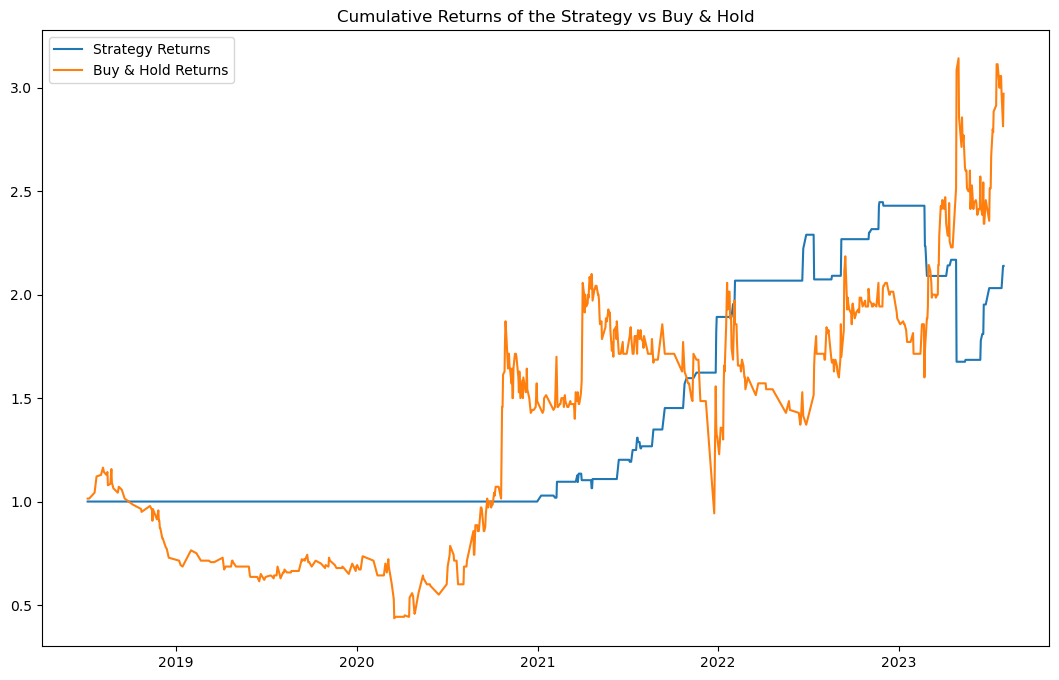

[*********************100%***********************]  1 of 1 completed
             Open   High    Low  Close  Adj Close     Volume
Date                                                        
2018-07-02  2.842  2.842  2.842  2.842      2.842   6244.833
2018-07-03  2.842  2.842  2.842  2.842      2.842  20607.947
2018-07-04  2.842  2.842  2.842  2.842      2.842   2497.933
2018-07-06  2.842  2.842  2.842  2.842      2.842  45712.174
2018-07-10  2.850  2.850  2.842  2.842      2.842   9492.145
...           ...    ...    ...    ...        ...        ...
2023-07-26  2.240  2.240  2.210  2.210      2.210  37800.000
2023-07-27  2.210  2.210  2.200  2.200      2.200  37400.000
2023-07-28  2.200  2.200  2.200  2.200      2.200  36000.000
2023-07-31  2.160  2.190  2.160  2.190      2.190  24000.000
2023-08-01  2.150  2.160  2.150  2.160      2.160   1600.000

[1060 rows x 6 columns]
             Open   High    Low  Close  Adj Close     Volume    SMA  \
Date                                      

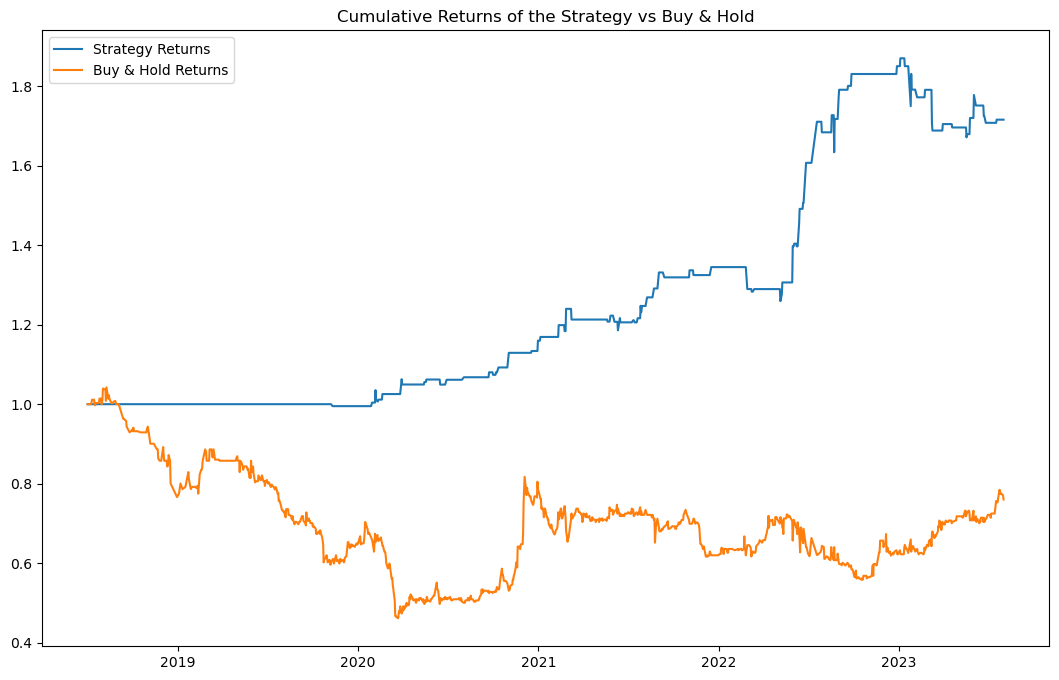

[*********************100%***********************]  1 of 1 completed
             Open   High    Low  Close  Adj Close     Volume
Date                                                        
2018-07-02  0.668  0.716  0.668  0.716      0.716  8.465e+04
2018-07-03  0.716  0.716  0.716  0.716      0.716  4.610e+04
2018-07-04  0.716  0.764  0.716  0.716      0.716  1.020e+05
2018-07-05  0.716  0.716  0.668  0.716      0.716  2.650e+04
2018-07-09  0.668  0.716  0.668  0.716      0.716  8.769e+04
...           ...    ...    ...    ...        ...        ...
2023-07-26  0.195  0.200  0.195  0.195      0.195  5.110e+05
2023-07-27  0.195  0.200  0.195  0.195      0.195  1.762e+06
2023-07-28  0.200  0.200  0.195  0.200      0.200  7.975e+05
2023-07-31  0.195  0.200  0.195  0.200      0.200  5.545e+05
2023-08-01  0.200  0.200  0.195  0.195      0.195  1.009e+05

[699 rows x 6 columns]
             Open   High    Low  Close  Adj Close     Volume    SMA  \
Date                                       

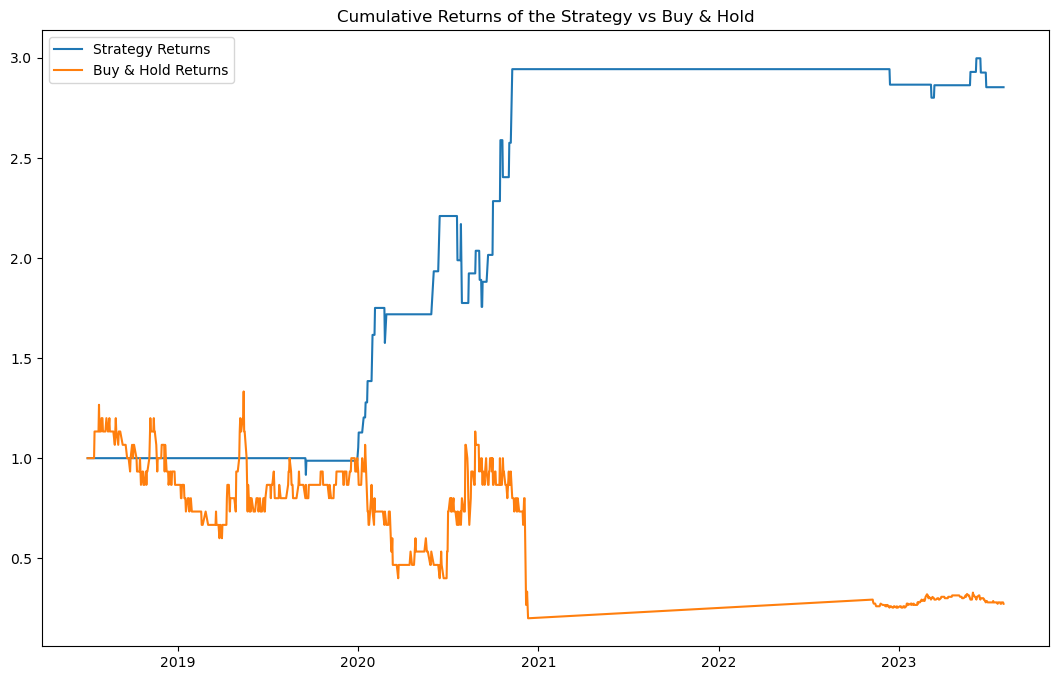

[*********************100%***********************]  1 of 1 completed
              Open    High     Low   Close  Adj Close      Volume
Date                                                             
2018-07-02  21.419  21.735  21.419  21.647     21.647  353378.158
2018-07-03  21.472  21.665  21.437  21.647     21.647  520653.708
2018-07-04  21.647  21.665  21.419  21.647     21.647  457098.127
2018-07-05  21.612  21.787  21.577  21.735     21.735  496007.327
2018-07-06  21.717  21.910  21.700  21.735     21.735  802945.378
...            ...     ...     ...     ...        ...         ...
2023-07-26  22.280  22.800  22.280  22.660     22.660  158200.000
2023-07-27  22.220  23.080  22.220  22.780     22.780  189200.000
2023-07-28  22.740  22.960  22.440  22.960     22.960  318600.000
2023-07-31  22.880  23.000  22.660  22.960     22.960  809600.000
2023-08-01  22.960  23.100  22.900  22.960     22.960    9400.000

[1239 rows x 6 columns]
              Open    High     Low   Close  Adj 

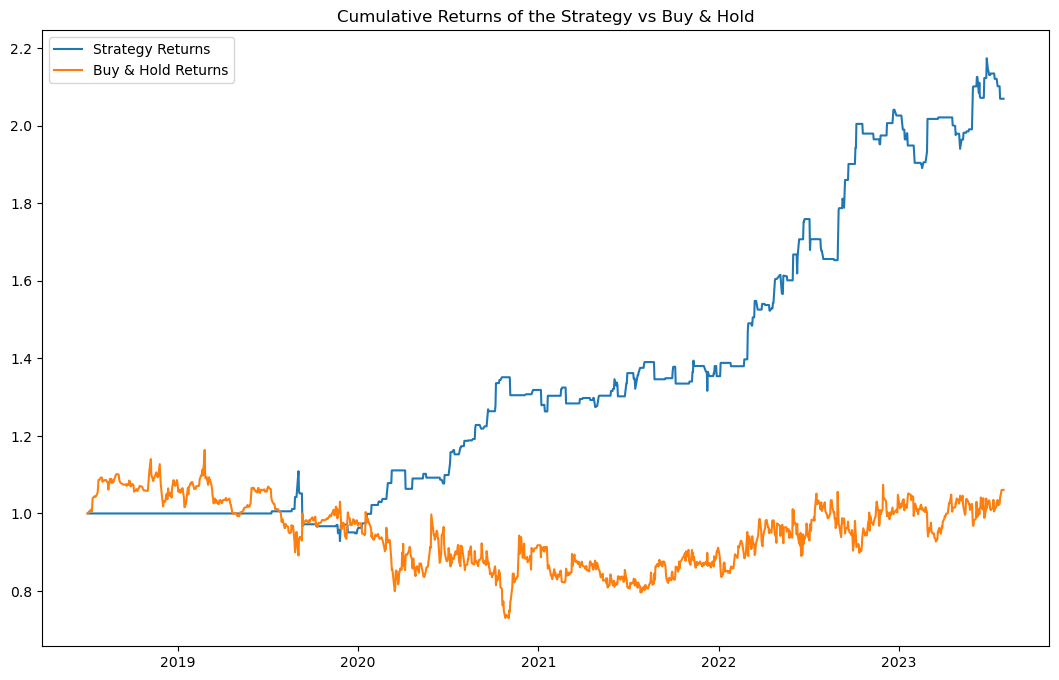

[*********************100%***********************]  1 of 1 completed
             Open   High    Low  Close  Adj Close   Volume
Date                                                      
2018-07-19  0.450  0.450  0.450  0.450      0.450    500.0
2018-07-23  0.390  0.450  0.390  0.410      0.410  35700.0
2018-07-24  0.410  0.410  0.390  0.390      0.390   1200.0
2018-10-15  0.310  0.310  0.310  0.310      0.310   3000.0
2018-10-16  0.310  0.310  0.310  0.310      0.310   9400.0
...           ...    ...    ...    ...        ...      ...
2023-07-21  0.810  0.810  0.805  0.805      0.805  10000.0
2023-07-24  0.855  0.880  0.805  0.830      0.830  24200.0
2023-07-25  0.835  0.835  0.835  0.835      0.835   5000.0
2023-07-26  0.845  0.845  0.845  0.845      0.845   5000.0
2023-07-31  0.845  0.845  0.840  0.840      0.840  10000.0

[580 rows x 6 columns]
             Open   High    Low  Close  Adj Close   Volume    SMA  PremDisc%  \
Date                                                        

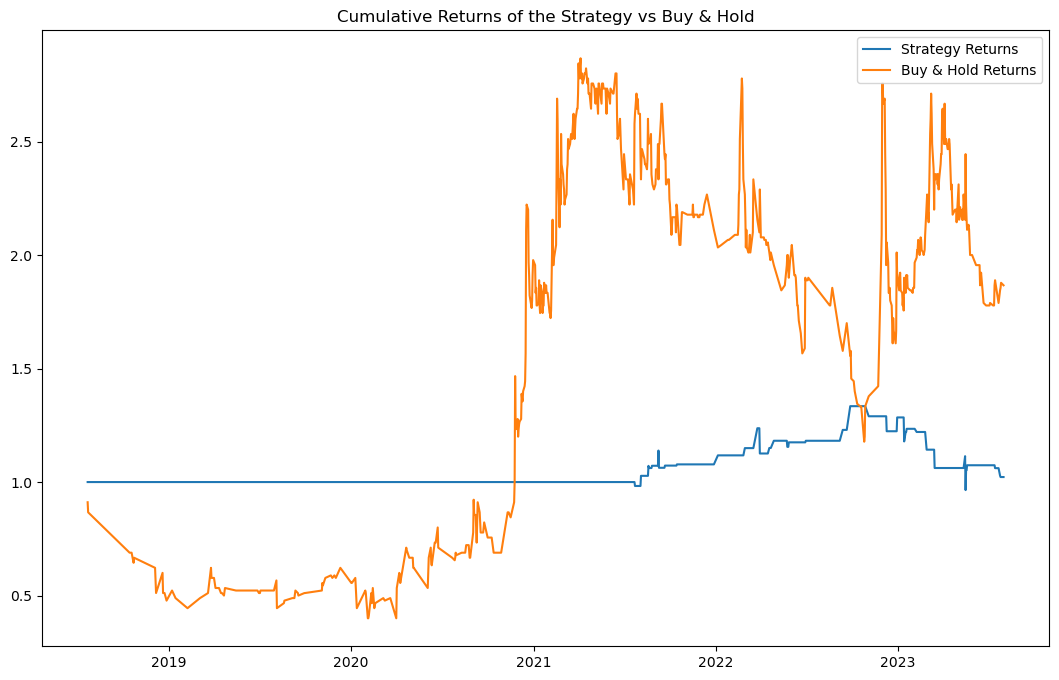

[*********************100%***********************]  1 of 1 completed
             Open   High    Low  Close  Adj Close     Volume
Date                                                        
2018-07-02  4.721  4.738  4.703  4.729      4.729  3.207e+06
2018-07-03  4.729  4.747  4.721  4.738      4.738  1.427e+06
2018-07-04  4.729  4.747  4.721  4.747      4.747  5.875e+05
2018-07-05  4.738  4.747  4.729  4.747      4.747  3.656e+06
2018-07-06  4.676  4.747  4.614  4.667      4.667  7.925e+06
...           ...    ...    ...    ...        ...        ...
2023-07-26  4.590  4.660  4.570  4.610      4.610  3.490e+06
2023-07-27  4.600  4.670  4.570  4.600      4.600  2.990e+06
2023-07-28  4.590  4.600  4.540  4.550      4.550  2.960e+06
2023-07-31  4.610  4.610  4.500  4.550      4.550  5.495e+06
2023-08-01  4.480  4.570  4.480  4.570      4.570  3.245e+05

[1240 rows x 6 columns]
             Open   High    Low  Close  Adj Close     Volume    SMA  \
Date                                      

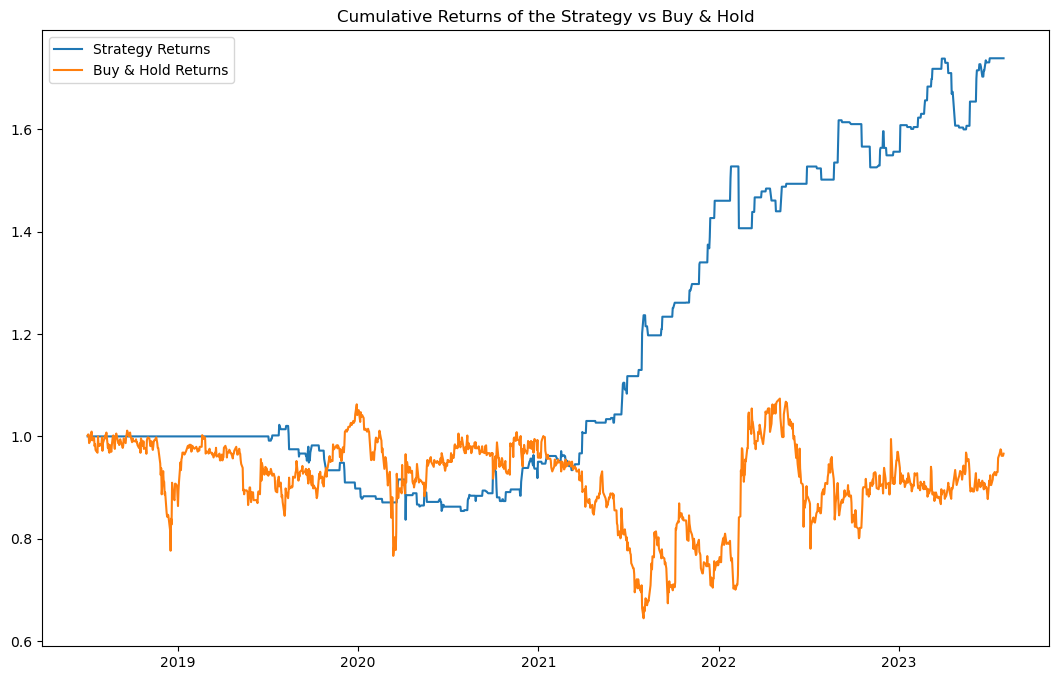

[*********************100%***********************]  1 of 1 completed
             Open   High    Low  Close  Adj Close     Volume
Date                                                        
2018-07-02  1.460  1.468  1.428  1.428      1.428  3.339e+06
2018-07-03  1.428  1.452  1.403  1.428      1.428  4.178e+06
2018-07-04  1.428  1.452  1.411  1.428      1.428  4.446e+06
2018-07-05  1.436  1.452  1.428  1.444      1.444  2.263e+06
2018-07-06  1.452  1.452  1.428  1.428      1.428  4.980e+06
...           ...    ...    ...    ...        ...        ...
2023-07-26  1.500  1.520  1.480  1.490      1.490  5.522e+06
2023-07-27  1.500  1.540  1.500  1.530      1.530  6.857e+06
2023-07-28  1.530  1.540  1.490  1.500      1.500  4.313e+06
2023-07-31  1.500  1.540  1.500  1.530      1.530  9.778e+06
2023-08-01  1.530  1.530  1.510  1.520      1.520  8.654e+05

[1238 rows x 6 columns]
             Open   High    Low  Close  Adj Close     Volume    SMA  \
Date                                      

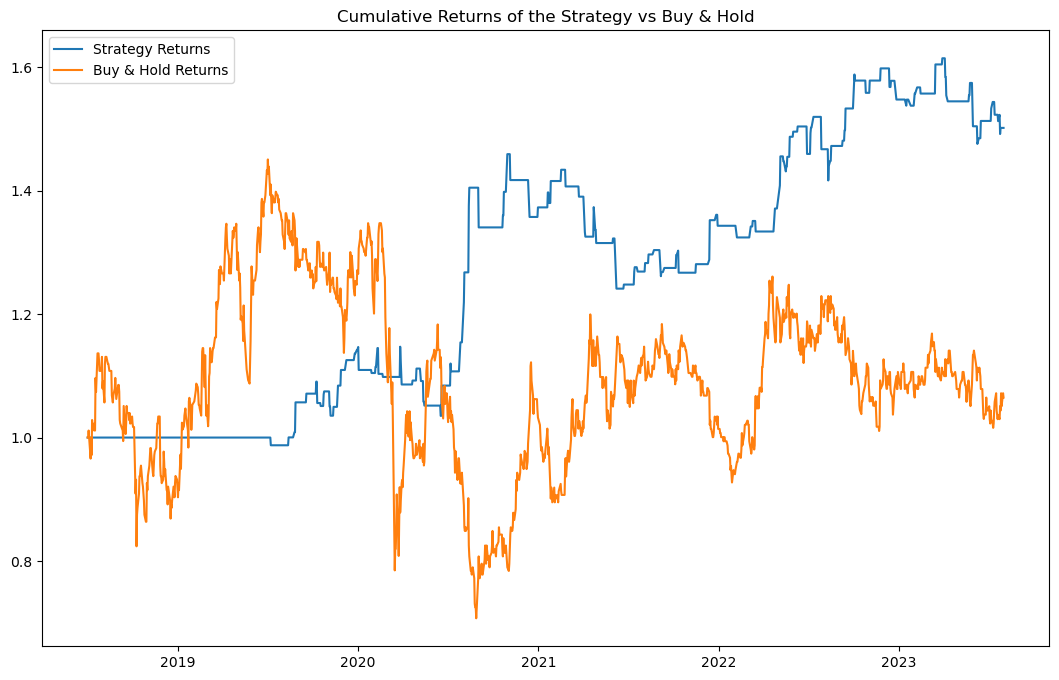

[*********************100%***********************]  1 of 1 completed
             Open   High    Low  Close  Adj Close     Volume
Date                                                        
2018-07-03  0.641  0.656  0.641  0.656      0.656   7121.263
2018-07-05  0.645  0.645  0.641  0.641      0.641  51791.000
2018-07-06  0.695  0.695  0.695  0.695      0.695    258.955
2018-07-12  0.649  0.687  0.645  0.687      0.687   2977.983
2018-07-13  0.684  0.684  0.684  0.684      0.684   2977.982
...           ...    ...    ...    ...        ...        ...
2023-07-25  0.470  0.470  0.465  0.465      0.465  19600.000
2023-07-26  0.455  0.470  0.455  0.460      0.460  16600.000
2023-07-27  0.470  0.470  0.455  0.455      0.455  26200.000
2023-07-28  0.470  0.480  0.470  0.480      0.480   2600.000
2023-07-31  0.475  0.475  0.460  0.470      0.470   9900.000

[1098 rows x 6 columns]
             Open   High    Low  Close  Adj Close     Volume    SMA  \
Date                                      

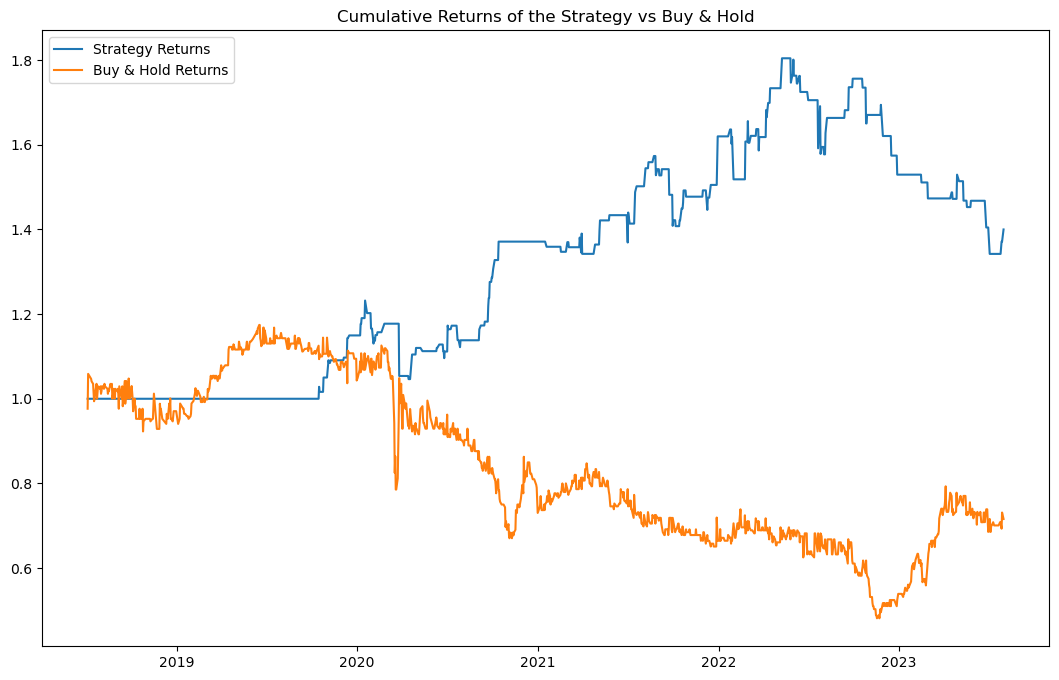

[*********************100%***********************]  1 of 1 completed
             Open   High    Low  Close  Adj Close     Volume
Date                                                        
2018-07-02  0.405  0.405  0.400  0.400      0.400  1.400e+04
2018-07-03  0.375  0.405  0.375  0.405      0.405  3.700e+04
2018-07-04  0.405  0.405  0.405  0.405      0.405  7.000e+03
2018-07-09  0.395  0.395  0.385  0.395      0.395  7.100e+05
2018-07-10  0.405  0.405  0.385  0.395      0.395  2.380e+04
...           ...    ...    ...    ...        ...        ...
2023-07-26  0.510  0.515  0.495  0.510      0.510  4.050e+06
2023-07-27  0.510  0.525  0.510  0.520      0.520  2.641e+06
2023-07-28  0.525  0.545  0.520  0.535      0.535  5.040e+06
2023-07-31  0.540  0.570  0.540  0.570      0.570  4.479e+06
2023-08-01  0.575  0.585  0.540  0.545      0.545  6.558e+06

[1029 rows x 6 columns]
             Open   High    Low  Close  Adj Close     Volume    SMA  \
Date                                      

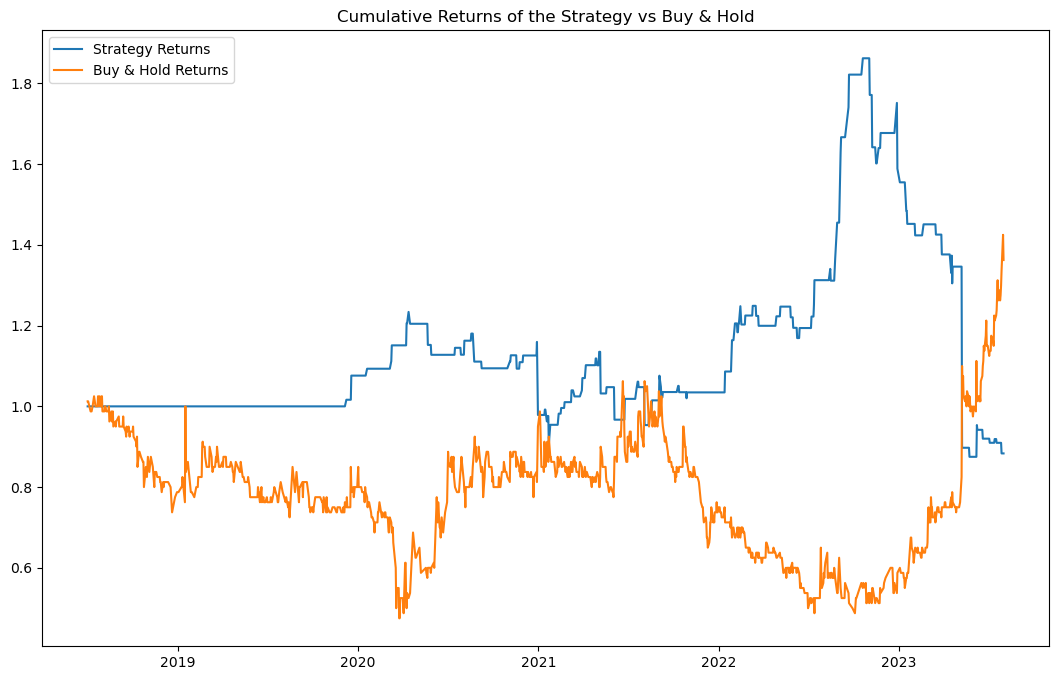

[*********************100%***********************]  1 of 1 completed
             Open   High    Low  Close  Adj Close     Volume
Date                                                        
2018-07-02  0.803  0.803  0.803  0.803      0.803  1.992e+04
2018-07-03  0.838  0.838  0.821  0.821      0.821  3.481e+04
2018-07-05  0.856  0.856  0.856  0.856      0.856  1.969e+04
2018-07-06  0.825  0.825  0.825  0.825      0.825  1.030e+04
2018-07-12  0.856  0.856  0.852  0.856      0.856  1.683e+04
...           ...    ...    ...    ...        ...        ...
2023-07-25  1.160  1.160  1.160  1.160      1.160  6.000e+03
2023-07-26  1.170  1.220  1.170  1.220      1.220  1.024e+07
2023-07-27  1.210  1.210  1.160  1.160      1.160  2.400e+03
2023-07-28  1.200  1.200  1.170  1.170      1.170  2.037e+05
2023-07-31  1.190  1.190  1.160  1.160      1.160  4.300e+04

[802 rows x 6 columns]
             Open   High    Low  Close  Adj Close     Volume    SMA  \
Date                                       

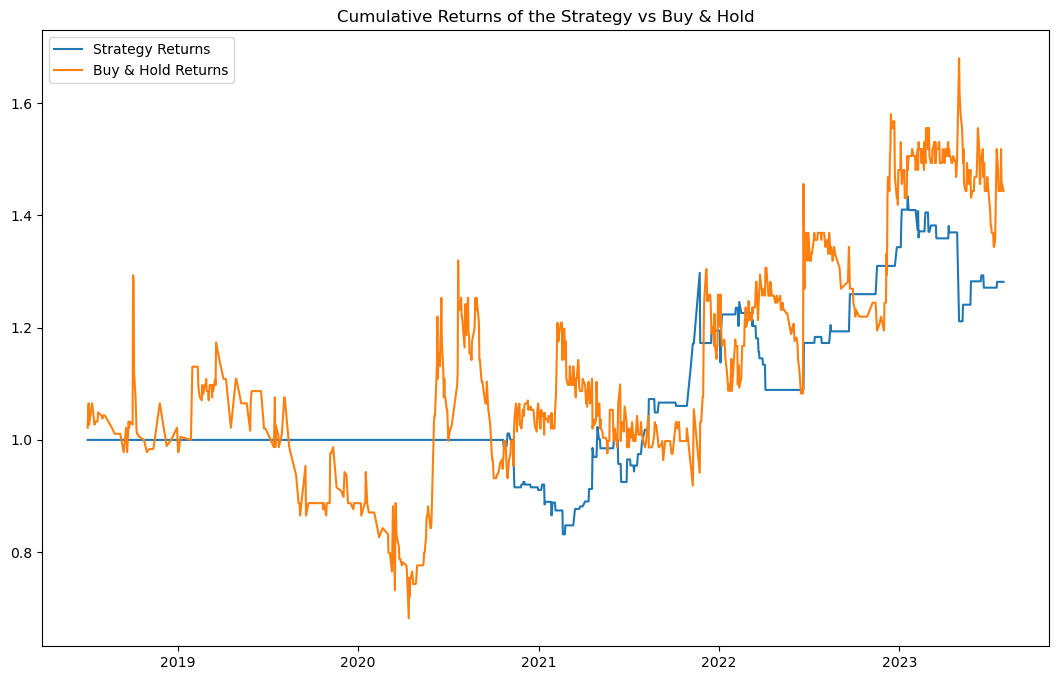

[*********************100%***********************]  1 of 1 completed
             Open   High    Low  Close  Adj Close     Volume
Date                                                        
2018-07-02  0.525  0.525  0.520  0.520      0.520  5.836e+05
2018-07-03  0.520  0.525  0.520  0.520      0.520  3.327e+05
2018-07-04  0.525  0.525  0.520  0.525      0.525  2.332e+05
2018-07-05  0.525  0.530  0.520  0.530      0.530  4.320e+05
2018-07-06  0.525  0.530  0.525  0.530      0.530  2.224e+05
...           ...    ...    ...    ...        ...        ...
2023-07-26  0.390  0.415  0.390  0.405      0.405  1.411e+07
2023-07-27  0.410  0.460  0.405  0.435      0.435  3.318e+07
2023-07-28  0.430  0.455  0.425  0.445      0.445  1.639e+07
2023-07-31  0.445  0.450  0.425  0.430      0.430  6.959e+06
2023-08-01  0.430  0.430  0.420  0.425      0.425  1.143e+06

[1239 rows x 6 columns]
             Open   High    Low  Close  Adj Close     Volume    SMA  \
Date                                      

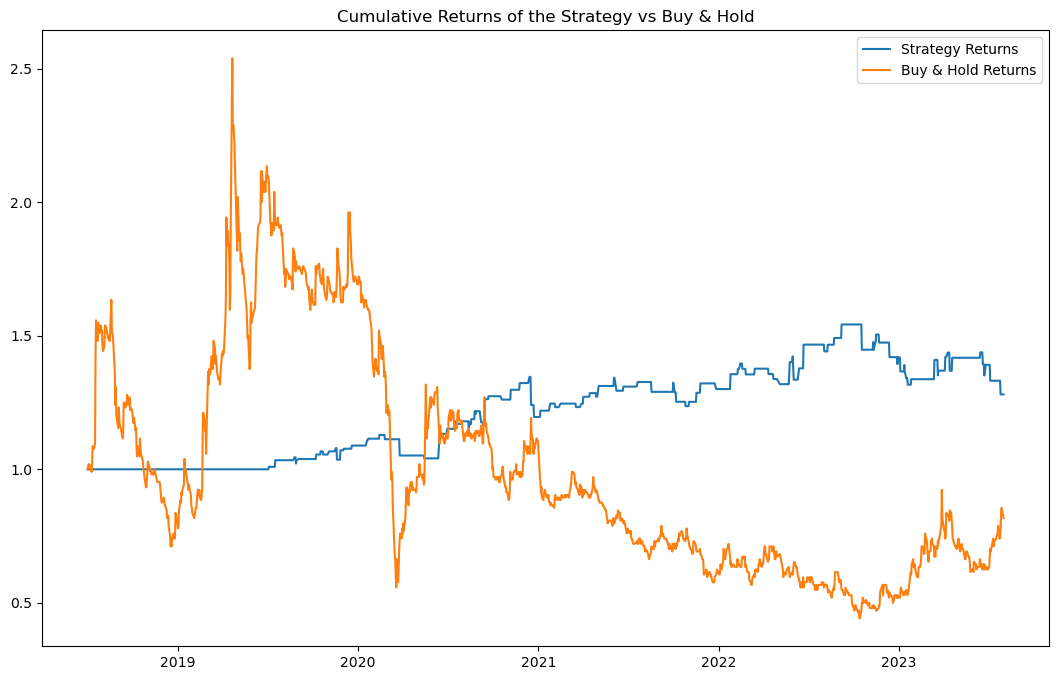

[*********************100%***********************]  1 of 1 completed
             Open   High    Low  Close  Adj Close     Volume
Date                                                        
2018-07-02  0.874  0.883  0.865  0.874      0.874  2.015e+06
2018-07-03  0.869  0.874  0.865  0.865      0.865  2.793e+05
2018-07-04  0.865  0.883  0.860  0.865      0.865  3.599e+06
2018-07-05  0.865  0.865  0.855  0.865      0.865  6.928e+05
2018-07-06  0.855  0.869  0.855  0.869      0.869  9.684e+05
...           ...    ...    ...    ...        ...        ...
2023-07-26  0.300  0.300  0.295  0.300      0.300  9.821e+05
2023-07-27  0.300  0.300  0.285  0.295      0.295  2.939e+06
2023-07-28  0.290  0.295  0.290  0.290      0.290  6.232e+05
2023-07-31  0.290  0.295  0.285  0.290      0.290  7.419e+05
2023-08-01  0.290  0.290  0.285  0.290      0.290  2.000e+05

[1239 rows x 6 columns]
             Open   High    Low  Close  Adj Close     Volume    SMA  \
Date                                      

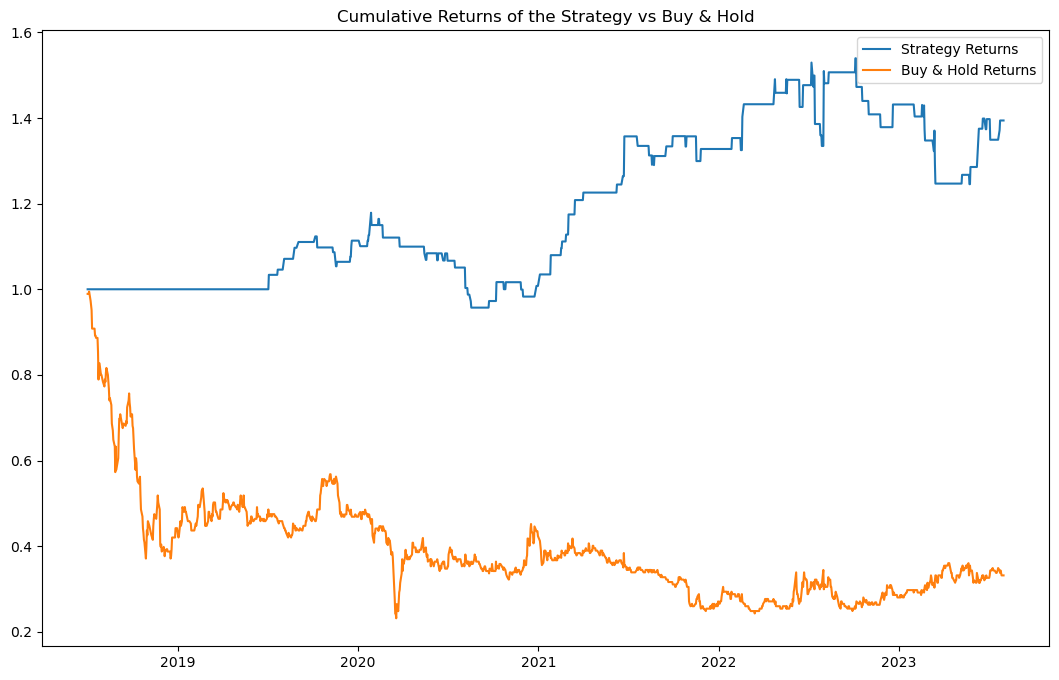

[*********************100%***********************]  1 of 1 completed
              Open    High     Low   Close  Adj Close      Volume
Date                                                             
2018-07-02  10.444  10.444  10.282  10.282     10.282   66716.496
2018-07-03  10.152  10.169  10.120  10.136     10.136   64373.400
2018-07-04  10.055  10.298   9.877  10.298     10.298   30460.209
2018-07-05   9.974  10.055   9.974  10.055     10.055    2959.696
2018-07-06   9.990   9.990   9.974   9.974      9.974    4562.865
...            ...     ...     ...     ...        ...         ...
2023-07-26  14.320  14.320  14.300  14.300     14.300   91700.000
2023-07-27  14.280  14.420  14.200  14.300     14.300  154500.000
2023-07-28  14.300  14.540  14.300  14.480     14.480   26300.000
2023-07-31  14.540  14.740  14.540  14.580     14.580   22000.000
2023-08-01  14.600  14.600  14.600  14.600     14.600     700.000

[1228 rows x 6 columns]
              Open    High     Low   Close  Adj 

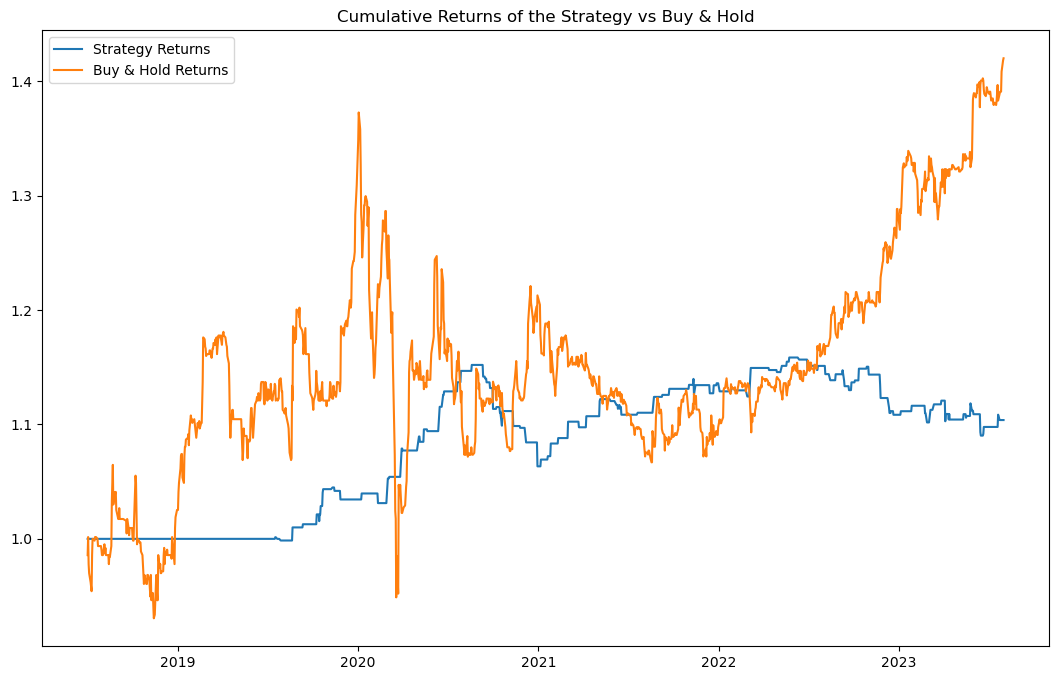

[*********************100%***********************]  1 of 1 completed
             Open   High    Low  Close  Adj Close     Volume
Date                                                        
2018-07-02  1.609  1.609  1.609  1.609      1.609    185.463
2018-07-03  1.582  1.582  1.566  1.572      1.572  26100.530
2018-07-04  1.566  1.566  1.566  1.566      1.566  52759.875
2018-07-06  1.566  1.566  1.566  1.566      1.566   5592.971
2018-07-18  1.550  1.550  1.550  1.550      1.550  29829.175
...           ...    ...    ...    ...        ...        ...
2023-07-25  2.130  2.140  2.120  2.140      2.140  12400.000
2023-07-26  2.110  2.110  2.110  2.110      2.110   9300.000
2023-07-27  2.150  2.150  2.130  2.130      2.130    200.000
2023-07-28  2.120  2.120  2.110  2.110      2.110   5500.000
2023-07-31  2.110  2.110  2.110  2.110      2.110  10300.000

[1069 rows x 6 columns]
             Open   High    Low  Close  Adj Close     Volume    SMA  \
Date                                      

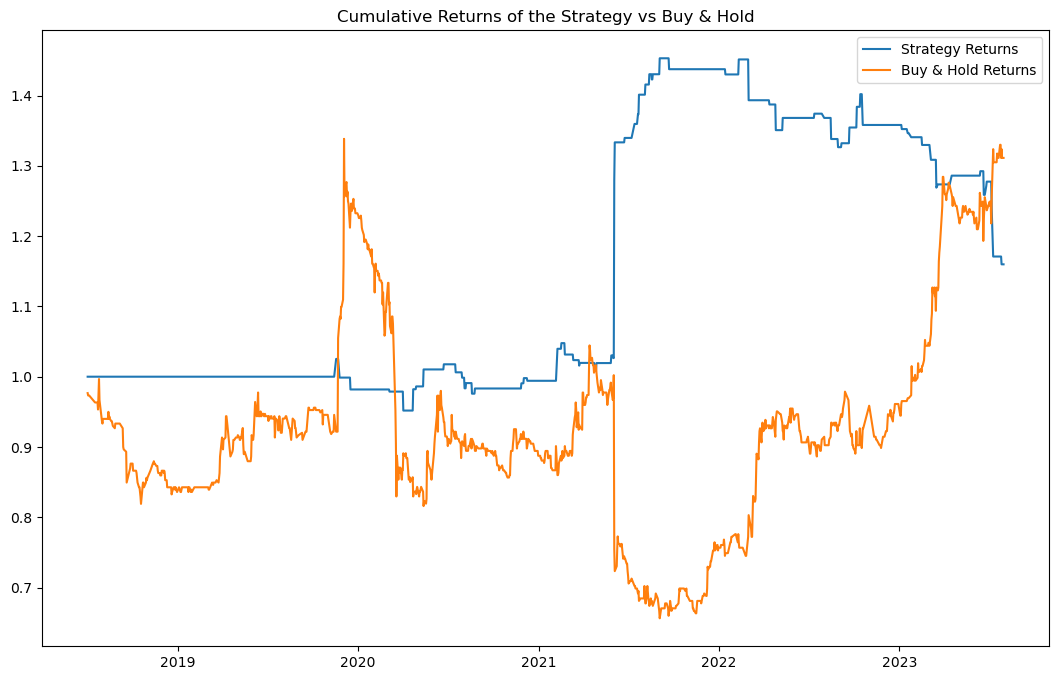

[*********************100%***********************]  1 of 1 completed
             Open   High    Low  Close  Adj Close     Volume
Date                                                        
2018-07-02  0.515  0.525  0.515  0.525      0.525  4.000e+04
2018-07-03  0.520  0.530  0.510  0.510      0.510  1.140e+05
2018-07-04  0.500  0.500  0.495  0.495      0.495  5.900e+04
2018-07-06  0.515  0.520  0.515  0.520      0.520  2.500e+04
2018-07-10  0.520  0.525  0.520  0.525      0.525  3.600e+04
...           ...    ...    ...    ...        ...        ...
2023-07-26  0.185  0.185  0.175  0.175      0.175  1.089e+07
2023-07-27  0.175  0.180  0.170  0.175      0.175  1.853e+07
2023-07-28  0.175  0.180  0.175  0.180      0.180  3.422e+06
2023-07-31  0.180  0.180  0.175  0.175      0.175  3.783e+06
2023-08-01  0.175  0.175  0.175  0.175      0.175  2.695e+06

[766 rows x 6 columns]
             Open   High    Low  Close  Adj Close     Volume    SMA  \
Date                                       

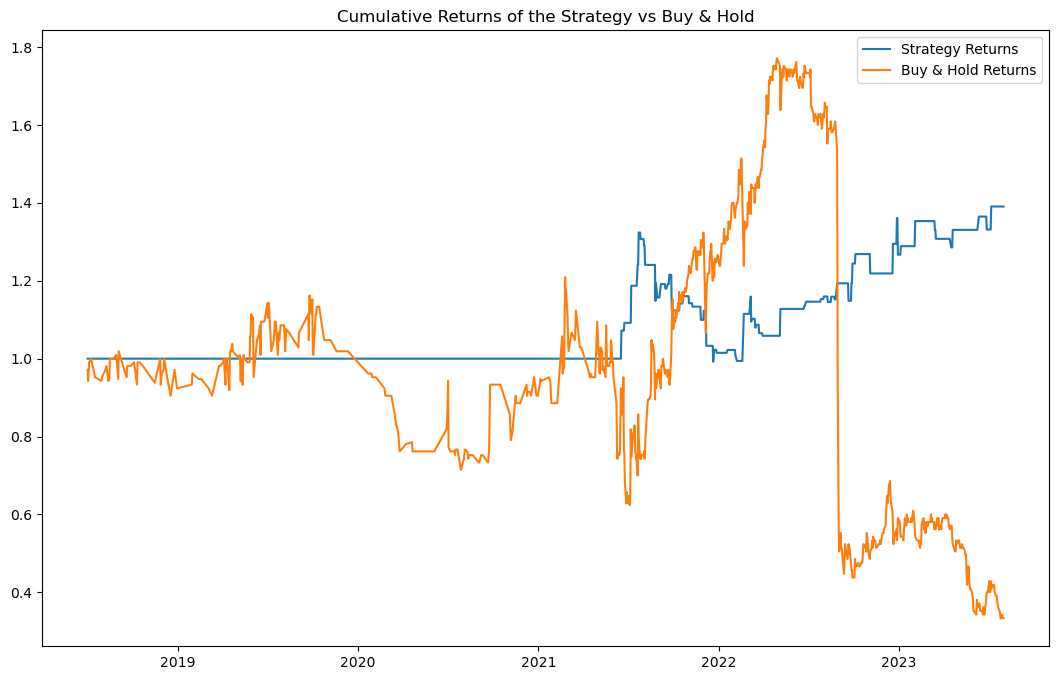

[*********************100%***********************]  1 of 1 completed
             Open   High    Low  Close  Adj Close     Volume
Date                                                        
2018-07-02  1.220  1.228  1.213  1.228      1.228  2.080e+05
2018-07-03  1.205  1.260  1.205  1.260      1.260  5.042e+05
2018-07-04  1.252  1.252  1.228  1.236      1.236  4.889e+04
2018-07-05  1.228  1.244  1.228  1.236      1.236  8.407e+04
2018-07-06  1.228  1.228  1.220  1.220      1.220  1.970e+05
...           ...    ...    ...    ...        ...        ...
2023-07-26  0.260  0.290  0.255  0.270      0.270  2.815e+07
2023-07-27  0.270  0.280  0.265  0.270      0.270  6.512e+06
2023-07-28  0.270  0.270  0.255  0.260      0.260  5.589e+06
2023-07-31  0.260  0.265  0.240  0.250      0.250  2.055e+07
2023-08-01  0.250  0.265  0.250  0.265      0.265  1.858e+06

[1240 rows x 6 columns]
             Open   High    Low  Close  Adj Close     Volume    SMA  \
Date                                      

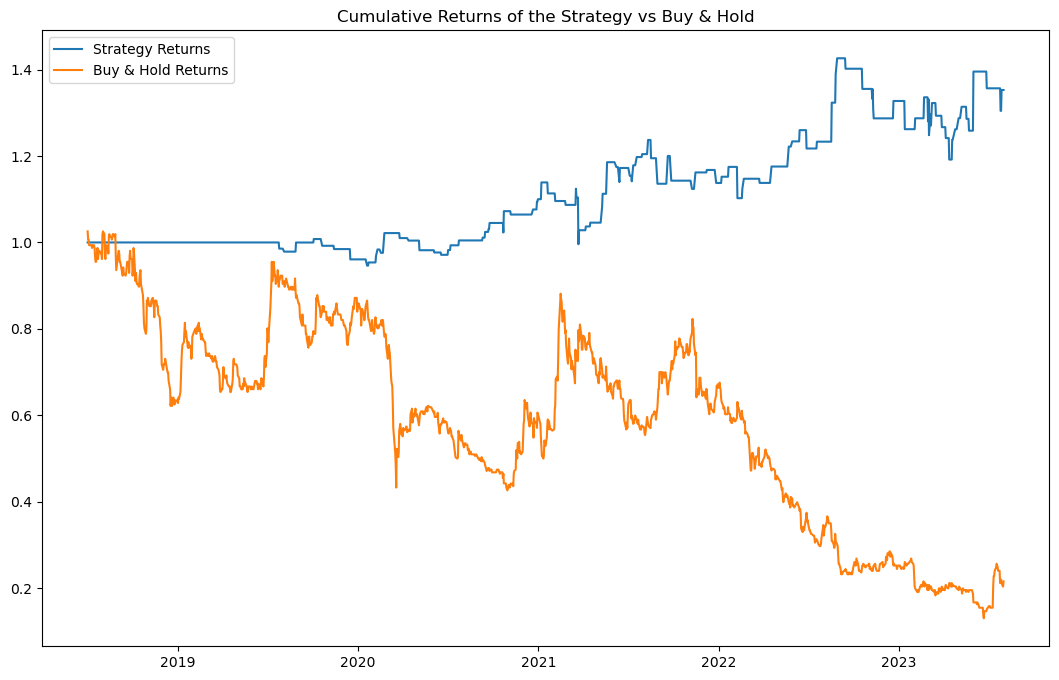

[*********************100%***********************]  1 of 1 completed
             Open   High    Low  Close  Adj Close      Volume
Date                                                         
2018-07-02  0.424  0.424  0.410  0.410      0.410  226703.464
2018-07-04  0.413  0.413  0.413  0.413      0.413     141.513
2018-07-12  0.403  0.420  0.396  0.399      0.399   63822.266
2018-07-13  0.420  0.420  0.399  0.403      0.403   97785.335
2018-07-16  0.403  0.417  0.403  0.417      0.417   15424.893
...           ...    ...    ...    ...        ...         ...
2023-07-26  0.645  0.660  0.645  0.660      0.660  146100.000
2023-07-27  0.660  0.665  0.655  0.655      0.655  107900.000
2023-07-28  0.655  0.665  0.655  0.660      0.660  208000.000
2023-07-31  0.660  0.680  0.660  0.670      0.670  227000.000
2023-08-01  0.670  0.670  0.670  0.670      0.670   83100.000

[1185 rows x 6 columns]
             Open   High    Low  Close  Adj Close      Volume    SMA  \
Date                        

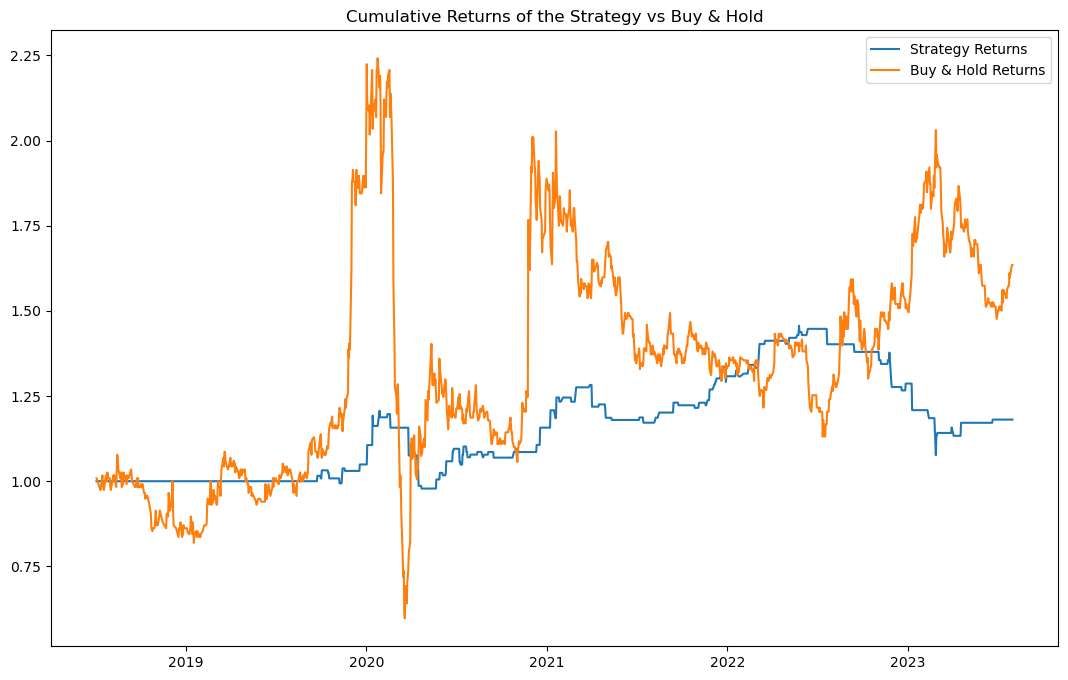

[*********************100%***********************]  1 of 1 completed
             Open   High    Low  Close  Adj Close      Volume
Date                                                         
2018-07-03  1.324  1.324  1.318  1.318      1.318   10472.128
2018-07-04  1.318  1.318  1.318  1.318      1.318    8028.632
2018-07-11  1.306  1.318  1.306  1.318      1.318   20071.579
2018-07-19  1.341  1.341  1.341  1.341      1.341    5934.206
2018-07-20  1.346  1.346  1.324  1.341      1.341   48346.327
...           ...    ...    ...    ...        ...         ...
2023-07-25  1.440  1.450  1.440  1.450      1.450   75000.000
2023-07-26  1.430  1.440  1.420  1.440      1.440  302600.000
2023-07-27  1.440  1.450  1.440  1.440      1.440  325500.000
2023-07-28  1.440  1.450  1.420  1.440      1.440  241800.000
2023-07-31  1.450  1.460  1.440  1.460      1.460   53500.000

[1032 rows x 6 columns]
             Open   High    Low  Close  Adj Close      Volume    SMA  \
Date                        

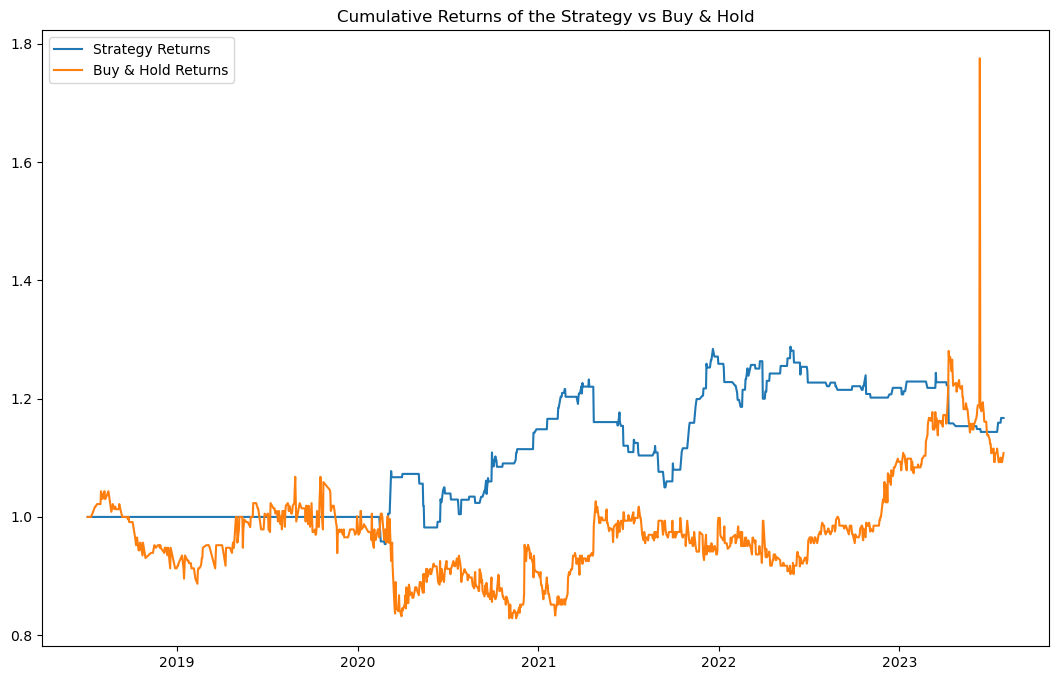

[*********************100%***********************]  1 of 1 completed
             Open   High    Low  Close  Adj Close     Volume
Date                                                        
2018-07-02  4.445  4.528  4.445  4.520      4.520  2.326e+06
2018-07-03  4.536  4.544  4.404  4.453      4.453  1.425e+06
2018-07-04  4.445  4.486  4.420  4.437      4.437  5.759e+05
2018-07-05  4.453  4.486  4.445  4.462      4.462  2.727e+05
2018-07-06  4.445  4.462  4.313  4.313      4.313  1.875e+06
...           ...    ...    ...    ...        ...        ...
2023-07-26  4.030  4.040  3.990  4.010      4.010  4.267e+06
2023-07-27  4.000  4.100  4.000  4.040      4.040  4.561e+06
2023-07-28  4.040  4.050  4.010  4.030      4.030  2.254e+06
2023-07-31  4.040  4.060  4.020  4.040      4.040  5.565e+06
2023-08-01  4.040  4.050  4.030  4.030      4.030  7.340e+04

[1240 rows x 6 columns]
             Open   High    Low  Close  Adj Close     Volume    SMA  \
Date                                      

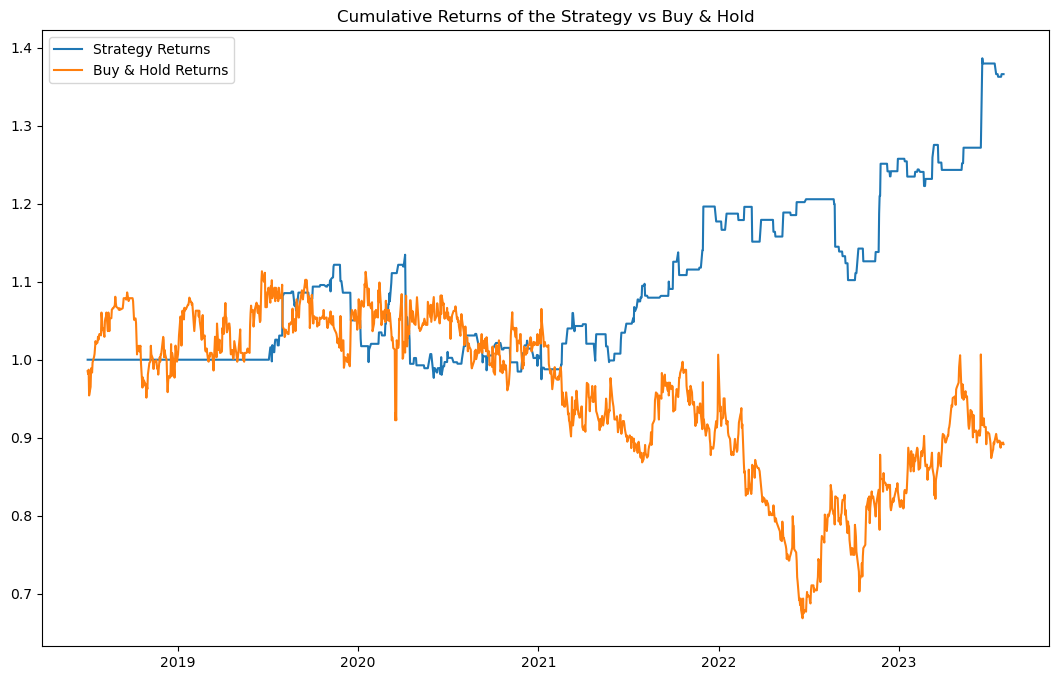

[*********************100%***********************]  1 of 1 completed
             Open   High    Low  Close  Adj Close     Volume
Date                                                        
2018-07-05  0.050  0.053  0.050  0.053      0.053  5.760e+04
2018-07-06  0.048  0.052  0.048  0.052      0.052  3.873e+05
2018-07-16  0.053  0.065  0.053  0.065      0.065  2.727e+05
2018-07-17  0.050  0.050  0.050  0.050      0.050  1.500e+04
2018-07-18  0.050  0.057  0.050  0.057      0.057  1.953e+05
...           ...    ...    ...    ...        ...        ...
2023-07-26  0.083  0.083  0.075  0.075      0.075  5.936e+05
2023-07-27  0.070  0.075  0.065  0.075      0.075  1.504e+06
2023-07-28  0.070  0.070  0.065  0.065      0.065  1.111e+06
2023-07-31  0.065  0.075  0.065  0.075      0.075  1.224e+06
2023-08-01  0.075  0.075  0.075  0.075      0.075  9.000e+04

[722 rows x 6 columns]
             Open   High    Low  Close  Adj Close     Volume    SMA  \
Date                                       

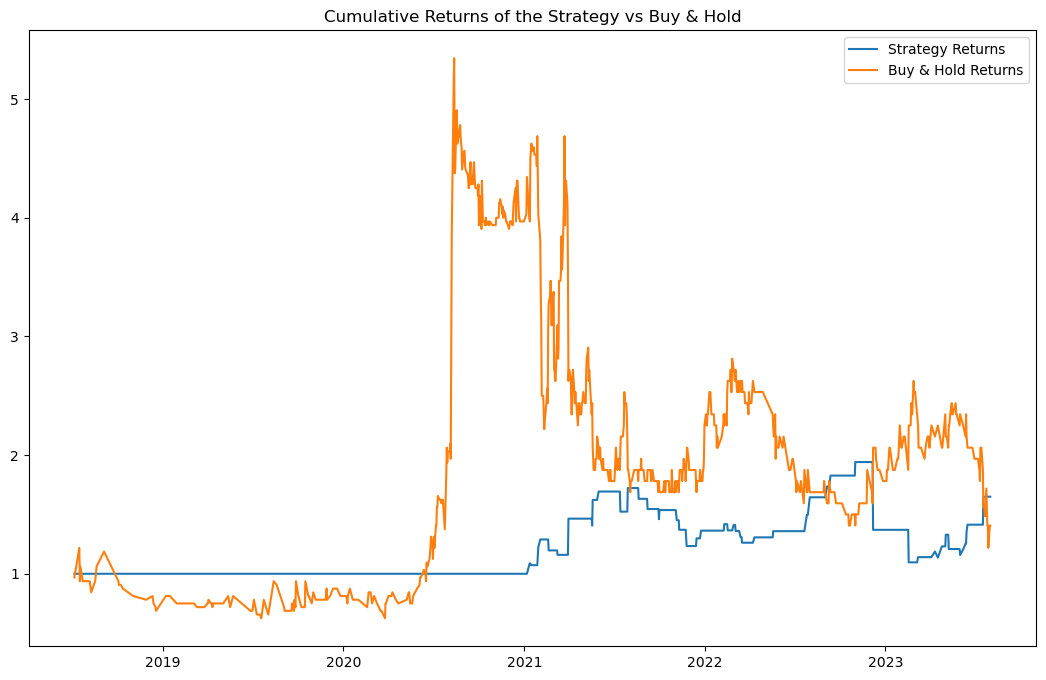

[*********************100%***********************]  1 of 1 completed
             Open   High    Low  Close  Adj Close     Volume
Date                                                        
2018-07-02  6.107  6.123  6.099  6.099      6.099  18320.640
2018-07-03  6.083  6.083  6.083  6.083      6.083   3837.432
2018-07-04  6.083  6.099  6.083  6.083      6.083  32803.851
2018-07-05  6.099  6.099  6.099  6.099      6.099    371.364
2018-07-06  6.083  6.180  6.083  6.083      6.083   7674.863
...           ...    ...    ...    ...        ...        ...
2023-07-26  5.330  5.400  5.330  5.340      5.340   4200.000
2023-07-27  5.360  5.400  5.360  5.400      5.400   2000.000
2023-07-28  5.290  5.380  5.290  5.320      5.320   1600.000
2023-07-31  5.320  5.390  5.320  5.390      5.390  11400.000
2023-08-01  5.390  5.390  5.380  5.380      5.380  34800.000

[1188 rows x 6 columns]
             Open   High    Low  Close  Adj Close     Volume    SMA  \
Date                                      

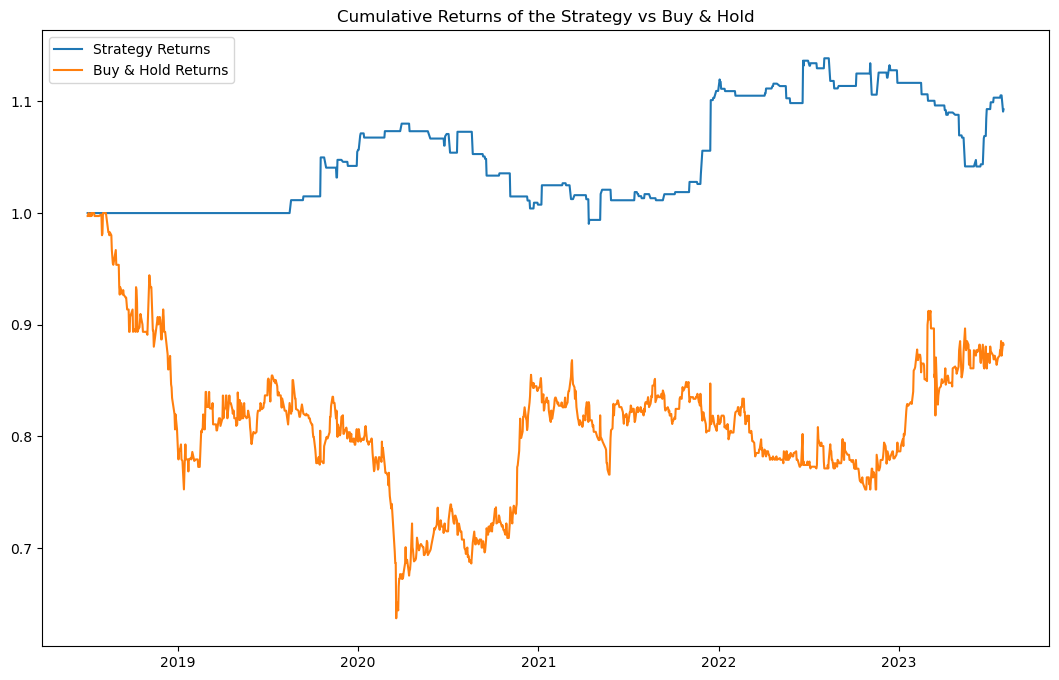

[*********************100%***********************]  1 of 1 completed
             Open   High    Low  Close  Adj Close     Volume
Date                                                        
2018-07-02  0.195  0.200  0.185  0.185      0.185  1.586e+06
2018-07-03  0.185  0.195  0.185  0.190      0.190  1.363e+06
2018-07-04  0.190  0.190  0.185  0.190      0.190  1.253e+06
2018-07-05  0.195  0.225  0.195  0.205      0.205  1.444e+07
2018-07-06  0.205  0.215  0.190  0.200      0.200  6.596e+06
...           ...    ...    ...    ...        ...        ...
2023-07-26  0.175  0.175  0.165  0.170      0.170  3.331e+06
2023-07-27  0.170  0.175  0.170  0.175      0.175  1.092e+06
2023-07-28  0.170  0.170  0.165  0.170      0.170  1.272e+06
2023-07-31  0.170  0.175  0.170  0.170      0.170  3.718e+06
2023-08-01  0.170  0.180  0.170  0.180      0.180  3.061e+06

[1238 rows x 6 columns]
             Open   High    Low  Close  Adj Close     Volume    SMA  \
Date                                      

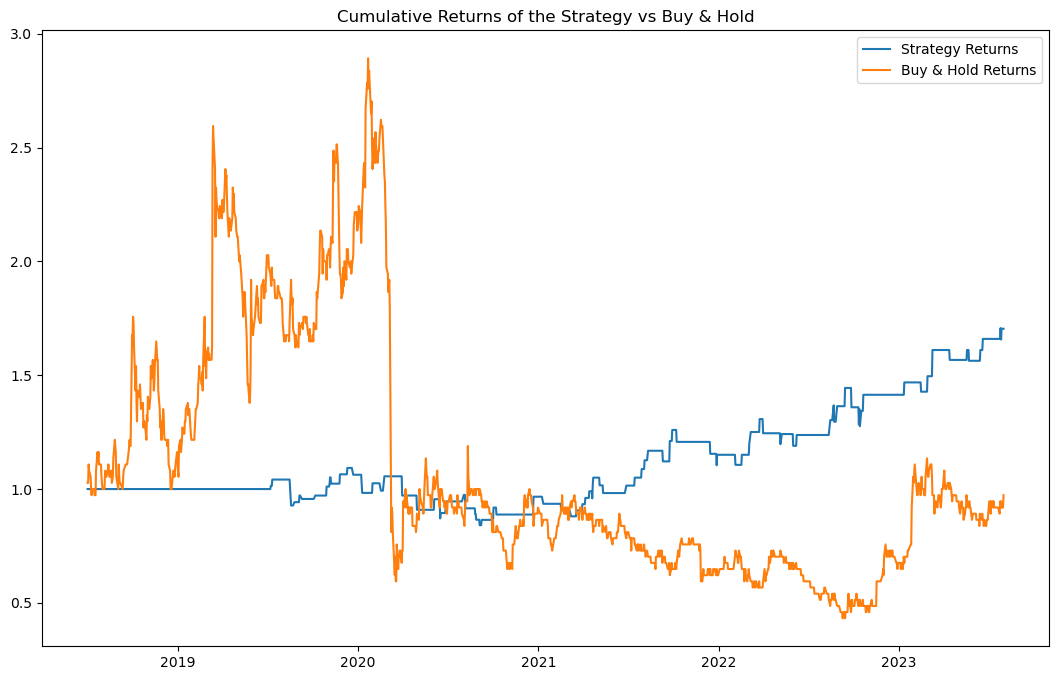

[*********************100%***********************]  1 of 1 completed
             Open   High    Low  Close  Adj Close     Volume
Date                                                        
2018-07-02  0.261  0.261  0.261  0.261      0.261  1.036e+04
2018-07-06  0.270  0.270  0.265  0.265      0.265  1.244e+05
2018-07-19  0.275  0.275  0.275  0.275      0.275  1.606e+04
2018-07-25  0.285  0.289  0.285  0.289      0.289  2.477e+04
2018-08-06  0.270  0.270  0.270  0.270      0.270  8.363e+04
...           ...    ...    ...    ...        ...        ...
2023-07-26  0.405  0.410  0.400  0.405      0.405  4.038e+05
2023-07-27  0.405  0.415  0.405  0.410      0.410  6.988e+05
2023-07-28  0.415  0.440  0.415  0.440      0.440  6.446e+06
2023-07-31  0.455  0.480  0.450  0.475      0.475  7.698e+06
2023-08-01  0.470  0.475  0.450  0.455      0.455  1.644e+06

[796 rows x 6 columns]
             Open   High    Low  Close  Adj Close     Volume    SMA  \
Date                                       

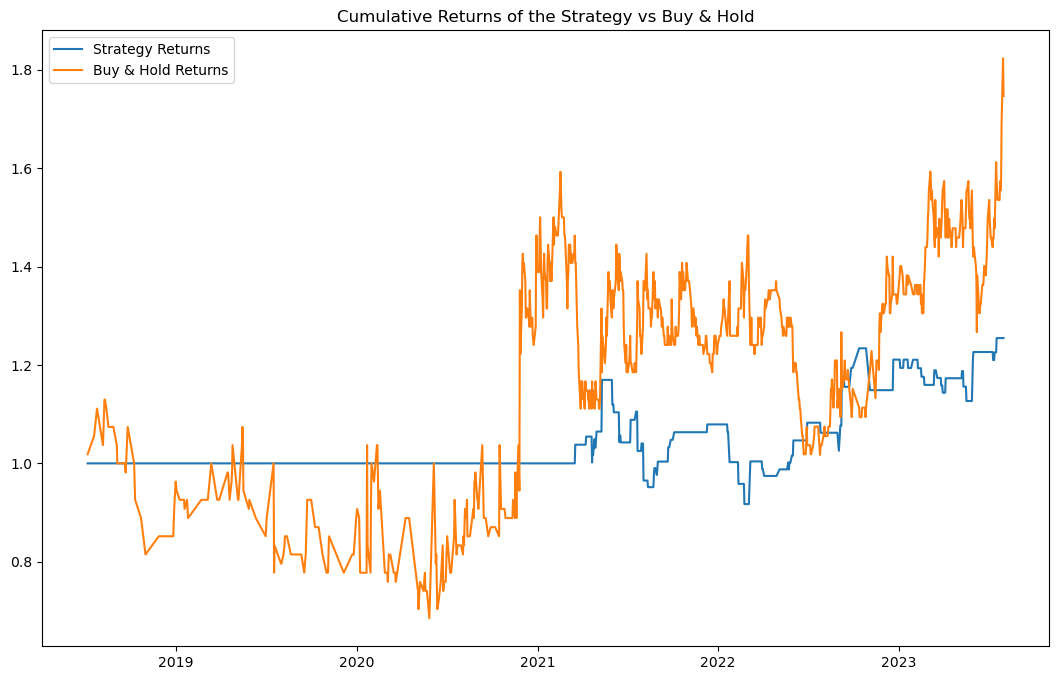

[*********************100%***********************]  1 of 1 completed
             Open   High    Low  Close  Adj Close     Volume
Date                                                        
2018-07-02  0.915  0.967  0.915  0.967      0.967   4167.514
2018-07-03  0.960  0.960  0.960  0.960      0.960   1344.359
2018-07-10  0.907  0.937  0.907  0.937      0.937  82274.780
2018-07-13  0.952  0.952  0.945  0.945      0.945  36969.872
2018-07-16  0.952  0.952  0.915  0.922      0.922   9410.510
...           ...    ...    ...    ...        ...        ...
2023-07-26  1.260  1.260  1.260  1.260      1.260  45100.000
2023-07-27  1.250  1.260  1.250  1.260      1.260  20500.000
2023-07-28  1.250  1.260  1.250  1.260      1.260  39400.000
2023-07-31  1.260  1.260  1.250  1.250      1.250  36900.000
2023-08-01  1.260  1.260  1.260  1.260      1.260   1700.000

[1172 rows x 6 columns]
             Open   High    Low  Close  Adj Close     Volume    SMA  \
Date                                      

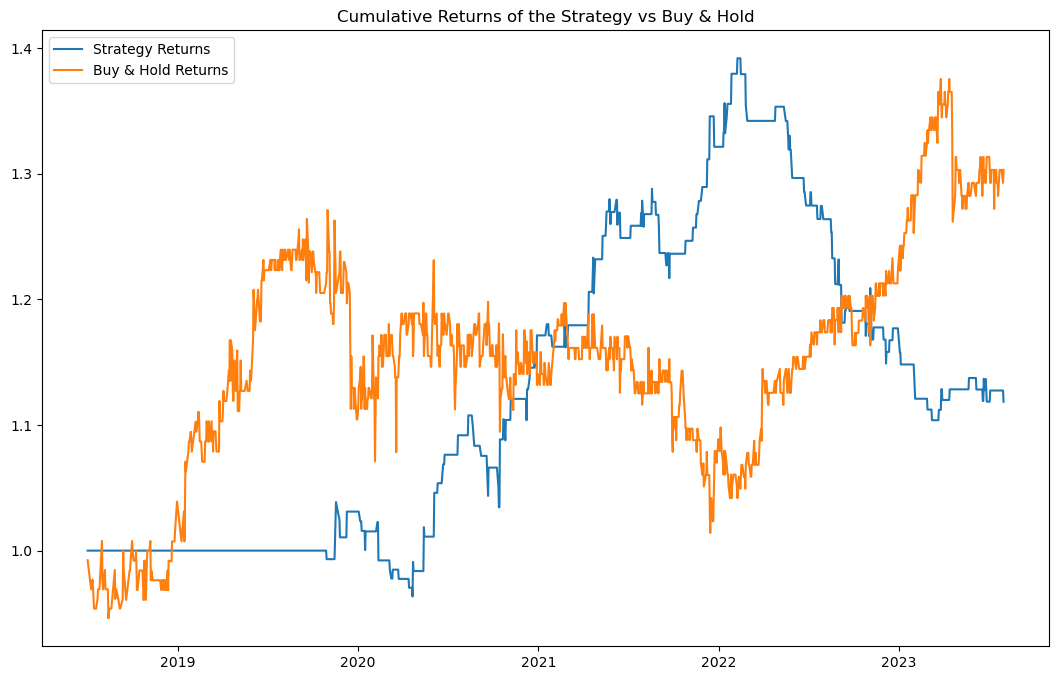

[*********************100%***********************]  1 of 1 completed
             Open   High    Low  Close  Adj Close     Volume
Date                                                        
2018-07-03  0.712  0.712  0.712  0.712      0.712  9.123e+02
2018-07-09  0.707  0.712  0.707  0.712      0.712  1.825e+03
2018-07-17  0.795  0.795  0.712  0.712      0.712  8.211e+03
2018-07-20  0.712  0.712  0.712  0.712      0.712  5.474e+03
2018-08-23  0.767  0.767  0.767  0.767      0.767  1.800e+02
...           ...    ...    ...    ...        ...        ...
2023-07-26  1.780  1.890  1.780  1.890      1.890  1.964e+06
2023-07-27  1.880  1.890  1.840  1.870      1.870  8.984e+05
2023-07-28  1.870  1.910  1.870  1.880      1.880  2.936e+06
2023-07-31  1.880  1.910  1.850  1.890      1.890  2.277e+06
2023-08-01  1.890  1.890  1.860  1.860      1.860  7.190e+05

[697 rows x 6 columns]
             Open   High    Low  Close  Adj Close     Volume    SMA  \
Date                                       

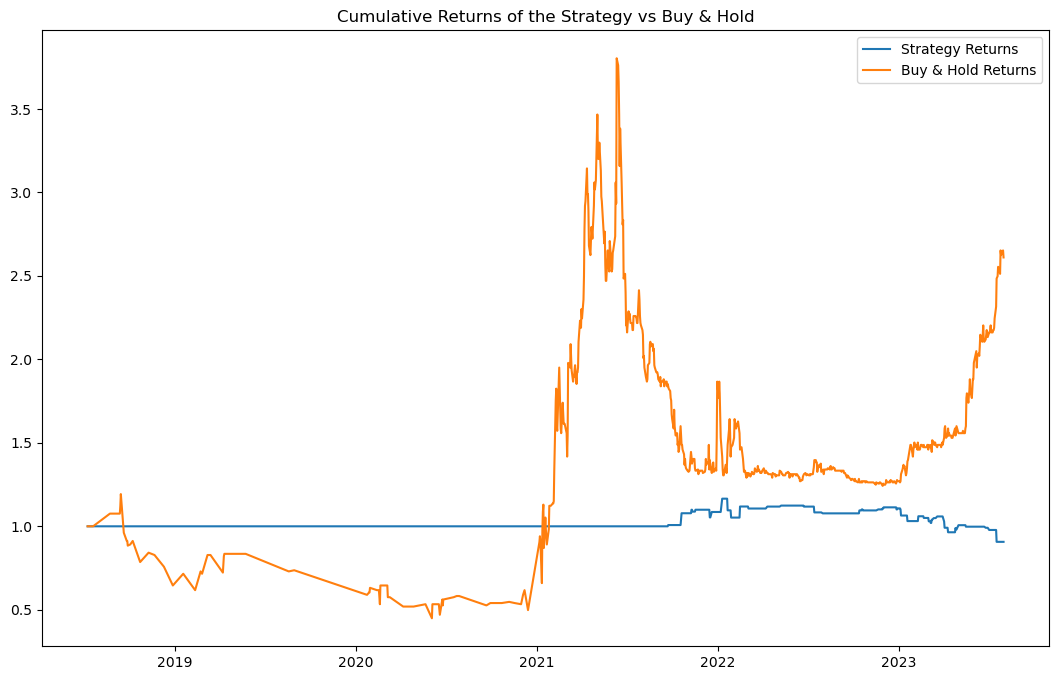

[*********************100%***********************]  1 of 1 completed
             Open   High    Low  Close  Adj Close     Volume
Date                                                        
2018-07-02  0.405  0.405  0.376  0.385      0.385  3.912e+06
2018-07-03  0.390  0.390  0.376  0.376      0.376  3.796e+06
2018-07-04  0.380  0.385  0.361  0.376      0.376  6.188e+06
2018-07-05  0.376  0.376  0.361  0.361      0.361  2.582e+06
2018-07-06  0.361  0.376  0.351  0.376      0.376  4.203e+06
...           ...    ...    ...    ...        ...        ...
2023-07-26  0.470  0.470  0.460  0.460      0.460  7.068e+05
2023-07-27  0.465  0.465  0.455  0.465      0.465  1.986e+06
2023-07-28  0.465  0.480  0.445  0.460      0.460  5.153e+06
2023-07-31  0.460  0.465  0.450  0.460      0.460  1.564e+06
2023-08-01  0.460  0.460  0.455  0.460      0.460  9.830e+04

[1232 rows x 6 columns]
             Open   High    Low  Close  Adj Close     Volume    SMA  \
Date                                      

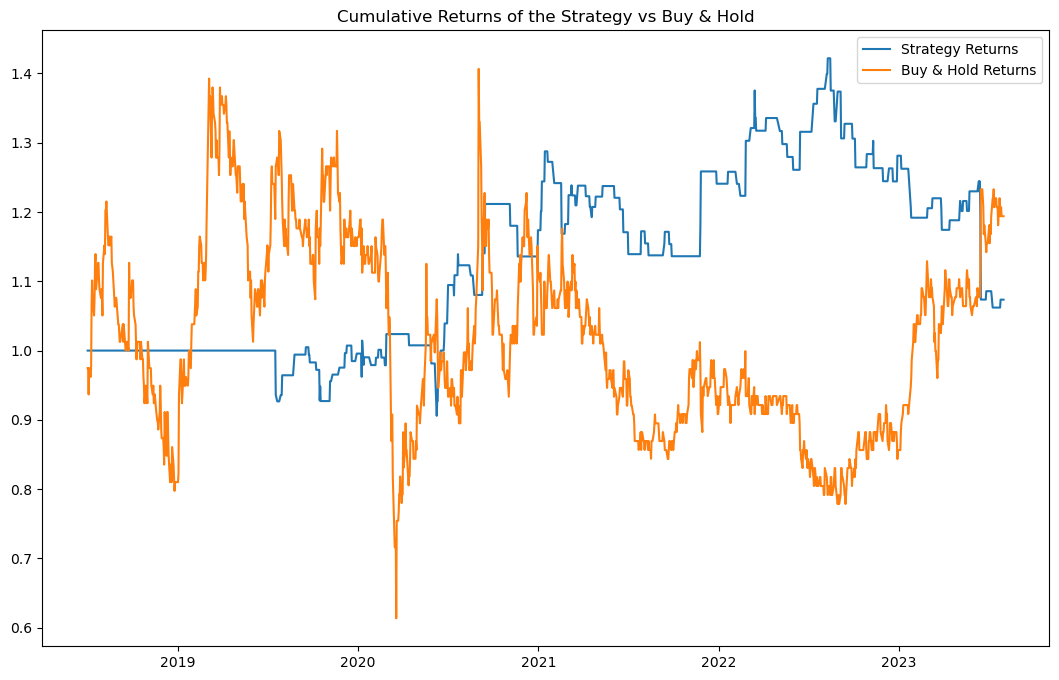

[*********************100%***********************]  1 of 1 completed
              Open    High     Low   Close  Adj Close     Volume
Date                                                            
2018-07-02  14.796  14.901  14.781  14.856     14.856  8.855e+05
2018-07-03  14.766  14.916  14.766  14.856     14.856  8.625e+05
2018-07-04  14.750  14.916  14.750  14.916     14.916  1.750e+05
2018-07-05  14.916  14.946  14.916  14.946     14.946  5.003e+05
2018-07-06  14.871  14.871  14.645  14.750     14.750  1.466e+06
...            ...     ...     ...     ...        ...        ...
2023-07-26  16.660  16.760  16.560  16.680     16.680  2.178e+05
2023-07-27  16.700  16.980  16.400  16.640     16.640  3.215e+05
2023-07-28  16.560  16.640  16.380  16.400     16.400  1.589e+05
2023-07-31  16.500  16.840  16.460  16.700     16.700  6.443e+05
2023-08-01  16.660  16.780  16.660  16.660     16.660  3.000e+02

[1239 rows x 6 columns]
              Open    High     Low   Close  Adj Close     Vol

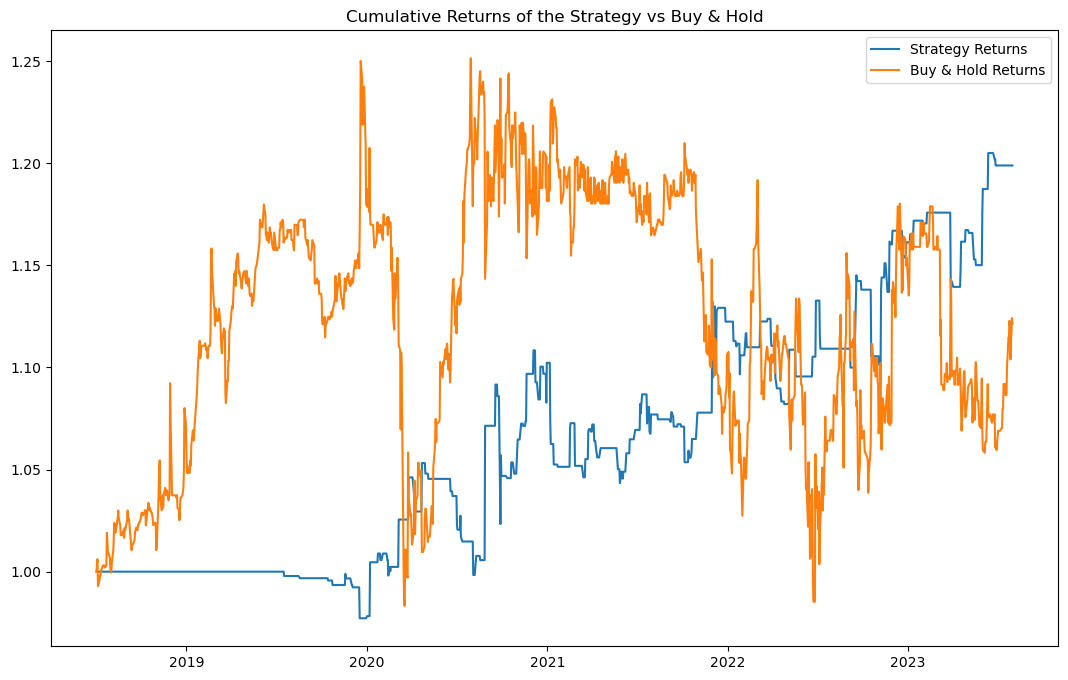

[*********************100%***********************]  1 of 1 completed
             Open   High    Low  Close  Adj Close      Volume
Date                                                         
2018-07-02  0.209  0.221  0.209  0.213      0.213  272954.076
2018-07-03  0.221  0.230  0.209  0.217      0.217  174786.378
2018-07-04  0.213  0.217  0.209  0.217      0.217   90984.690
2018-07-05  0.217  0.234  0.213  0.230      0.230   23344.756
2018-07-06  0.209  0.209  0.209  0.209      0.209  204954.980
...           ...    ...    ...    ...        ...         ...
2023-07-24  0.280  0.290  0.280  0.290      0.290   40000.000
2023-07-25  0.290  0.290  0.290  0.290      0.290   11400.000
2023-07-26  0.275  0.275  0.275  0.275      0.275   10000.000
2023-07-27  0.275  0.285  0.275  0.285      0.285   34200.000
2023-07-31  0.290  0.290  0.290  0.290      0.290     200.000

[938 rows x 6 columns]
             Open   High    Low  Close  Adj Close      Volume    SMA  \
Date                         

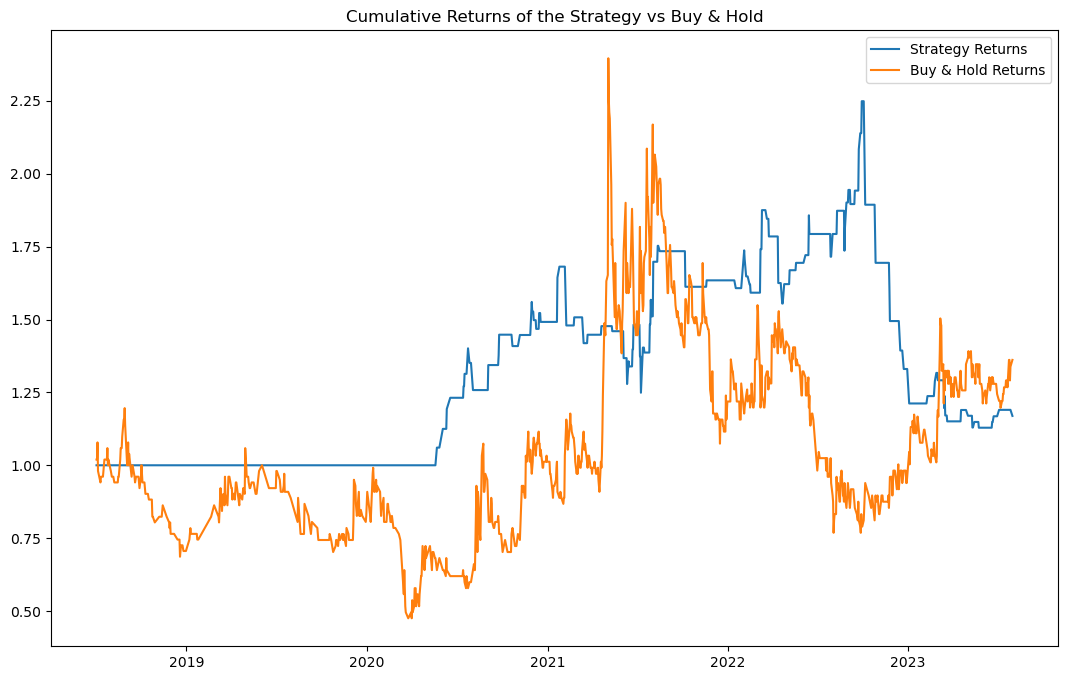

[*********************100%***********************]  1 of 1 completed
             Open   High    Low  Close  Adj Close     Volume
Date                                                        
2018-07-02  1.303  1.372  1.284  1.372      1.372  1.374e+06
2018-07-03  1.323  1.352  1.303  1.323      1.323  1.057e+06
2018-07-04  1.333  1.362  1.323  1.362      1.362  9.445e+05
2018-07-05  1.362  1.362  1.333  1.333      1.333  7.441e+05
2018-07-06  1.323  1.323  1.313  1.323      1.323  8.041e+05
...           ...    ...    ...    ...        ...        ...
2023-07-25  4.920  5.100  4.920  5.100      5.100  3.100e+04
2023-07-26  4.970  5.080  4.900  5.050      5.050  1.231e+05
2023-07-27  4.990  5.050  4.970  5.000      5.000  5.980e+04
2023-07-28  4.920  5.030  4.920  5.030      5.030  5.150e+04
2023-07-31  5.050  5.080  5.050  5.080      5.080  1.500e+03

[1217 rows x 6 columns]
             Open   High    Low  Close  Adj Close     Volume    SMA  \
Date                                      

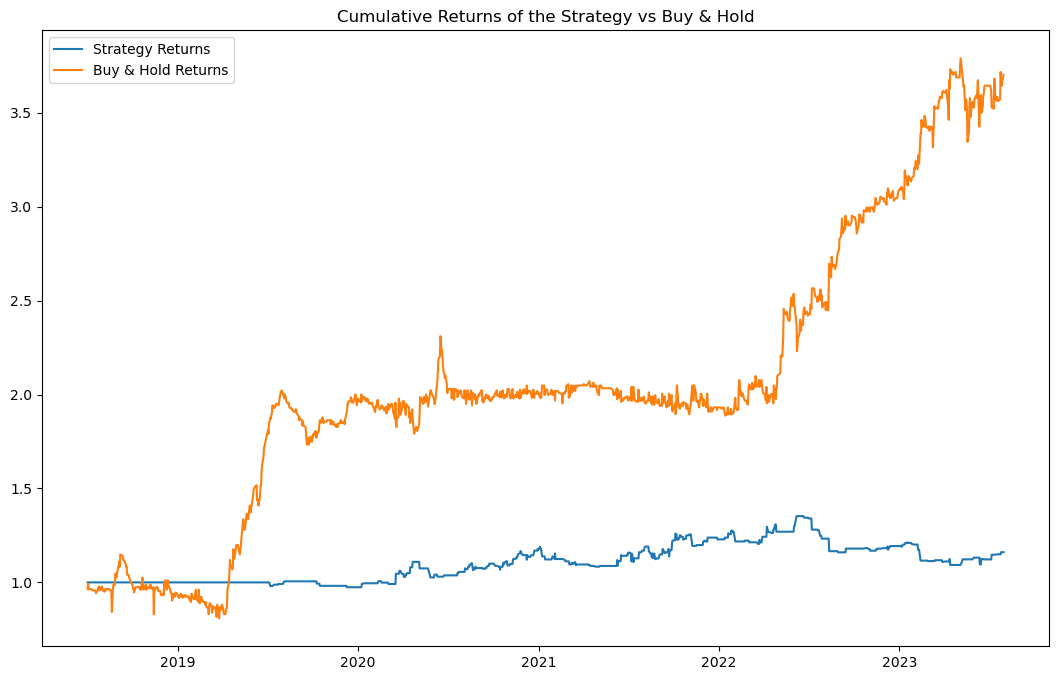

[*********************100%***********************]  1 of 1 completed
             Open   High    Low  Close  Adj Close    Volume
Date                                                       
2018-07-02  2.062  2.071  2.062  2.071      2.071  114827.0
2018-07-03  2.081  2.090  2.081  2.090      2.090   11105.0
2018-07-04  2.090  2.090  2.071  2.071      2.071   22630.0
2018-07-05  2.071  2.071  2.062  2.071      2.071  112312.0
2018-07-06  2.052  2.052  2.043  2.052      2.052   70195.0
...           ...    ...    ...    ...        ...       ...
2023-07-25  2.460  2.490  2.460  2.460      2.460    9900.0
2023-07-26  2.460  2.460  2.460  2.460      2.460   12500.0
2023-07-27  2.460  2.480  2.460  2.470      2.470   57900.0
2023-07-28  2.460  2.460  2.450  2.460      2.460   27000.0
2023-07-31  2.440  2.470  2.400  2.470      2.470   12300.0

[1218 rows x 6 columns]
             Open   High    Low  Close  Adj Close    Volume    SMA  PremDisc%  \
Date                                         

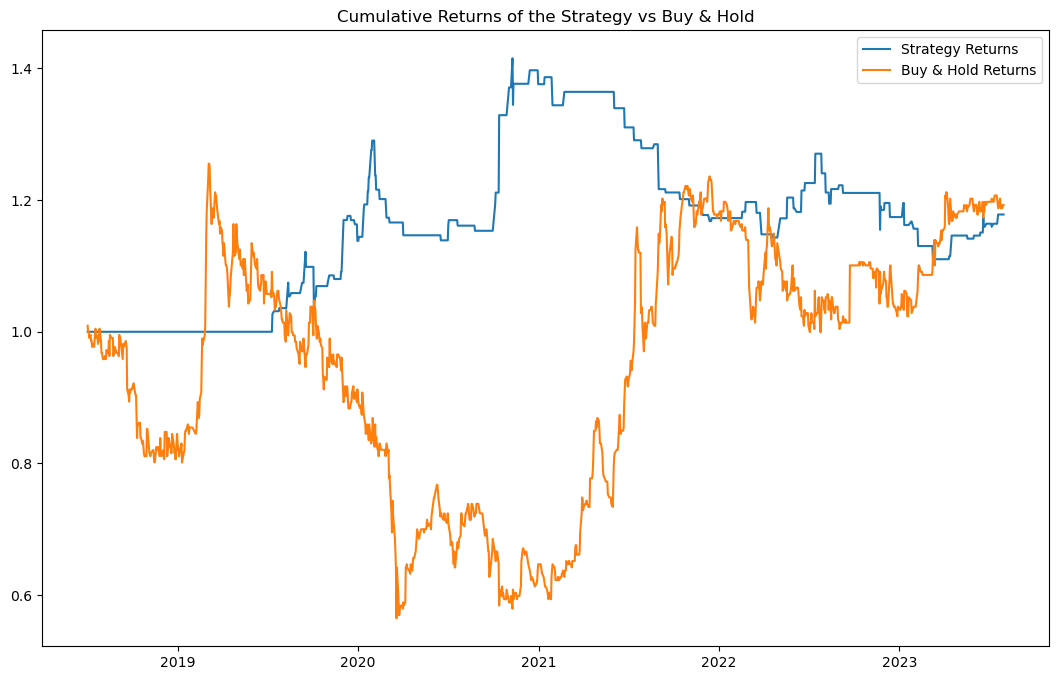

In [5]:
# Run the Back-Test

tickers = top_tickers_df.index # tickers_df.index #


# Load the best parameters
best_params = pd.read_csv('min_best_params.csv', index_col=0)  # Assuming ticker symbols are in the first column


for ticker in tickers:
    try:
        # Define a function to calculate the Z-Score
        def Z_Score(df, window):
            df['mean'] = df['PremDisc%'].rolling(window=window).mean()
            df['std'] = df['PremDisc%'].rolling(window=window).std()
            df['Z_Score'] = (df['PremDisc%'] - df['mean']) / df['std']
            return df
        
        def ZScore(df, window):
            df['Mean'] = df['MisPricing%'].rolling(window=window).mean()
            df['Std'] = df['MisPricing%'].rolling(window=window).std()
            df['ZScore'] = (df['MisPricing%'] - df['Mean']) / df['Std']
            return df

        # Fetch the data
        df = yf.download(ticker, start=start1, end=end2)

        df["Volume"] = 1 / (df["Adj Close"] / df["Close"]) * df["Volume"] 
        df["Open"] = df["Adj Close"] / df["Close"] * df["Open"] 
        df["High"] = df["Adj Close"] / df["Close"] * df["High"] 
        df["Low"] = df["Adj Close"] / df["Close"] * df["Low"] 
        df["Close"] = df["Adj Close"]
        df = df[df['Volume'] != 0]
        df.fillna(method='ffill', inplace=True)
        print(df)

        # Get the best parameters for this ticker
        params = best_params.loc[ticker]

        # Calculate the SMA
        df["SMA"] = df["Close"].rolling(window=int(params['sma_window'])).mean()

        # Calculate the premium/discount
        df["PremDisc%"] = (df["Close"]/df["SMA"] - 1)*100

        # Calculate Z-Score
        df = Z_Score(df, window=int(params['zscore_window']))

        df["TSF"] = TSF(df["Close"].values, timeperiod=int(params['sma_window']))
        df["MisPricing%"] = (df["TSF"]/df["Close"] - 1)*100
        df = ZScore(df, window=int(params['zscore_window']))

        
        # Define buy and sell zones
        buyZScoreTH = params['buyZScoreTH']
        sellZScoreTH = params['sellZScoreTH']

        buyZone = (df["Z_Score"] > -1*buyZScoreTH) & (df["ZScore"] > -1*buyZScoreTH)
        prebuyZone = (df["Z_Score"].shift(1) <= -1*buyZScoreTH) & (df["ZScore"].shift(1) <= -1*buyZScoreTH)
        sellZone1 = (df["Z_Score"] < 1*sellZScoreTH) & (df["ZScore"] < 1*sellZScoreTH)
        presellZone1 = (df["Z_Score"].shift(1) >= 1*sellZScoreTH) & (df["ZScore"].shift(1) >= 1*sellZScoreTH)
        sellZone2 = ((df["Z_Score"] < 0) & (df["Z_Score"].shift(1) > 0)) | ((df["ZScore"] < 0) & (df["ZScore"].shift(1) > 0))


        # Generate trading signals
        df["BuySignal"] = np.where(buyZone & prebuyZone, 1, 0)
        df["SellSignal"] = np.where((sellZone1 & presellZone1) | sellZone2, -1, 0)
        df["Signal"] = df["BuySignal"] + df["SellSignal"]

        # Calculate the ATR
        df["ATR"] = ATR(df["High"].values, df["Low"].values, df["Close"].values, timeperiod=int(params['ATR_window']))

        # Define SL and TP multipliers
        SL_multiplier = params['SL_multiplier']
        TP_multiplier = params['TP_multiplier']

        # Initialize SL and TP levels to NaN
        df["SL"] = np.nan
        df["TP"] = np.nan

        # Define initial capital
        capital = 10000

        # Calculate the number of shares to buy
        df["Shares"] = capital // (df["ATR"] * 100)

        # Create a variable to hold the entry price
        entry_price = 0

        # Define SL and TP levels based on entry price
        for i in range(len(df)):
            if df["Signal"].iloc[i] == 1:
                entry_price = df["Close"].iloc[i]
                df["SL"].iloc[i] = entry_price - SL_multiplier * df["ATR"].iloc[i]
                df["TP"].iloc[i] = entry_price + TP_multiplier * df["ATR"].iloc[i]
            elif df["Signal"].iloc[i] == -1:
                entry_price = 0
                df["SL"].iloc[i] = np.nan
                df["TP"].iloc[i] = np.nan
            else:
                df["SL"].iloc[i] = df["SL"].iloc[i-1]
                df["TP"].iloc[i] = df["TP"].iloc[i-1]

        # Fill in the rest of SL and TP columns
        df["SL"].fillna(method='ffill', inplace=True)
        df["TP"].fillna(method='ffill', inplace=True)

        # Calculate daily returns based on trading signals
        df['returns'] = df['Close'].pct_change() * df['Signal'].shift()

        # Calculate Buy-and-Hold Returns
        df["B&H_Returns"] = df["Close"].pct_change()

        # Calculate cumulative returns
        df['cumulative_returns'] = (1 + df['returns']).cumprod()

        # Calculate buy-and-hold cumulative returns
        df["B&H_Cumulative_Returns"] = (1 + df["B&H_Returns"]).cumprod()

        # Print the DataFrame
        print(df)

        # Plot cumulative returns
        plt.figure(figsize=(13,8))

        # Plot the strategy's cumulative returns
        plt.plot(df['cumulative_returns'], label='Strategy Returns')

        # Plot the buy-and-hold cumulative returns
        plt.plot(df["B&H_Cumulative_Returns"], label='Buy & Hold Returns')

        plt.title('Cumulative Returns of the Strategy vs Buy & Hold')
        plt.legend(loc='best')
        plt.show()
        
    except Exception as e:
        print(ticker)

[*********************100%***********************]  1 of 1 completed
             Open   High    Low  Close  Adj Close   Volume
Date                                                      
2018-07-04  0.352  0.352  0.350  0.350      0.350  28000.0
2018-07-06  0.355  0.355  0.355  0.355      0.355  28800.0
2018-07-09  0.355  0.357  0.355  0.355      0.355  46600.0
2018-07-20  0.360  0.365  0.360  0.365      0.365  49800.0
2018-07-24  0.375  0.395  0.375  0.393      0.393  22000.0
...           ...    ...    ...    ...        ...      ...
2023-07-26  1.040  1.070  1.010  1.070      1.070  51800.0
2023-07-27  1.030  1.070  1.020  1.070      1.070  11800.0
2023-07-28  1.050  1.060  1.020  1.040      1.040   8700.0
2023-07-31  0.960  0.990  0.960  0.985      0.985   9000.0
2023-08-01  1.040  1.050  1.030  1.030      1.030  36800.0

[642 rows x 6 columns]
             Open   High    Low  Close  Adj Close   Volume    SMA  PremDisc%  \
Date                                                        

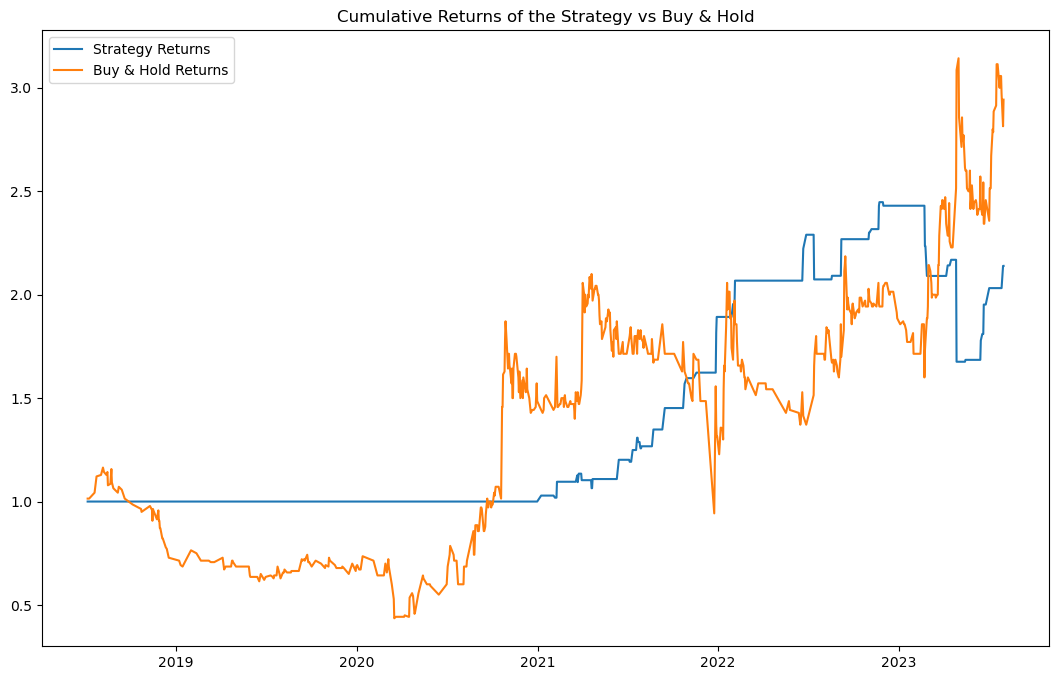

[*********************100%***********************]  1 of 1 completed
             Open   High    Low  Close  Adj Close     Volume
Date                                                        
2018-07-02  2.842  2.842  2.842  2.842      2.842   6244.832
2018-07-03  2.842  2.842  2.842  2.842      2.842  20607.946
2018-07-04  2.842  2.842  2.842  2.842      2.842   2497.933
2018-07-06  2.842  2.842  2.842  2.842      2.842  45712.170
2018-07-10  2.850  2.850  2.842  2.842      2.842   9492.145
...           ...    ...    ...    ...        ...        ...
2023-07-26  2.240  2.240  2.210  2.210      2.210  37800.000
2023-07-27  2.210  2.210  2.200  2.200      2.200  37400.000
2023-07-28  2.200  2.200  2.200  2.200      2.200  36000.000
2023-07-31  2.160  2.190  2.160  2.190      2.190  24000.000
2023-08-01  2.150  2.160  2.150  2.160      2.160   1600.000

[1060 rows x 6 columns]
             Open   High    Low  Close  Adj Close     Volume    SMA  \
Date                                      

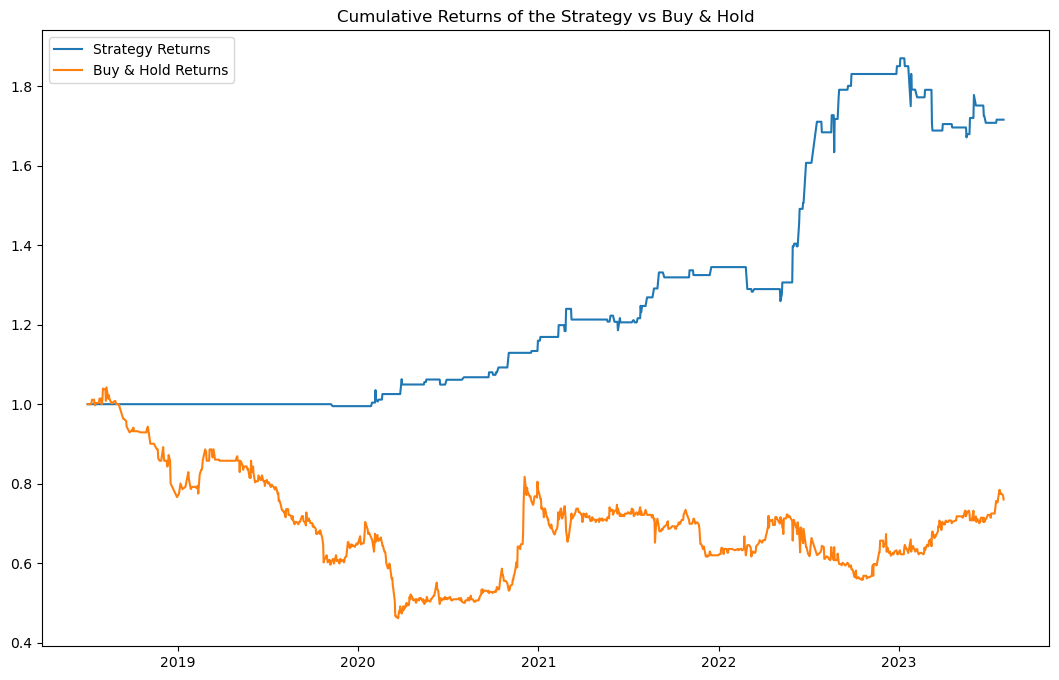

[*********************100%***********************]  1 of 1 completed
             Open   High    Low  Close  Adj Close     Volume
Date                                                        
2018-07-02  0.668  0.716  0.668  0.716      0.716  8.465e+04
2018-07-03  0.716  0.716  0.716  0.716      0.716  4.610e+04
2018-07-04  0.716  0.764  0.716  0.716      0.716  1.020e+05
2018-07-05  0.716  0.716  0.668  0.716      0.716  2.650e+04
2018-07-09  0.668  0.716  0.668  0.716      0.716  8.769e+04
...           ...    ...    ...    ...        ...        ...
2023-07-26  0.195  0.200  0.195  0.195      0.195  5.110e+05
2023-07-27  0.195  0.200  0.195  0.195      0.195  1.762e+06
2023-07-28  0.200  0.200  0.195  0.200      0.200  7.975e+05
2023-07-31  0.195  0.200  0.195  0.200      0.200  5.545e+05
2023-08-01  0.200  0.200  0.195  0.195      0.195  1.009e+05

[699 rows x 6 columns]
             Open   High    Low  Close  Adj Close     Volume    SMA  \
Date                                       

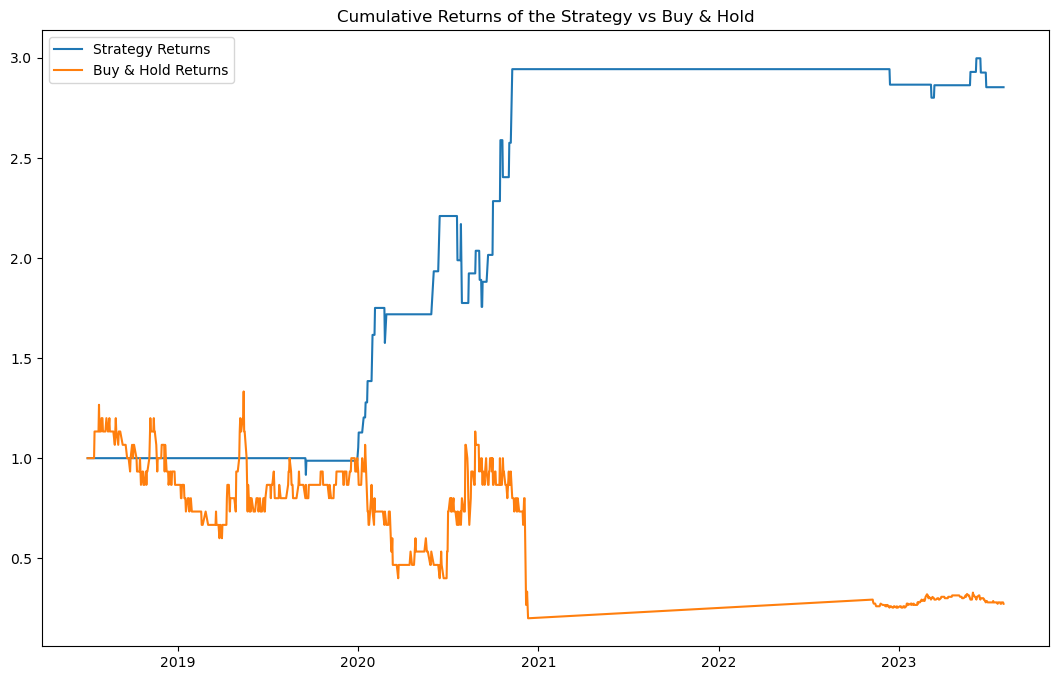

[*********************100%***********************]  1 of 1 completed
              Open    High     Low   Close  Adj Close      Volume
Date                                                             
2018-07-02  21.419  21.735  21.419  21.647     21.647  353378.189
2018-07-03  21.472  21.665  21.437  21.647     21.647  520653.754
2018-07-04  21.647  21.665  21.419  21.647     21.647  457098.168
2018-07-05  21.612  21.787  21.577  21.735     21.735  496007.370
2018-07-06  21.717  21.910  21.700  21.735     21.735  802945.449
...            ...     ...     ...     ...        ...         ...
2023-07-26  22.280  22.800  22.280  22.660     22.660  158200.000
2023-07-27  22.220  23.080  22.220  22.780     22.780  189200.000
2023-07-28  22.740  22.960  22.440  22.960     22.960  318600.000
2023-07-31  22.880  23.000  22.660  22.960     22.960  809600.000
2023-08-01  22.960  23.100  22.900  22.960     22.960    9400.000

[1239 rows x 6 columns]
              Open    High     Low   Close  Adj 

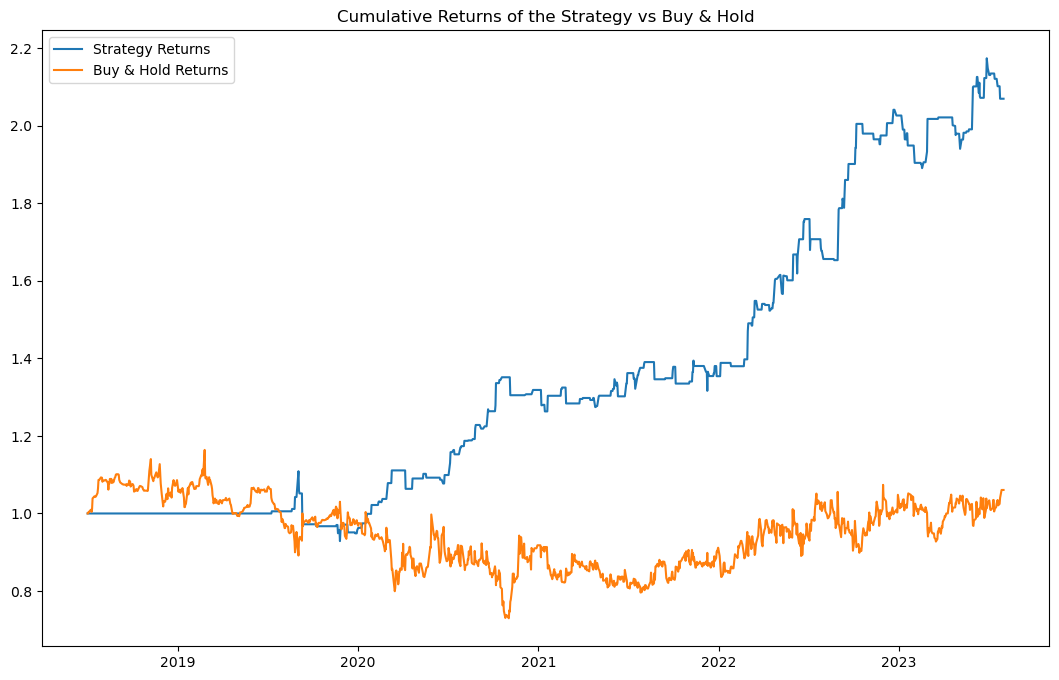

[*********************100%***********************]  1 of 1 completed
             Open   High    Low  Close  Adj Close   Volume
Date                                                      
2018-07-19  0.450  0.450  0.450  0.450      0.450    500.0
2018-07-23  0.390  0.450  0.390  0.410      0.410  35700.0
2018-07-24  0.410  0.410  0.390  0.390      0.390   1200.0
2018-10-15  0.310  0.310  0.310  0.310      0.310   3000.0
2018-10-16  0.310  0.310  0.310  0.310      0.310   9400.0
...           ...    ...    ...    ...        ...      ...
2023-07-21  0.810  0.810  0.805  0.805      0.805  10000.0
2023-07-24  0.855  0.880  0.805  0.830      0.830  24200.0
2023-07-25  0.835  0.835  0.835  0.835      0.835   5000.0
2023-07-26  0.845  0.845  0.845  0.845      0.845   5000.0
2023-07-31  0.845  0.845  0.840  0.840      0.840  10000.0

[580 rows x 6 columns]
             Open   High    Low  Close  Adj Close   Volume    SMA  PremDisc%  \
Date                                                        

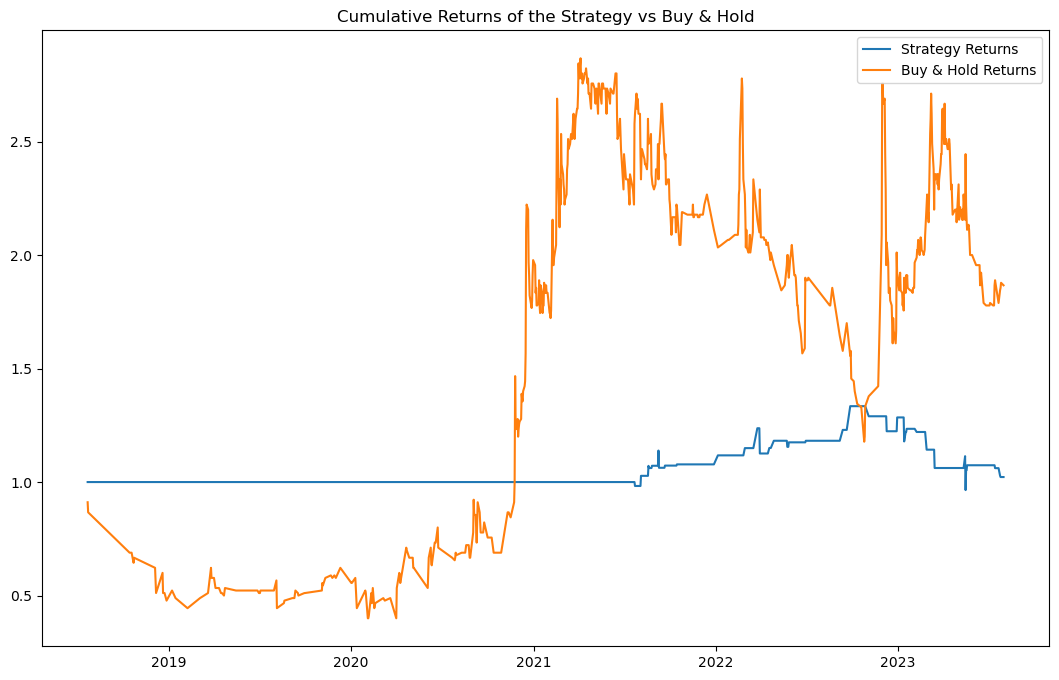

[*********************100%***********************]  1 of 1 completed
             Open   High    Low  Close  Adj Close     Volume
Date                                                        
2018-07-02  4.721  4.738  4.703  4.729      4.729  3.207e+06
2018-07-03  4.729  4.747  4.721  4.738      4.738  1.427e+06
2018-07-04  4.729  4.747  4.721  4.747      4.747  5.875e+05
2018-07-05  4.738  4.747  4.729  4.747      4.747  3.656e+06
2018-07-06  4.676  4.747  4.614  4.667      4.667  7.925e+06
...           ...    ...    ...    ...        ...        ...
2023-07-26  4.590  4.660  4.570  4.610      4.610  3.490e+06
2023-07-27  4.600  4.670  4.570  4.600      4.600  2.990e+06
2023-07-28  4.590  4.600  4.540  4.550      4.550  2.960e+06
2023-07-31  4.610  4.610  4.500  4.550      4.550  5.495e+06
2023-08-01  4.480  4.570  4.480  4.570      4.570  3.250e+05

[1240 rows x 6 columns]
             Open   High    Low  Close  Adj Close     Volume    SMA  \
Date                                      

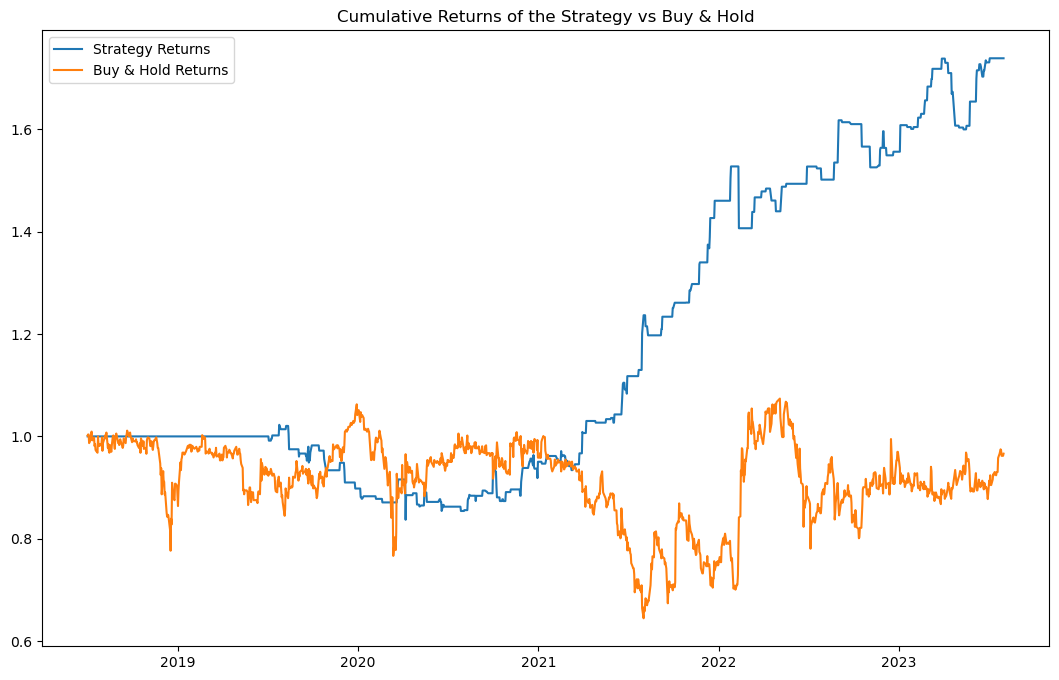

[*********************100%***********************]  1 of 1 completed
             Open   High    Low  Close  Adj Close     Volume
Date                                                        
2018-07-02  1.460  1.468  1.428  1.428      1.428  3.339e+06
2018-07-03  1.428  1.452  1.403  1.428      1.428  4.178e+06
2018-07-04  1.428  1.452  1.411  1.428      1.428  4.446e+06
2018-07-05  1.436  1.452  1.428  1.444      1.444  2.263e+06
2018-07-06  1.452  1.452  1.428  1.428      1.428  4.980e+06
...           ...    ...    ...    ...        ...        ...
2023-07-26  1.500  1.520  1.480  1.490      1.490  5.522e+06
2023-07-27  1.500  1.540  1.500  1.530      1.530  6.857e+06
2023-07-28  1.530  1.540  1.490  1.500      1.500  4.313e+06
2023-07-31  1.500  1.540  1.500  1.530      1.530  9.778e+06
2023-08-01  1.530  1.530  1.510  1.520      1.520  8.654e+05

[1238 rows x 6 columns]
             Open   High    Low  Close  Adj Close     Volume    SMA  \
Date                                      

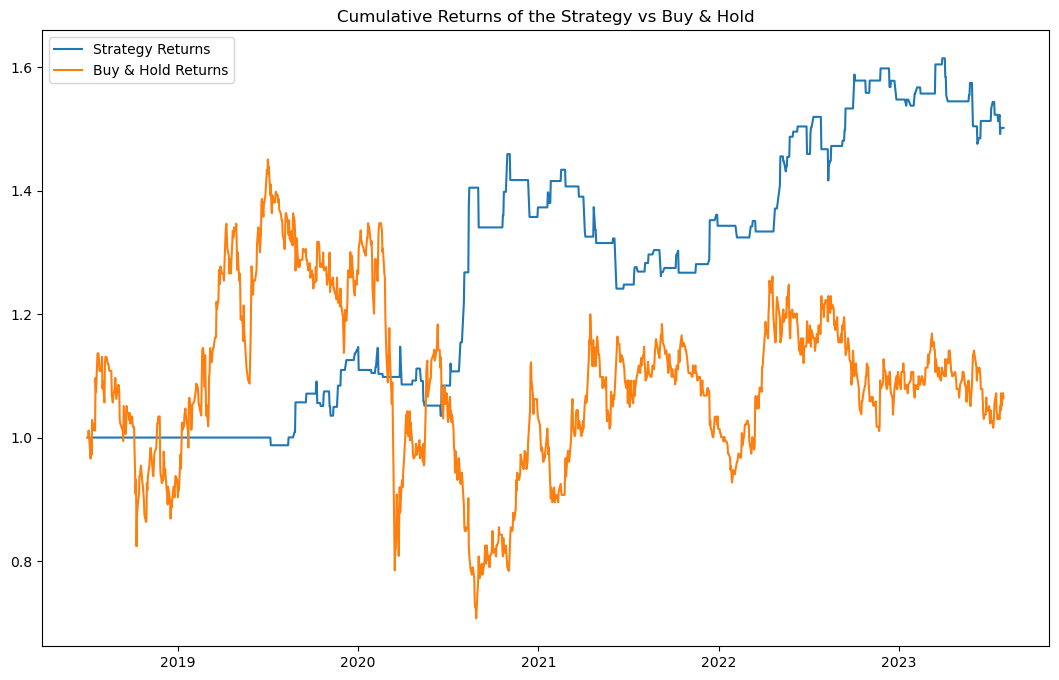

[*********************100%***********************]  1 of 1 completed
             Open   High    Low  Close  Adj Close     Volume
Date                                                        
2018-07-03  0.641  0.656  0.641  0.656      0.656   7121.263
2018-07-05  0.645  0.645  0.641  0.641      0.641  51790.996
2018-07-06  0.695  0.695  0.695  0.695      0.695    258.955
2018-07-12  0.649  0.687  0.645  0.687      0.687   2977.982
2018-07-13  0.684  0.684  0.684  0.684      0.684   2977.982
...           ...    ...    ...    ...        ...        ...
2023-07-25  0.470  0.470  0.465  0.465      0.465  19600.000
2023-07-26  0.455  0.470  0.455  0.460      0.460  16600.000
2023-07-27  0.470  0.470  0.455  0.455      0.455  26200.000
2023-07-28  0.470  0.480  0.470  0.480      0.480   2600.000
2023-07-31  0.475  0.475  0.460  0.470      0.470   9900.000

[1098 rows x 6 columns]
             Open   High    Low  Close  Adj Close     Volume    SMA  \
Date                                      

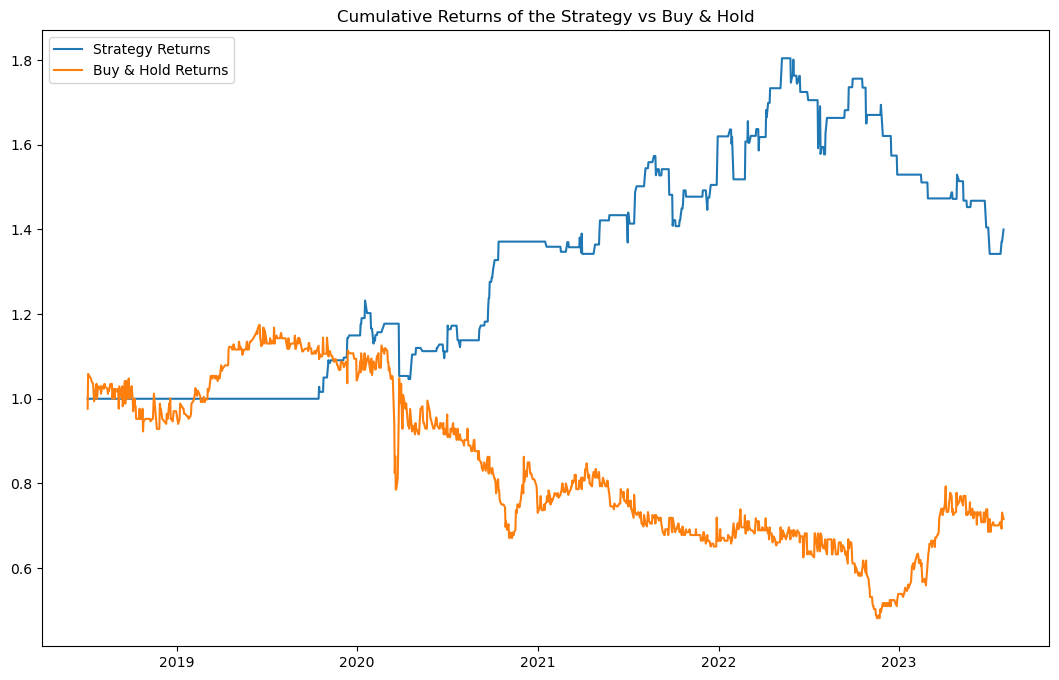

[*********************100%***********************]  1 of 1 completed
             Open   High    Low  Close  Adj Close     Volume
Date                                                        
2018-07-02  0.405  0.405  0.400  0.400      0.400  1.400e+04
2018-07-03  0.375  0.405  0.375  0.405      0.405  3.700e+04
2018-07-04  0.405  0.405  0.405  0.405      0.405  7.000e+03
2018-07-09  0.395  0.395  0.385  0.395      0.395  7.100e+05
2018-07-10  0.405  0.405  0.385  0.395      0.395  2.380e+04
...           ...    ...    ...    ...        ...        ...
2023-07-26  0.510  0.515  0.495  0.510      0.510  4.050e+06
2023-07-27  0.510  0.525  0.510  0.520      0.520  2.641e+06
2023-07-28  0.525  0.545  0.520  0.535      0.535  5.040e+06
2023-07-31  0.540  0.570  0.540  0.570      0.570  4.479e+06
2023-08-01  0.575  0.585  0.540  0.545      0.545  6.558e+06

[1029 rows x 6 columns]
             Open   High    Low  Close  Adj Close     Volume    SMA  \
Date                                      

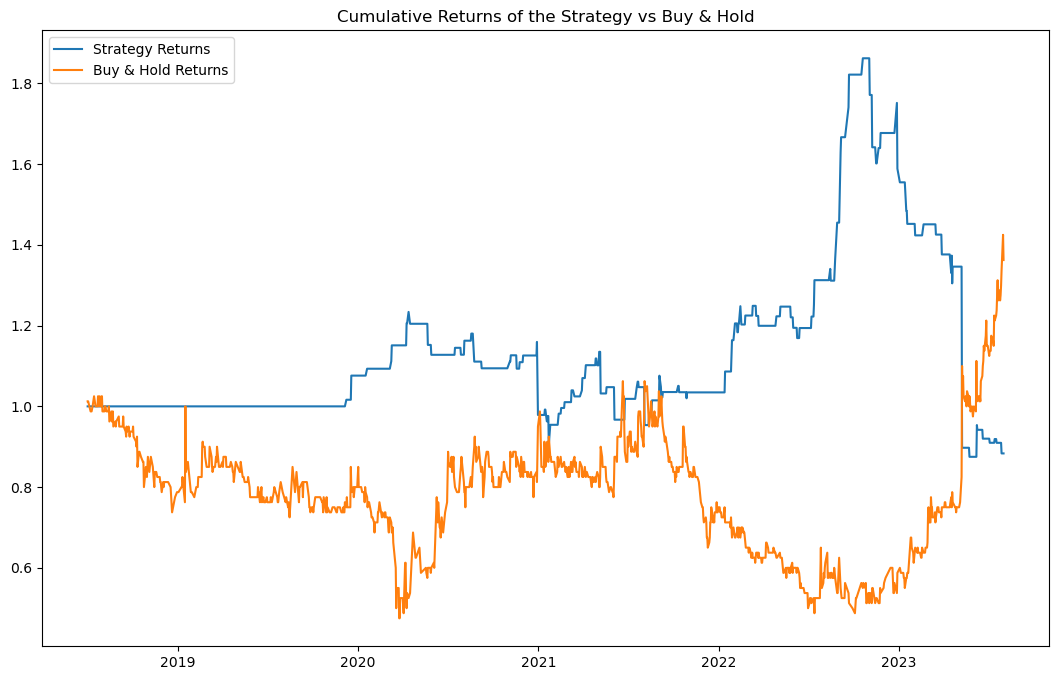

[*********************100%***********************]  1 of 1 completed
             Open   High    Low  Close  Adj Close     Volume
Date                                                        
2018-07-02  0.803  0.803  0.803  0.803      0.803  1.992e+04
2018-07-03  0.838  0.838  0.821  0.821      0.821  3.481e+04
2018-07-05  0.856  0.856  0.856  0.856      0.856  1.969e+04
2018-07-06  0.825  0.825  0.825  0.825      0.825  1.030e+04
2018-07-12  0.856  0.856  0.852  0.856      0.856  1.683e+04
...           ...    ...    ...    ...        ...        ...
2023-07-25  1.160  1.160  1.160  1.160      1.160  6.000e+03
2023-07-26  1.170  1.220  1.170  1.220      1.220  1.024e+07
2023-07-27  1.210  1.210  1.160  1.160      1.160  2.400e+03
2023-07-28  1.200  1.200  1.170  1.170      1.170  2.037e+05
2023-07-31  1.190  1.190  1.160  1.160      1.160  4.300e+04

[802 rows x 6 columns]
             Open   High    Low  Close  Adj Close     Volume    SMA  \
Date                                       

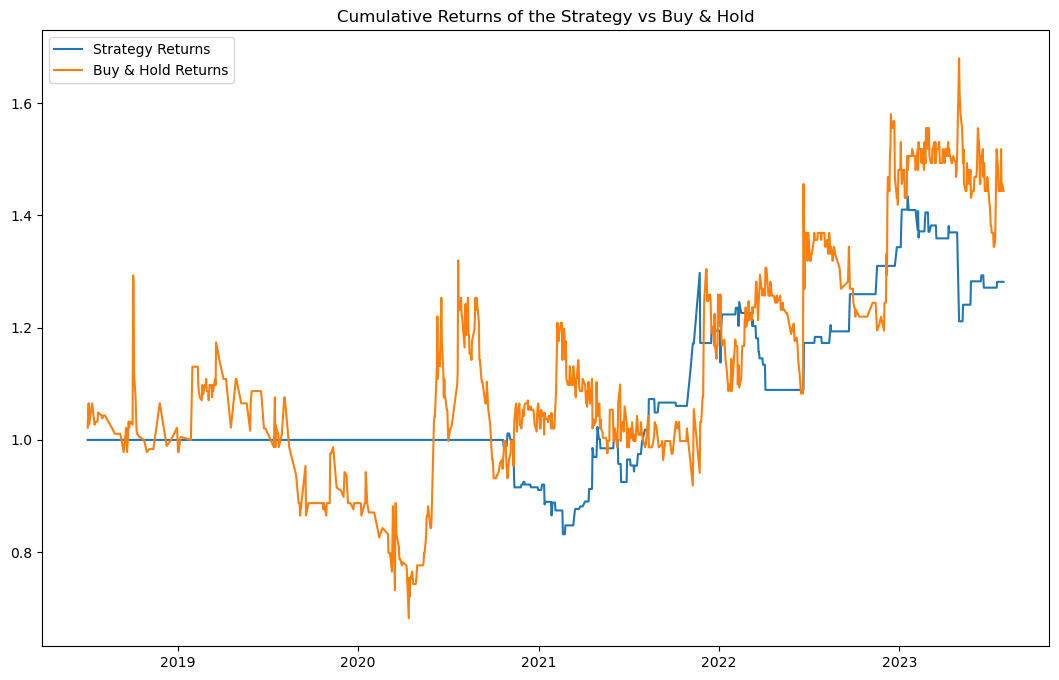

[*********************100%***********************]  1 of 1 completed
             Open   High    Low  Close  Adj Close     Volume
Date                                                        
2018-07-02  0.525  0.525  0.520  0.520      0.520  5.836e+05
2018-07-03  0.520  0.525  0.520  0.520      0.520  3.327e+05
2018-07-04  0.525  0.525  0.520  0.525      0.525  2.332e+05
2018-07-05  0.525  0.530  0.520  0.530      0.530  4.320e+05
2018-07-06  0.525  0.530  0.525  0.530      0.530  2.224e+05
...           ...    ...    ...    ...        ...        ...
2023-07-26  0.390  0.415  0.390  0.405      0.405  1.411e+07
2023-07-27  0.410  0.460  0.405  0.435      0.435  3.318e+07
2023-07-28  0.430  0.455  0.425  0.445      0.445  1.639e+07
2023-07-31  0.445  0.450  0.425  0.430      0.430  6.959e+06
2023-08-01  0.430  0.430  0.420  0.425      0.425  1.143e+06

[1239 rows x 6 columns]
             Open   High    Low  Close  Adj Close     Volume    SMA  \
Date                                      

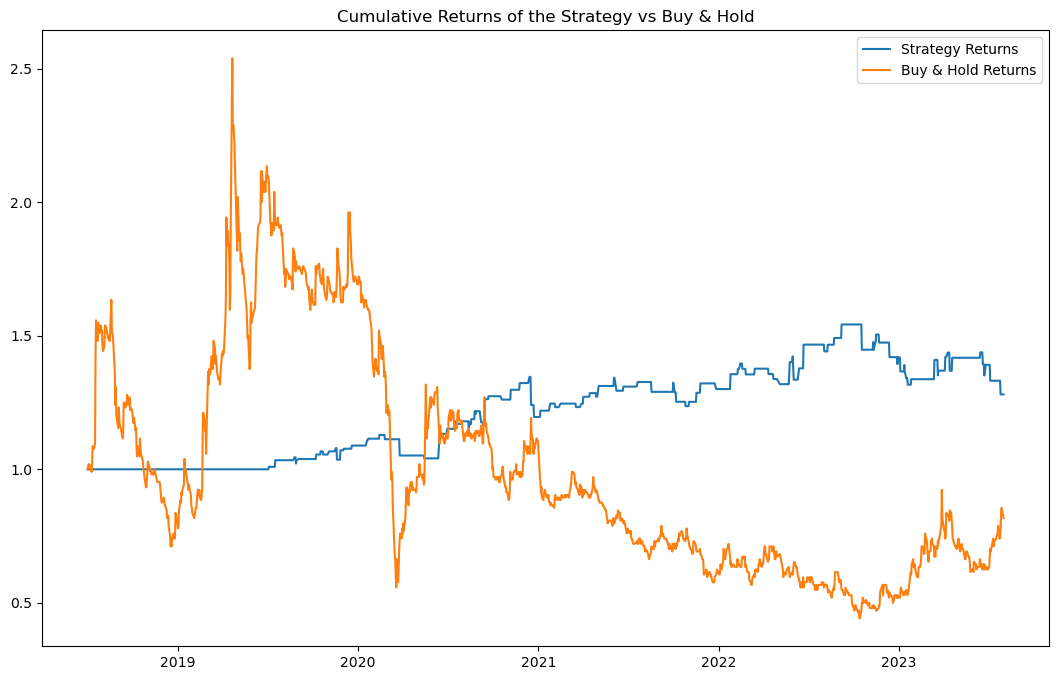

[*********************100%***********************]  1 of 1 completed
             Open   High    Low  Close  Adj Close     Volume
Date                                                        
2018-07-02  0.874  0.883  0.865  0.874      0.874  2.015e+06
2018-07-03  0.869  0.874  0.865  0.865      0.865  2.793e+05
2018-07-04  0.865  0.883  0.860  0.865      0.865  3.599e+06
2018-07-05  0.865  0.865  0.855  0.865      0.865  6.928e+05
2018-07-06  0.855  0.869  0.855  0.869      0.869  9.684e+05
...           ...    ...    ...    ...        ...        ...
2023-07-26  0.300  0.300  0.295  0.300      0.300  9.821e+05
2023-07-27  0.300  0.300  0.285  0.295      0.295  2.939e+06
2023-07-28  0.290  0.295  0.290  0.290      0.290  6.232e+05
2023-07-31  0.290  0.295  0.285  0.290      0.290  7.419e+05
2023-08-01  0.290  0.290  0.285  0.290      0.290  2.050e+05

[1239 rows x 6 columns]
             Open   High    Low  Close  Adj Close     Volume    SMA  \
Date                                      

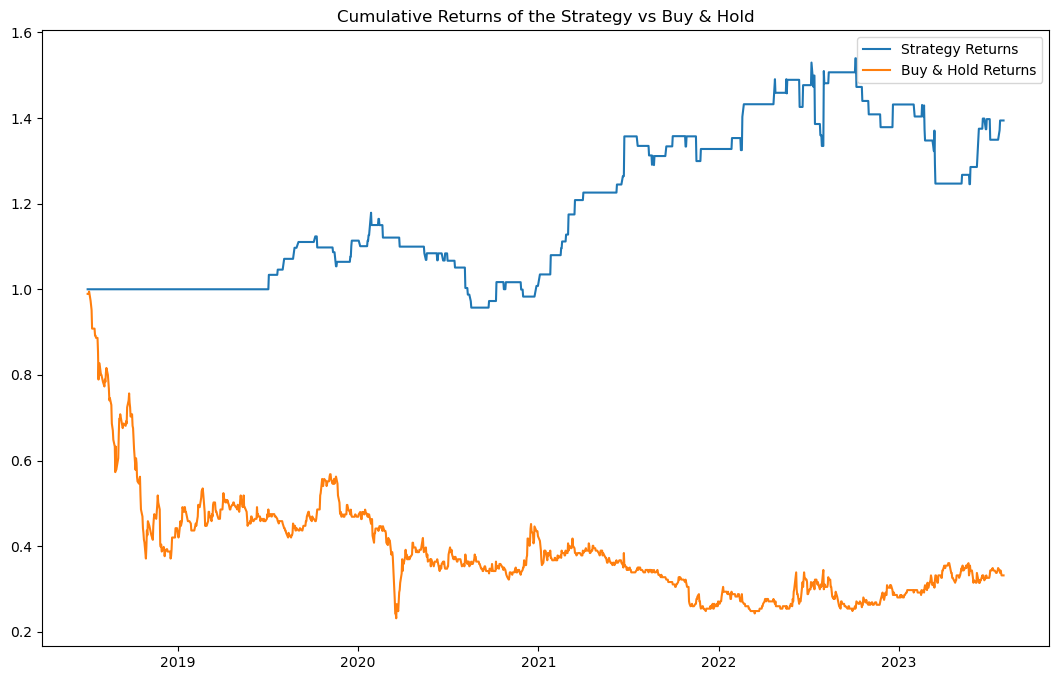

[*********************100%***********************]  1 of 1 completed
              Open    High     Low   Close  Adj Close      Volume
Date                                                             
2018-07-02  10.444  10.444  10.282  10.282     10.282   66716.490
2018-07-03  10.152  10.169  10.120  10.136     10.136   64373.400
2018-07-04  10.055  10.298   9.877  10.298     10.298   30460.207
2018-07-05   9.974  10.055   9.974  10.055     10.055    2959.696
2018-07-06   9.990   9.990   9.974   9.974      9.974    4562.866
...            ...     ...     ...     ...        ...         ...
2023-07-26  14.320  14.320  14.300  14.300     14.300   91700.000
2023-07-27  14.280  14.420  14.200  14.300     14.300  154500.000
2023-07-28  14.300  14.540  14.300  14.480     14.480   26300.000
2023-07-31  14.540  14.740  14.540  14.580     14.580   22000.000
2023-08-01  14.600  14.600  14.600  14.600     14.600     700.000

[1228 rows x 6 columns]
              Open    High     Low   Close  Adj 

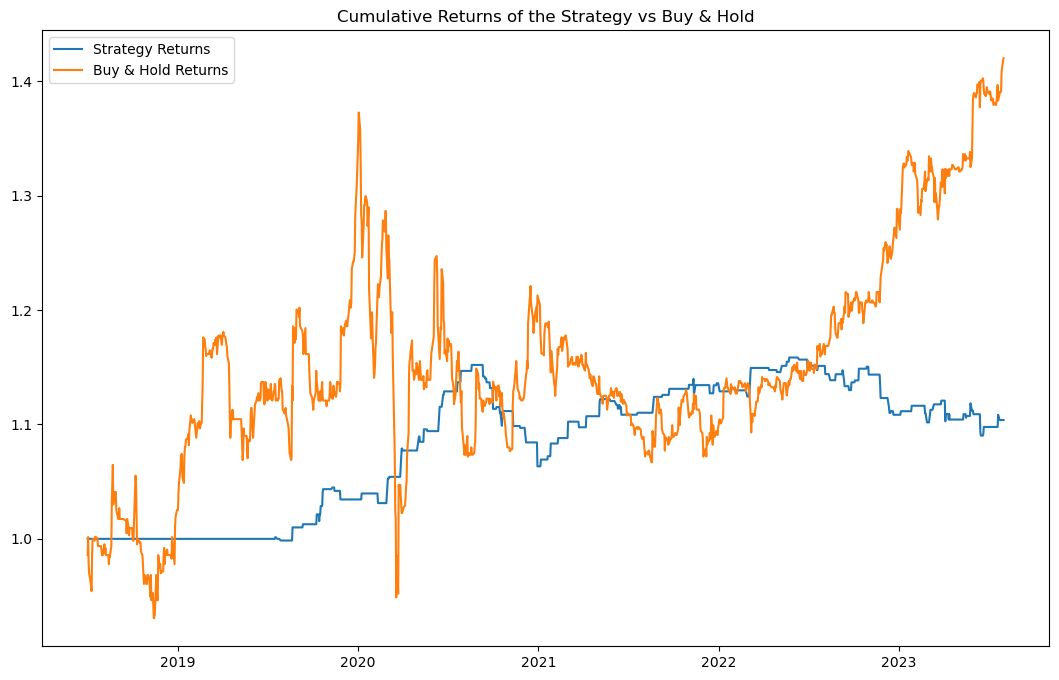

[*********************100%***********************]  1 of 1 completed
             Open   High    Low  Close  Adj Close     Volume
Date                                                        
2018-07-02  1.609  1.609  1.609  1.609      1.609    185.463
2018-07-03  1.582  1.582  1.566  1.572      1.572  26100.528
2018-07-04  1.566  1.566  1.566  1.566      1.566  52759.867
2018-07-06  1.566  1.566  1.566  1.566      1.566   5592.970
2018-07-18  1.550  1.550  1.550  1.550      1.550  29829.178
...           ...    ...    ...    ...        ...        ...
2023-07-25  2.130  2.140  2.120  2.140      2.140  12400.000
2023-07-26  2.110  2.110  2.110  2.110      2.110   9300.000
2023-07-27  2.150  2.150  2.130  2.130      2.130    200.000
2023-07-28  2.120  2.120  2.110  2.110      2.110   5500.000
2023-07-31  2.110  2.110  2.110  2.110      2.110  10300.000

[1069 rows x 6 columns]
             Open   High    Low  Close  Adj Close     Volume    SMA  \
Date                                      

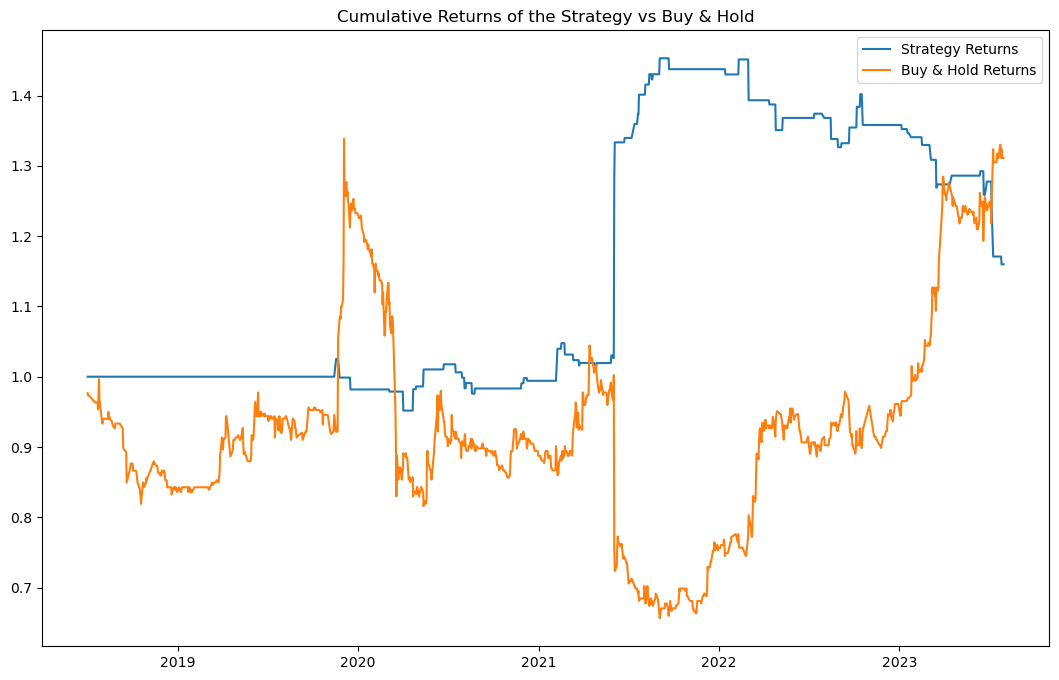

[*********************100%***********************]  1 of 1 completed
             Open   High    Low  Close  Adj Close     Volume
Date                                                        
2018-07-02  0.515  0.525  0.515  0.525      0.525  4.000e+04
2018-07-03  0.520  0.530  0.510  0.510      0.510  1.140e+05
2018-07-04  0.500  0.500  0.495  0.495      0.495  5.900e+04
2018-07-06  0.515  0.520  0.515  0.520      0.520  2.500e+04
2018-07-10  0.520  0.525  0.520  0.525      0.525  3.600e+04
...           ...    ...    ...    ...        ...        ...
2023-07-26  0.185  0.185  0.175  0.175      0.175  1.089e+07
2023-07-27  0.175  0.180  0.170  0.175      0.175  1.853e+07
2023-07-28  0.175  0.180  0.175  0.180      0.180  3.422e+06
2023-07-31  0.180  0.180  0.175  0.175      0.175  3.783e+06
2023-08-01  0.175  0.175  0.175  0.175      0.175  2.695e+06

[766 rows x 6 columns]
             Open   High    Low  Close  Adj Close     Volume    SMA  \
Date                                       

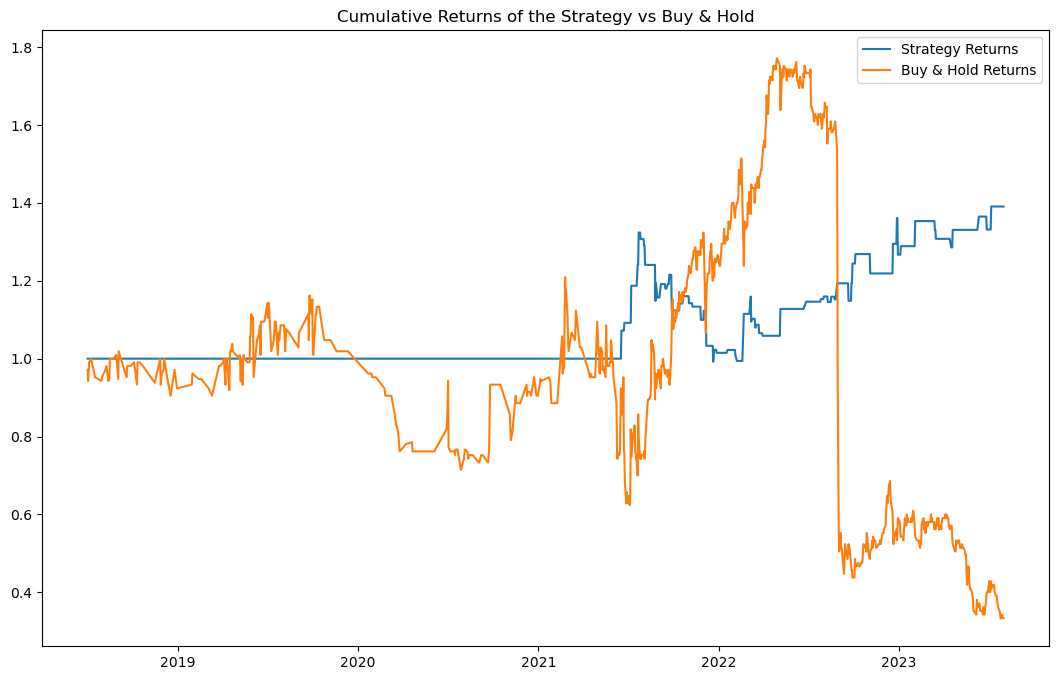

[*********************100%***********************]  1 of 1 completed
             Open   High    Low  Close  Adj Close     Volume
Date                                                        
2018-07-02  1.220  1.228  1.213  1.228      1.228  2.080e+05
2018-07-03  1.205  1.260  1.205  1.260      1.260  5.042e+05
2018-07-04  1.252  1.252  1.228  1.236      1.236  4.889e+04
2018-07-05  1.228  1.244  1.228  1.236      1.236  8.407e+04
2018-07-06  1.228  1.228  1.220  1.220      1.220  1.970e+05
...           ...    ...    ...    ...        ...        ...
2023-07-26  0.260  0.290  0.255  0.270      0.270  2.815e+07
2023-07-27  0.270  0.280  0.265  0.270      0.270  6.512e+06
2023-07-28  0.270  0.270  0.255  0.260      0.260  5.589e+06
2023-07-31  0.260  0.265  0.240  0.250      0.250  2.055e+07
2023-08-01  0.250  0.265  0.250  0.260      0.260  2.604e+06

[1240 rows x 6 columns]
             Open   High    Low  Close  Adj Close     Volume    SMA  \
Date                                      

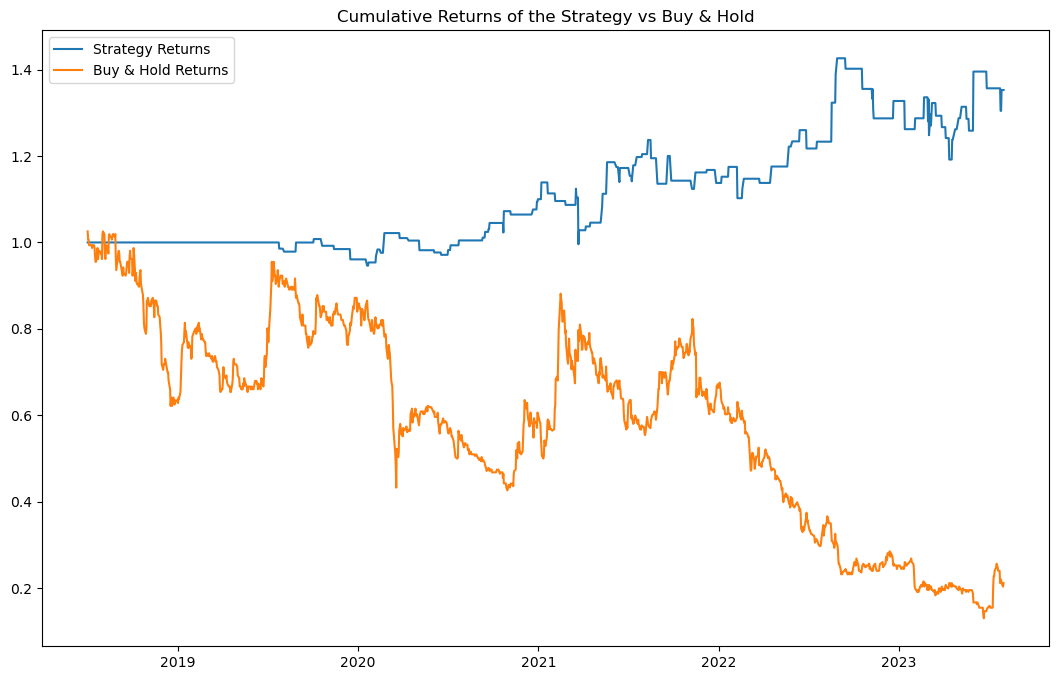

[*********************100%***********************]  1 of 1 completed
             Open   High    Low  Close  Adj Close      Volume
Date                                                         
2018-07-02  0.424  0.424  0.410  0.410      0.410  226703.464
2018-07-04  0.413  0.413  0.413  0.413      0.413     141.513
2018-07-12  0.403  0.420  0.396  0.399      0.399   63822.266
2018-07-13  0.420  0.420  0.399  0.403      0.403   97785.335
2018-07-16  0.403  0.417  0.403  0.417      0.417   15424.893
...           ...    ...    ...    ...        ...         ...
2023-07-26  0.645  0.660  0.645  0.660      0.660  146100.000
2023-07-27  0.660  0.665  0.655  0.655      0.655  107900.000
2023-07-28  0.655  0.665  0.655  0.660      0.660  208000.000
2023-07-31  0.660  0.680  0.660  0.670      0.670  227000.000
2023-08-01  0.670  0.670  0.670  0.670      0.670   83100.000

[1185 rows x 6 columns]
             Open   High    Low  Close  Adj Close      Volume    SMA  \
Date                        

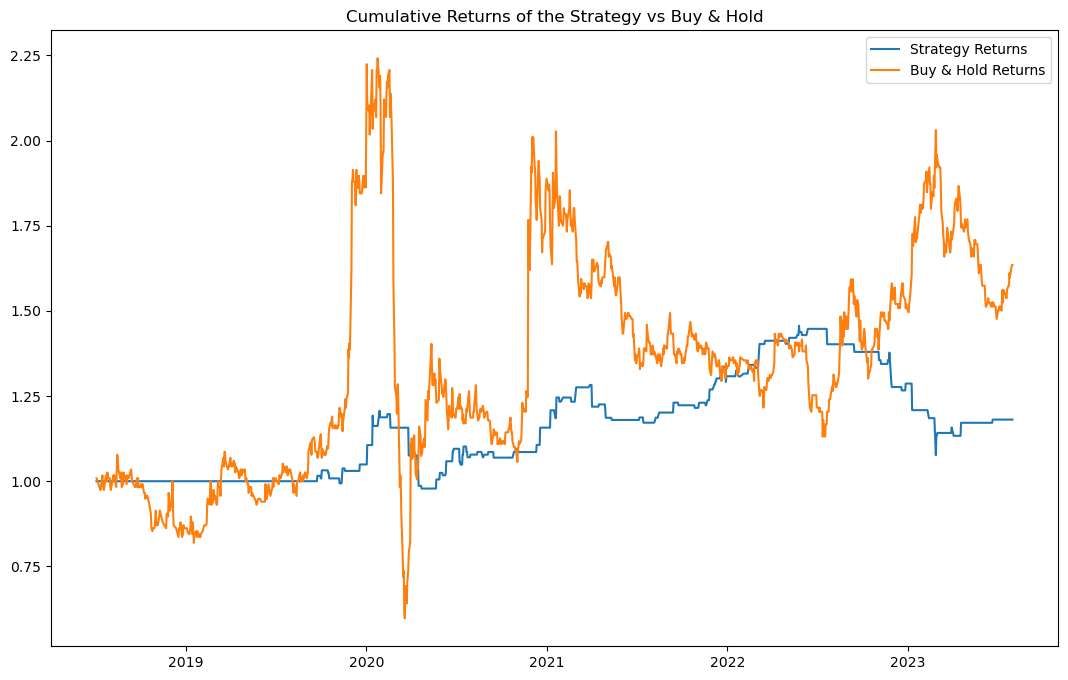

[*********************100%***********************]  1 of 1 completed
             Open   High    Low  Close  Adj Close      Volume
Date                                                         
2018-07-03  1.324  1.324  1.318  1.318      1.318   10472.128
2018-07-04  1.318  1.318  1.318  1.318      1.318    8028.632
2018-07-11  1.306  1.318  1.306  1.318      1.318   20071.579
2018-07-19  1.341  1.341  1.341  1.341      1.341    5934.206
2018-07-20  1.346  1.346  1.324  1.341      1.341   48346.323
...           ...    ...    ...    ...        ...         ...
2023-07-25  1.440  1.450  1.440  1.450      1.450   75000.000
2023-07-26  1.430  1.440  1.420  1.440      1.440  302600.000
2023-07-27  1.440  1.450  1.440  1.440      1.440  325500.000
2023-07-28  1.440  1.450  1.420  1.440      1.440  241800.000
2023-07-31  1.450  1.460  1.440  1.460      1.460   53500.000

[1032 rows x 6 columns]
             Open   High    Low  Close  Adj Close      Volume    SMA  \
Date                        

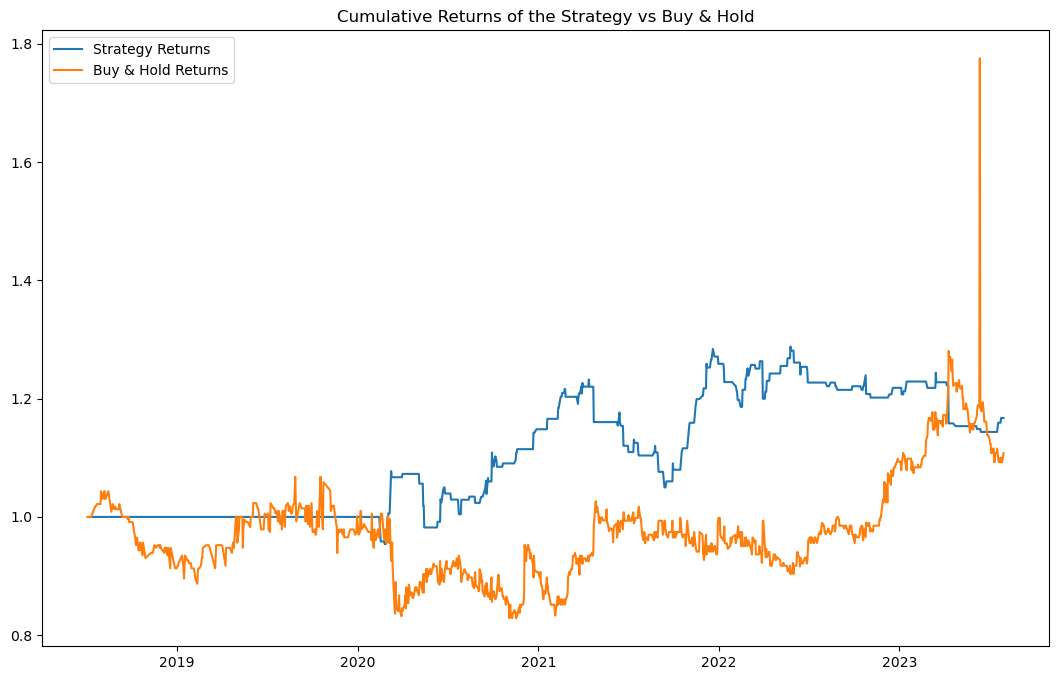

[*********************100%***********************]  1 of 1 completed
             Open   High    Low  Close  Adj Close     Volume
Date                                                        
2018-07-02  4.445  4.528  4.445  4.520      4.520  2.326e+06
2018-07-03  4.536  4.544  4.404  4.453      4.453  1.425e+06
2018-07-04  4.445  4.486  4.420  4.437      4.437  5.759e+05
2018-07-05  4.453  4.486  4.445  4.462      4.462  2.727e+05
2018-07-06  4.445  4.462  4.313  4.313      4.313  1.875e+06
...           ...    ...    ...    ...        ...        ...
2023-07-26  4.030  4.040  3.990  4.010      4.010  4.267e+06
2023-07-27  4.000  4.100  4.000  4.040      4.040  4.561e+06
2023-07-28  4.040  4.050  4.010  4.030      4.030  2.254e+06
2023-07-31  4.040  4.060  4.020  4.040      4.040  5.565e+06
2023-08-01  4.040  4.050  4.030  4.030      4.030  7.340e+04

[1240 rows x 6 columns]
             Open   High    Low  Close  Adj Close     Volume    SMA  \
Date                                      

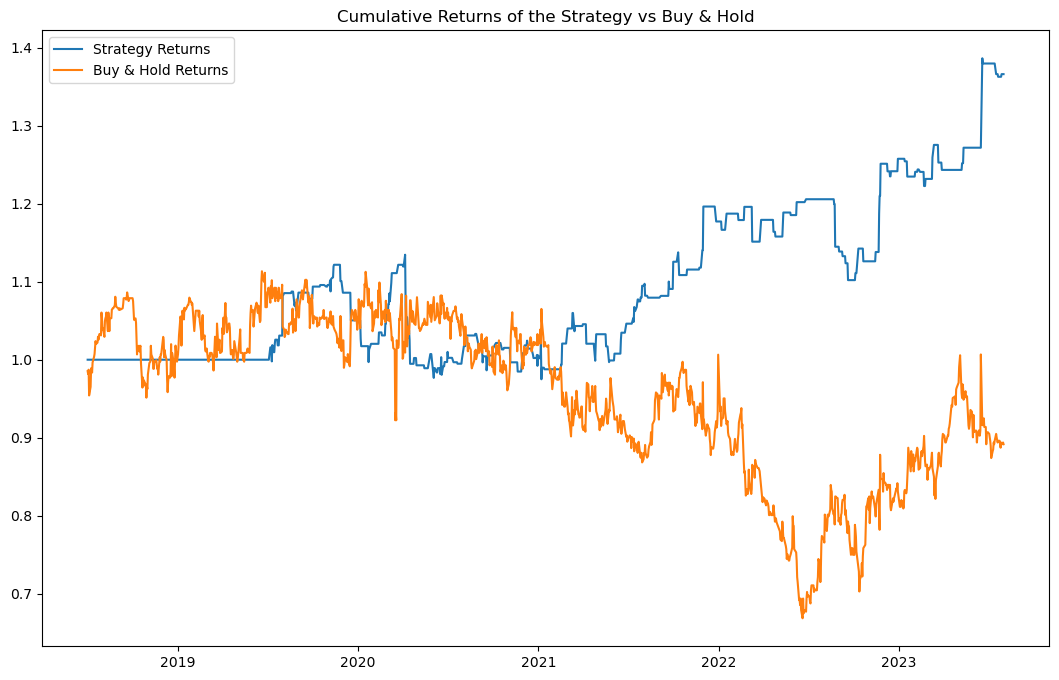

[*********************100%***********************]  1 of 1 completed
             Open   High    Low  Close  Adj Close     Volume
Date                                                        
2018-07-05  0.050  0.053  0.050  0.053      0.053  5.760e+04
2018-07-06  0.048  0.052  0.048  0.052      0.052  3.873e+05
2018-07-16  0.053  0.065  0.053  0.065      0.065  2.727e+05
2018-07-17  0.050  0.050  0.050  0.050      0.050  1.500e+04
2018-07-18  0.050  0.057  0.050  0.057      0.057  1.953e+05
...           ...    ...    ...    ...        ...        ...
2023-07-26  0.083  0.083  0.075  0.075      0.075  5.936e+05
2023-07-27  0.070  0.075  0.065  0.075      0.075  1.504e+06
2023-07-28  0.070  0.070  0.065  0.065      0.065  1.111e+06
2023-07-31  0.065  0.075  0.065  0.075      0.075  1.224e+06
2023-08-01  0.075  0.075  0.075  0.075      0.075  9.000e+04

[722 rows x 6 columns]
             Open   High    Low  Close  Adj Close     Volume    SMA  \
Date                                       

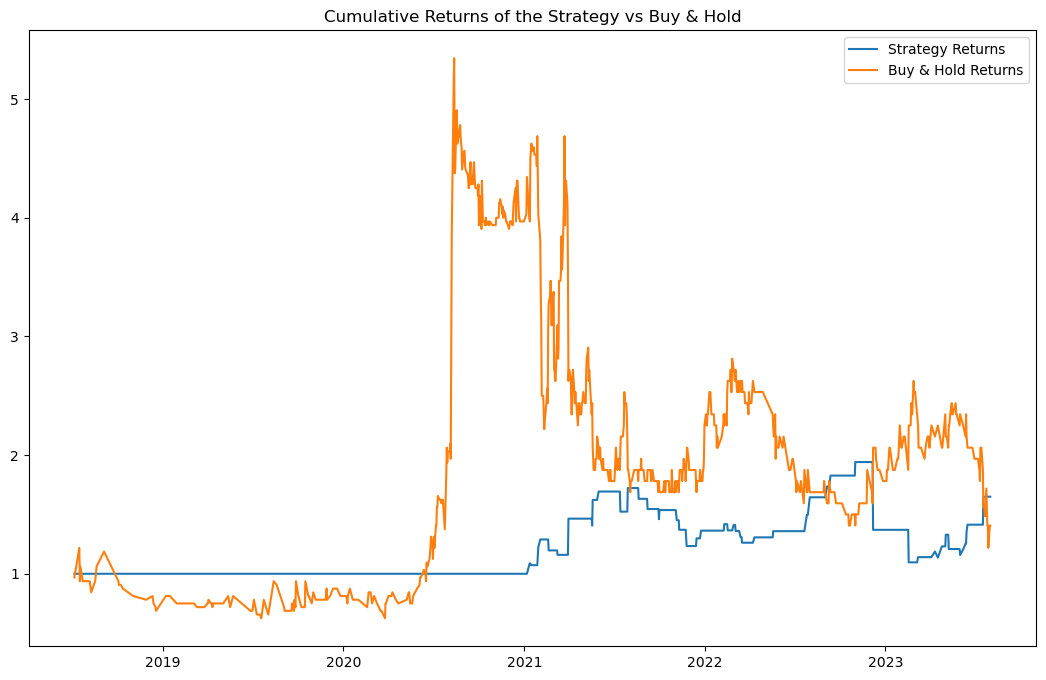

[*********************100%***********************]  1 of 1 completed
             Open   High    Low  Close  Adj Close     Volume
Date                                                        
2018-07-02  6.107  6.123  6.099  6.099      6.099  18320.640
2018-07-03  6.083  6.083  6.083  6.083      6.083   3837.431
2018-07-04  6.083  6.099  6.083  6.083      6.083  32803.849
2018-07-05  6.099  6.099  6.099  6.099      6.099    371.364
2018-07-06  6.083  6.180  6.083  6.083      6.083   7674.863
...           ...    ...    ...    ...        ...        ...
2023-07-26  5.330  5.400  5.330  5.340      5.340   4200.000
2023-07-27  5.360  5.400  5.360  5.400      5.400   2000.000
2023-07-28  5.290  5.380  5.290  5.320      5.320   1600.000
2023-07-31  5.320  5.390  5.320  5.390      5.390  11400.000
2023-08-01  5.390  5.390  5.380  5.380      5.380  34800.000

[1188 rows x 6 columns]
             Open   High    Low  Close  Adj Close     Volume    SMA  \
Date                                      

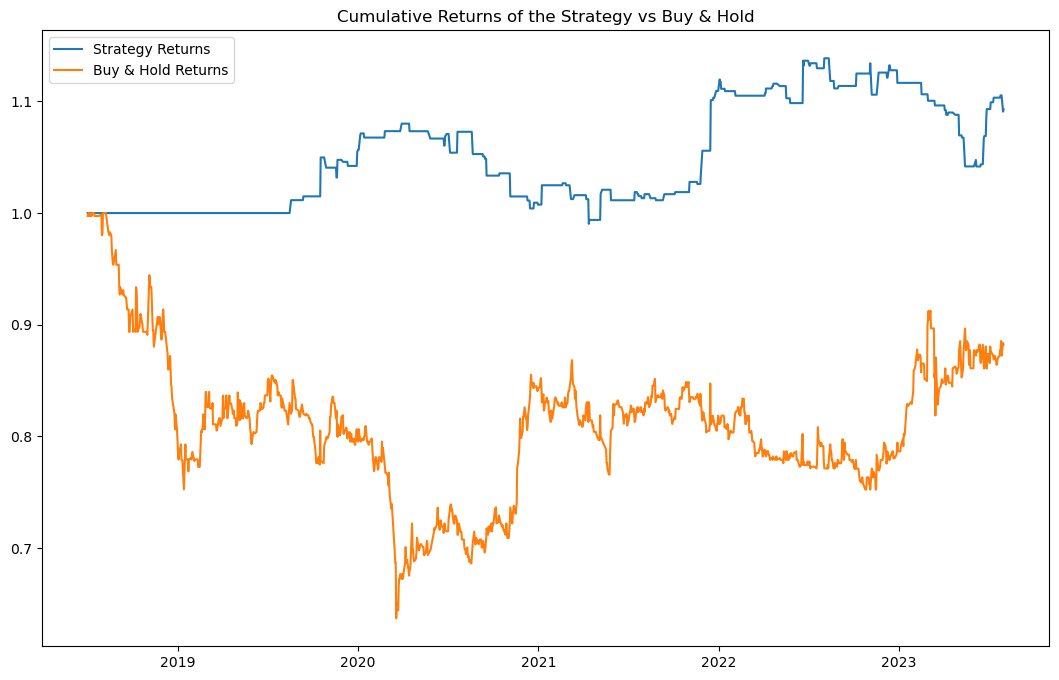

[*********************100%***********************]  1 of 1 completed
             Open   High    Low  Close  Adj Close     Volume
Date                                                        
2018-07-02  0.195  0.200  0.185  0.185      0.185  1.586e+06
2018-07-03  0.185  0.195  0.185  0.190      0.190  1.363e+06
2018-07-04  0.190  0.190  0.185  0.190      0.190  1.253e+06
2018-07-05  0.195  0.225  0.195  0.205      0.205  1.444e+07
2018-07-06  0.205  0.215  0.190  0.200      0.200  6.596e+06
...           ...    ...    ...    ...        ...        ...
2023-07-26  0.175  0.175  0.165  0.170      0.170  3.331e+06
2023-07-27  0.170  0.175  0.170  0.175      0.175  1.092e+06
2023-07-28  0.170  0.170  0.165  0.170      0.170  1.272e+06
2023-07-31  0.170  0.175  0.170  0.170      0.170  3.718e+06
2023-08-01  0.170  0.180  0.170  0.180      0.180  3.061e+06

[1238 rows x 6 columns]
             Open   High    Low  Close  Adj Close     Volume    SMA  \
Date                                      

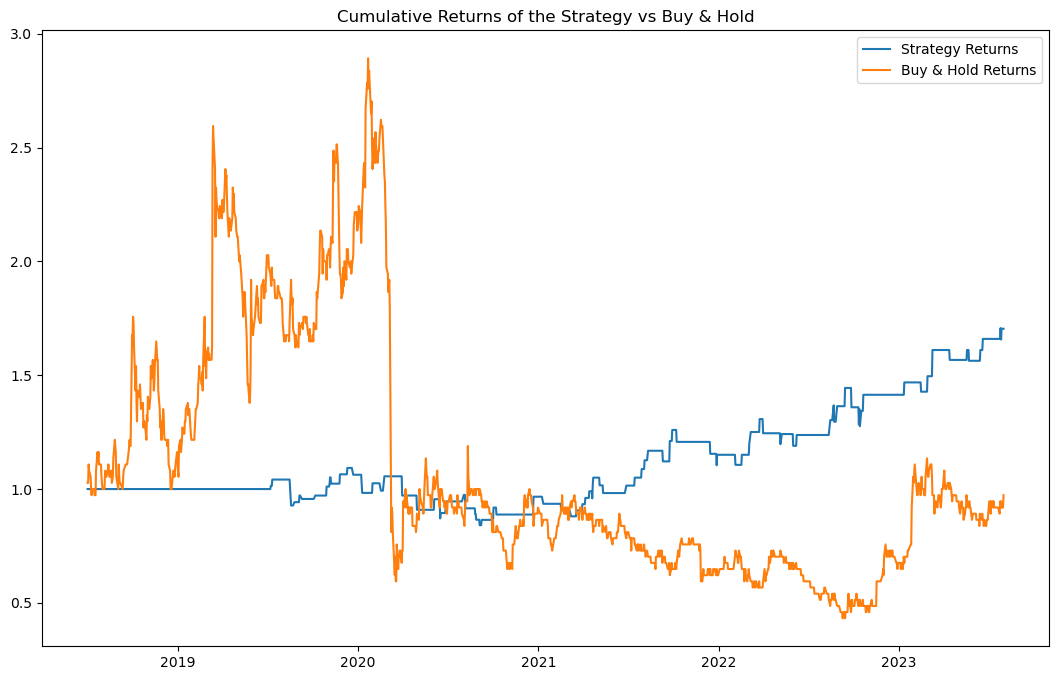

[*********************100%***********************]  1 of 1 completed
             Open   High    Low  Close  Adj Close     Volume
Date                                                        
2018-07-02  0.261  0.261  0.261  0.261      0.261  1.036e+04
2018-07-06  0.270  0.270  0.265  0.265      0.265  1.244e+05
2018-07-19  0.275  0.275  0.275  0.275      0.275  1.606e+04
2018-07-25  0.285  0.289  0.285  0.289      0.289  2.477e+04
2018-08-06  0.270  0.270  0.270  0.270      0.270  8.363e+04
...           ...    ...    ...    ...        ...        ...
2023-07-26  0.405  0.410  0.400  0.405      0.405  4.038e+05
2023-07-27  0.405  0.415  0.405  0.410      0.410  6.988e+05
2023-07-28  0.415  0.440  0.415  0.440      0.440  6.446e+06
2023-07-31  0.455  0.480  0.450  0.475      0.475  7.698e+06
2023-08-01  0.470  0.475  0.450  0.455      0.455  1.644e+06

[796 rows x 6 columns]
             Open   High    Low  Close  Adj Close     Volume    SMA  \
Date                                       

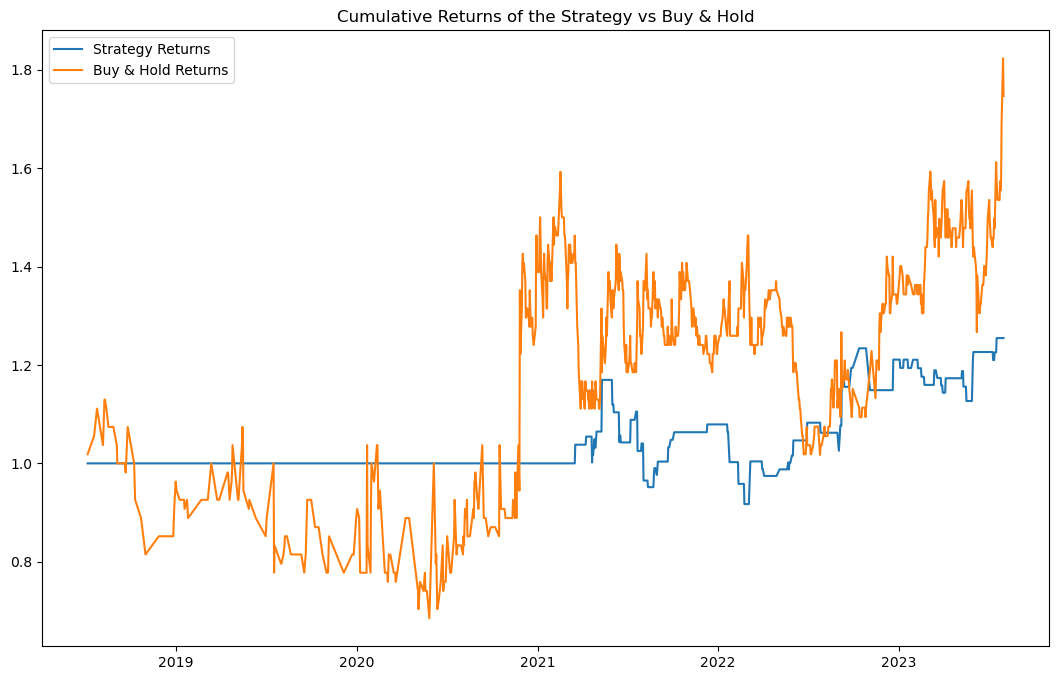

[*********************100%***********************]  1 of 1 completed
             Open   High    Low  Close  Adj Close     Volume
Date                                                        
2018-07-02  0.915  0.967  0.915  0.967      0.967   4167.512
2018-07-03  0.960  0.960  0.960  0.960      0.960   1344.359
2018-07-10  0.907  0.937  0.907  0.937      0.937  82274.774
2018-07-13  0.952  0.952  0.945  0.945      0.945  36969.858
2018-07-16  0.952  0.952  0.915  0.922      0.922   9410.512
...           ...    ...    ...    ...        ...        ...
2023-07-26  1.260  1.260  1.260  1.260      1.260  45100.000
2023-07-27  1.250  1.260  1.250  1.260      1.260  20500.000
2023-07-28  1.250  1.260  1.250  1.260      1.260  39400.000
2023-07-31  1.260  1.260  1.250  1.250      1.250  36900.000
2023-08-01  1.260  1.260  1.260  1.260      1.260   1700.000

[1172 rows x 6 columns]
             Open   High    Low  Close  Adj Close     Volume    SMA  \
Date                                      

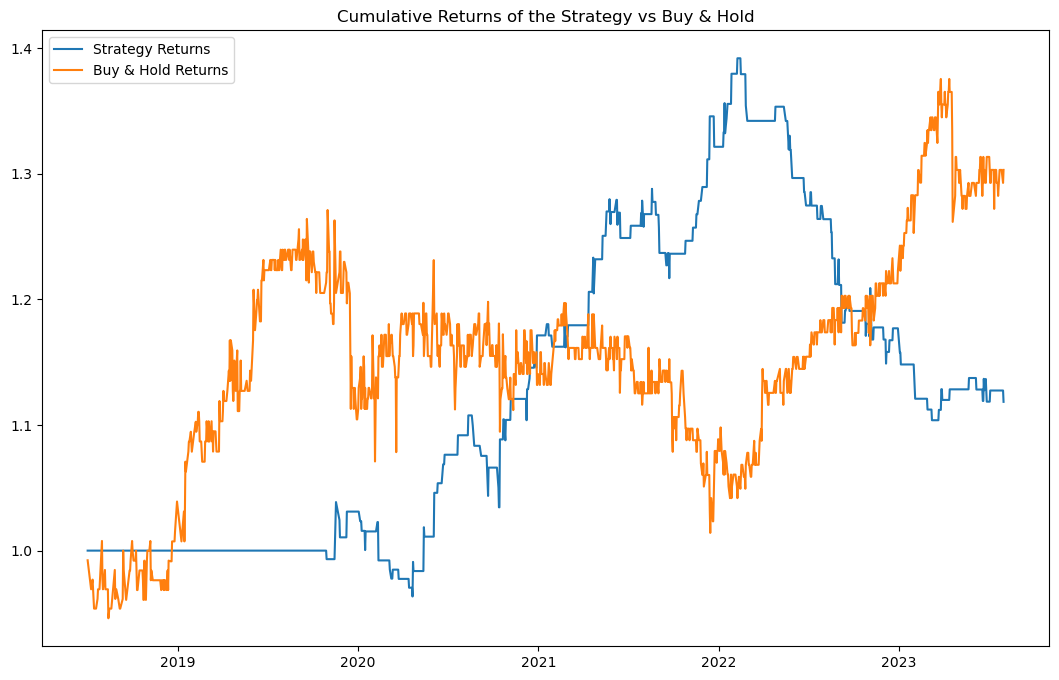

[*********************100%***********************]  1 of 1 completed
             Open   High    Low  Close  Adj Close     Volume
Date                                                        
2018-07-03  0.712  0.712  0.712  0.712      0.712  9.123e+02
2018-07-09  0.707  0.712  0.707  0.712      0.712  1.825e+03
2018-07-17  0.795  0.795  0.712  0.712      0.712  8.211e+03
2018-07-20  0.712  0.712  0.712  0.712      0.712  5.474e+03
2018-08-23  0.767  0.767  0.767  0.767      0.767  1.800e+02
...           ...    ...    ...    ...        ...        ...
2023-07-26  1.780  1.890  1.780  1.890      1.890  1.964e+06
2023-07-27  1.880  1.890  1.840  1.870      1.870  8.984e+05
2023-07-28  1.870  1.910  1.870  1.880      1.880  2.936e+06
2023-07-31  1.880  1.910  1.850  1.890      1.890  2.277e+06
2023-08-01  1.890  1.890  1.860  1.860      1.860  7.190e+05

[697 rows x 6 columns]
             Open   High    Low  Close  Adj Close     Volume    SMA  \
Date                                       

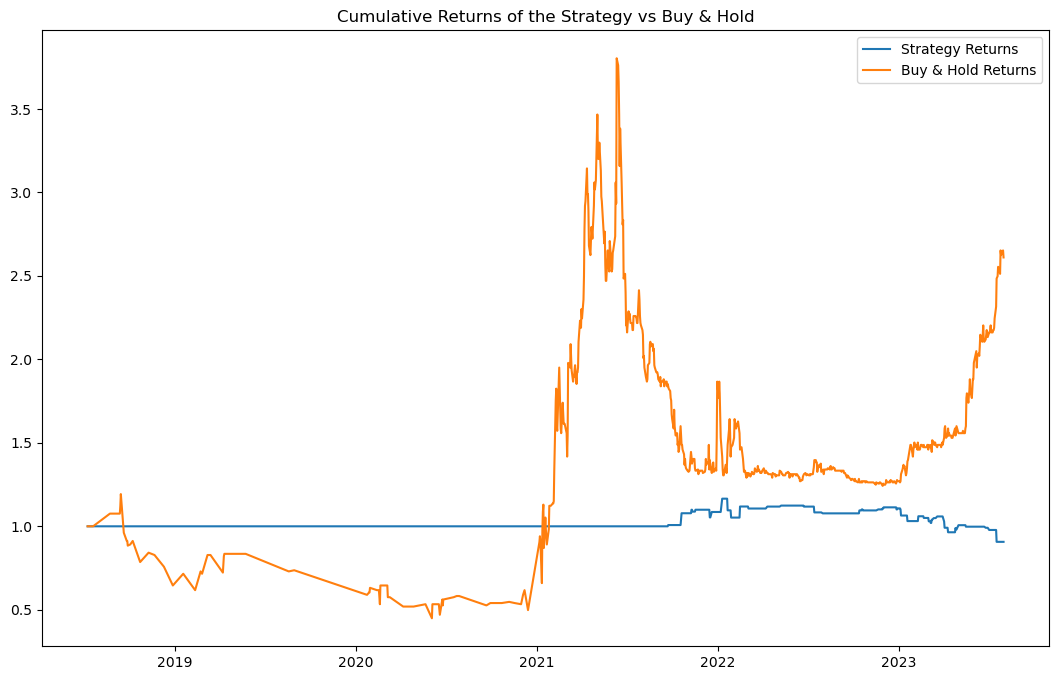

[*********************100%***********************]  1 of 1 completed
             Open   High    Low  Close  Adj Close     Volume
Date                                                        
2018-07-02  0.405  0.405  0.376  0.385      0.385  3.912e+06
2018-07-03  0.390  0.390  0.376  0.376      0.376  3.796e+06
2018-07-04  0.380  0.385  0.361  0.376      0.376  6.188e+06
2018-07-05  0.376  0.376  0.361  0.361      0.361  2.582e+06
2018-07-06  0.361  0.376  0.351  0.376      0.376  4.203e+06
...           ...    ...    ...    ...        ...        ...
2023-07-26  0.470  0.470  0.460  0.460      0.460  7.068e+05
2023-07-27  0.465  0.465  0.455  0.465      0.465  1.986e+06
2023-07-28  0.465  0.480  0.445  0.460      0.460  5.153e+06
2023-07-31  0.460  0.465  0.450  0.460      0.460  1.564e+06
2023-08-01  0.460  0.460  0.455  0.460      0.460  9.830e+04

[1232 rows x 6 columns]
             Open   High    Low  Close  Adj Close     Volume    SMA  \
Date                                      

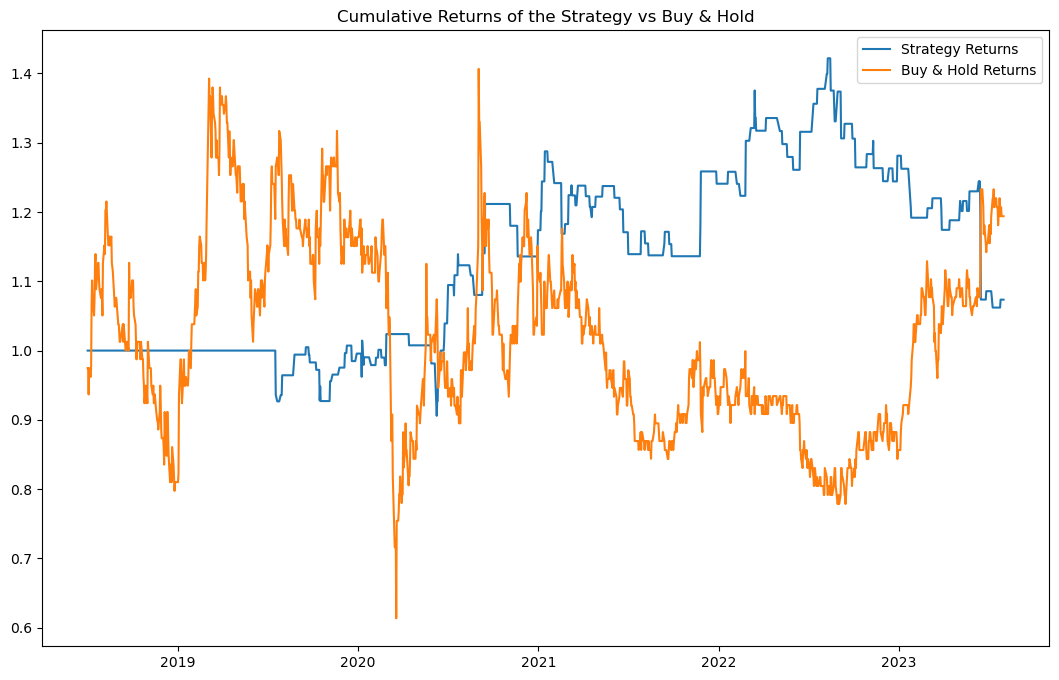

[*********************100%***********************]  1 of 1 completed
              Open    High     Low   Close  Adj Close     Volume
Date                                                            
2018-07-02  14.796  14.901  14.781  14.856     14.856  8.855e+05
2018-07-03  14.765  14.916  14.765  14.856     14.856  8.625e+05
2018-07-04  14.750  14.916  14.750  14.916     14.916  1.750e+05
2018-07-05  14.916  14.946  14.916  14.946     14.946  5.003e+05
2018-07-06  14.871  14.871  14.645  14.750     14.750  1.466e+06
...            ...     ...     ...     ...        ...        ...
2023-07-26  16.660  16.760  16.560  16.680     16.680  2.178e+05
2023-07-27  16.700  16.980  16.400  16.640     16.640  3.215e+05
2023-07-28  16.560  16.640  16.380  16.400     16.400  1.589e+05
2023-07-31  16.500  16.840  16.460  16.700     16.700  6.443e+05
2023-08-01  16.660  16.780  16.660  16.660     16.660  3.000e+02

[1239 rows x 6 columns]
              Open    High     Low   Close  Adj Close     Vol

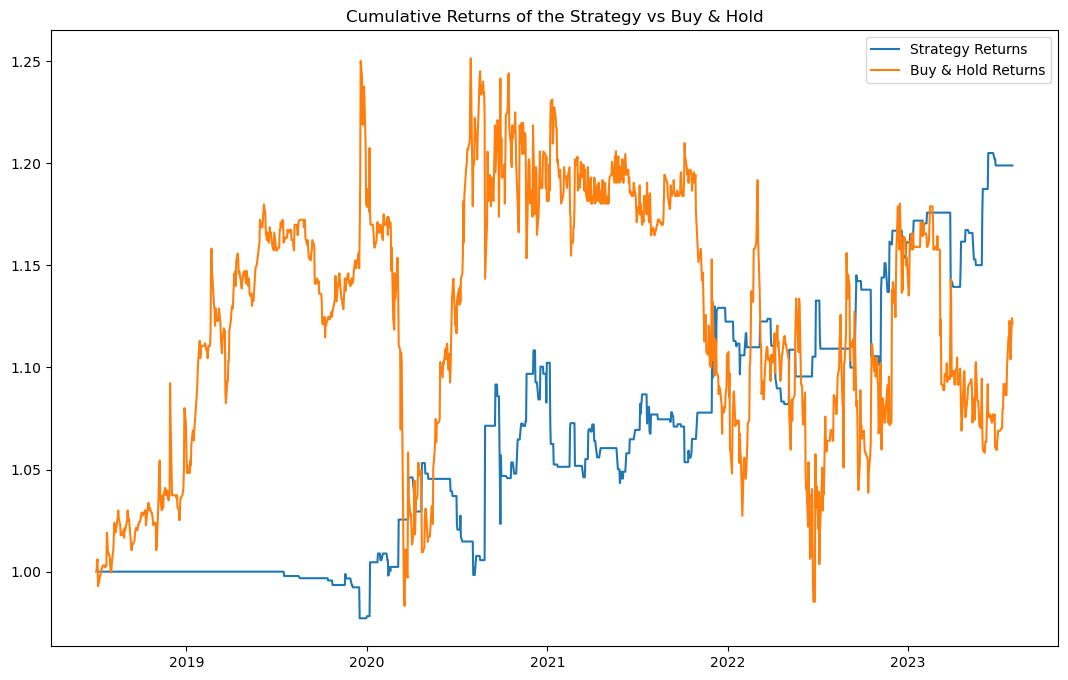

[*********************100%***********************]  1 of 1 completed
             Open   High    Low  Close  Adj Close      Volume
Date                                                         
2018-07-02  0.209  0.221  0.209  0.213      0.213  272954.057
2018-07-03  0.221  0.230  0.209  0.217      0.217  174786.378
2018-07-04  0.213  0.217  0.209  0.217      0.217   90984.690
2018-07-05  0.217  0.234  0.213  0.230      0.230   23344.756
2018-07-06  0.209  0.209  0.209  0.209      0.209  204954.980
...           ...    ...    ...    ...        ...         ...
2023-07-24  0.280  0.290  0.280  0.290      0.290   40000.000
2023-07-25  0.290  0.290  0.290  0.290      0.290   11400.000
2023-07-26  0.275  0.275  0.275  0.275      0.275   10000.000
2023-07-27  0.275  0.285  0.275  0.285      0.285   34200.000
2023-07-31  0.290  0.290  0.290  0.290      0.290     200.000

[938 rows x 6 columns]
             Open   High    Low  Close  Adj Close      Volume    SMA  \
Date                         

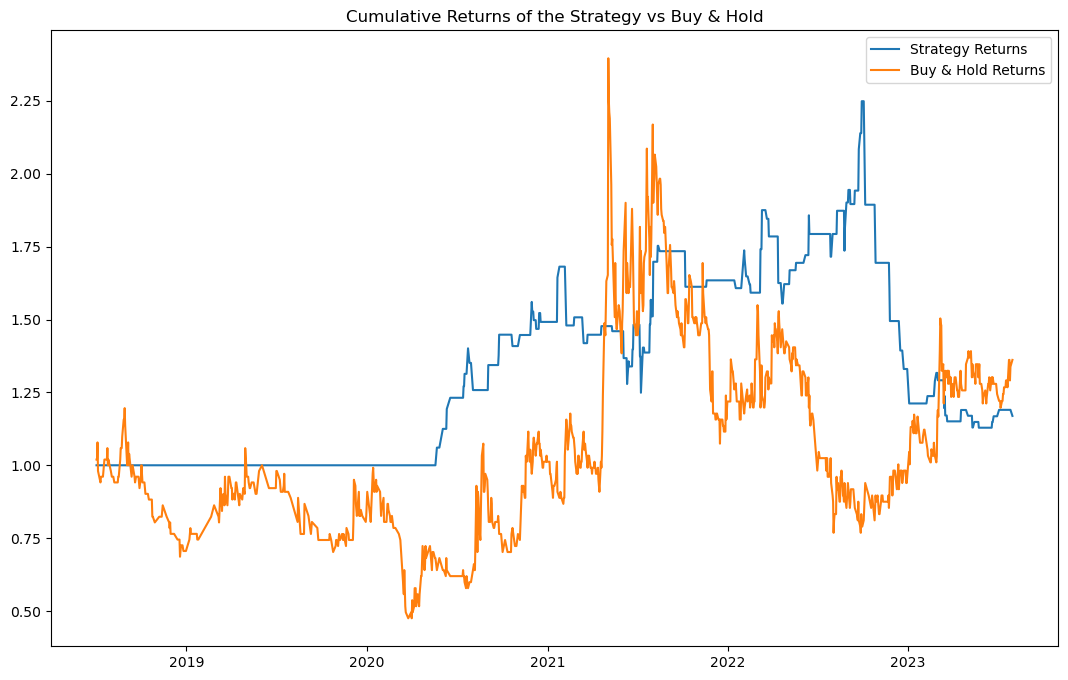

[*********************100%***********************]  1 of 1 completed
             Open   High    Low  Close  Adj Close     Volume
Date                                                        
2018-07-02  1.303  1.372  1.284  1.372      1.372  1.374e+06
2018-07-03  1.323  1.352  1.303  1.323      1.323  1.057e+06
2018-07-04  1.333  1.362  1.323  1.362      1.362  9.445e+05
2018-07-05  1.362  1.362  1.333  1.333      1.333  7.441e+05
2018-07-06  1.323  1.323  1.313  1.323      1.323  8.041e+05
...           ...    ...    ...    ...        ...        ...
2023-07-25  4.920  5.100  4.920  5.100      5.100  3.100e+04
2023-07-26  4.970  5.080  4.900  5.050      5.050  1.231e+05
2023-07-27  4.990  5.050  4.970  5.000      5.000  5.980e+04
2023-07-28  4.920  5.030  4.920  5.030      5.030  5.150e+04
2023-07-31  5.050  5.080  5.050  5.080      5.080  1.500e+03

[1217 rows x 6 columns]
             Open   High    Low  Close  Adj Close     Volume    SMA  \
Date                                      

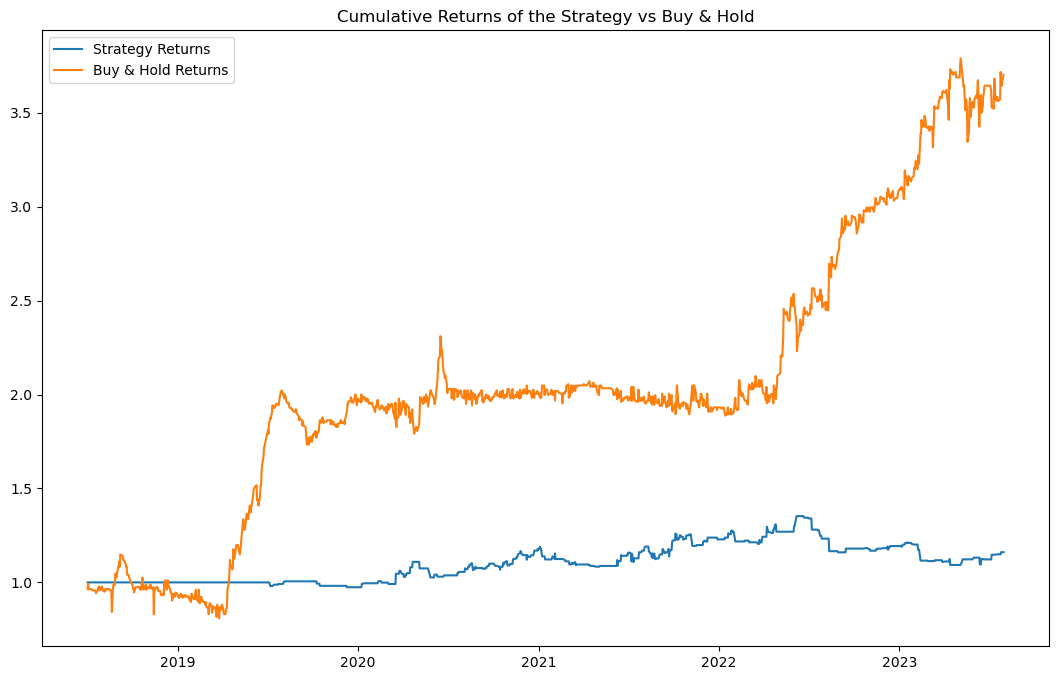

[*********************100%***********************]  1 of 1 completed
             Open   High    Low  Close  Adj Close    Volume
Date                                                       
2018-07-02  2.062  2.071  2.062  2.071      2.071  114827.0
2018-07-03  2.081  2.090  2.081  2.090      2.090   11105.0
2018-07-04  2.090  2.090  2.071  2.071      2.071   22630.0
2018-07-05  2.071  2.071  2.062  2.071      2.071  112312.0
2018-07-06  2.052  2.052  2.043  2.052      2.052   70195.0
...           ...    ...    ...    ...        ...       ...
2023-07-25  2.460  2.490  2.460  2.460      2.460    9900.0
2023-07-26  2.460  2.460  2.460  2.460      2.460   12500.0
2023-07-27  2.460  2.480  2.460  2.470      2.470   57900.0
2023-07-28  2.460  2.460  2.450  2.460      2.460   27000.0
2023-07-31  2.440  2.470  2.400  2.470      2.470   12300.0

[1218 rows x 6 columns]
             Open   High    Low  Close  Adj Close    Volume    SMA  PremDisc%  \
Date                                         

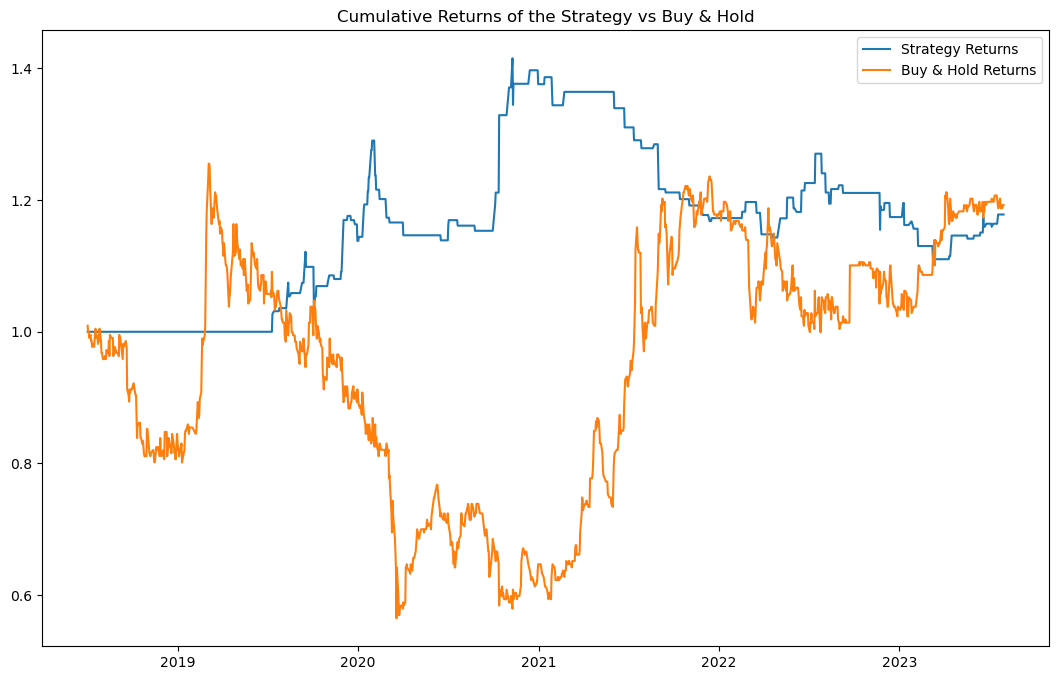

            7412.KL_Strategy  5015.KL_Strategy  0045.KL_Strategy  \
Date                                                               
2018-07-04               NaN             1.000             1.000   
2018-07-06             1.000             1.000               NaN   
2018-07-09             1.000               NaN             1.000   
2018-07-20             1.000             1.000             1.000   
2018-07-24             1.000             1.000             1.000   
...                      ...               ...               ...   
2023-07-26             2.032             1.716             2.854   
2023-07-27             2.032             1.716             2.854   
2023-07-28             2.032             1.716             2.854   
2023-07-31             2.139             1.716             2.854   
2023-08-01             2.139             1.716             2.854   

            5681.KL_Strategy  7498.KL_Strategy  5285.KL_Strategy  \
Date                                           

In [6]:
# Create an empty dataframe to store equity curves
equity_curve_df = pd.DataFrame()

# Create an empty dataframe to store buy and hold equity curves
bh_equity_curve_df = pd.DataFrame()

# Loop through the tickers
for ticker in tickers:
    try:
        
        # Define a function to calculate the Z-Score
        def Z_Score(df, window):
            df['mean'] = df['PremDisc%'].rolling(window=window).mean()
            df['std'] = df['PremDisc%'].rolling(window=window).std()
            df['Z_Score'] = (df['PremDisc%'] - df['mean']) / df['std']
            return df
        
        def ZScore(df, window):
            df['Mean'] = df['MisPricing%'].rolling(window=window).mean()
            df['Std'] = df['MisPricing%'].rolling(window=window).std()
            df['ZScore'] = (df['MisPricing%'] - df['Mean']) / df['Std']
            return df


        # Fetch the data
        df = yf.download(ticker, start=start1, end=end2)

        df["Volume"] = 1 / (df["Adj Close"] / df["Close"]) * df["Volume"] 
        df["Open"] = df["Adj Close"] / df["Close"] * df["Open"] 
        df["High"] = df["Adj Close"] / df["Close"] * df["High"] 
        df["Low"] = df["Adj Close"] / df["Close"] * df["Low"] 
        df["Close"] = df["Adj Close"]
        df = df[df['Volume'] != 0]
        df.fillna(method='ffill', inplace=True)
        print(df)

        # Get the best parameters for this ticker
        params = best_params.loc[ticker]

        # Calculate the SMA
        df["SMA"] = df["Close"].rolling(window=int(params['sma_window'])).mean()

        # Calculate the premium/discount
        df["PremDisc%"] = (df["Close"]/df["SMA"] - 1)*100

        # Calculate Z-Score
        df = Z_Score(df, window=int(params['zscore_window']))
        
        df["TSF"] = TSF(df["Close"].values, timeperiod=int(params['sma_window']))
        df["MisPricing%"] = (df["TSF"]/df["Close"] - 1)*100
        df = ZScore(df, window=int(params['zscore_window']))


        # Define buy and sell zones
        buyZScoreTH = params['buyZScoreTH']
        sellZScoreTH = params['sellZScoreTH']

        buyZone = (df["Z_Score"] > -1*buyZScoreTH) & (df["ZScore"] > -1*buyZScoreTH)
        prebuyZone = (df["Z_Score"].shift(1) <= -1*buyZScoreTH) & (df["ZScore"].shift(1) <= -1*buyZScoreTH)
        sellZone1 = (df["Z_Score"] < 1*sellZScoreTH) & (df["ZScore"] < 1*sellZScoreTH)
        presellZone1 = (df["Z_Score"].shift(1) >= 1*sellZScoreTH) & (df["ZScore"].shift(1) >= 1*sellZScoreTH)
        sellZone2 = ((df["Z_Score"] < 0) & (df["Z_Score"].shift(1) > 0)) | ((df["ZScore"] < 0) & (df["ZScore"].shift(1) > 0))

        # Generate trading signals
        df["BuySignal"] = np.where(buyZone & prebuyZone, 1, 0)
        df["SellSignal"] = np.where((sellZone1 & presellZone1) | sellZone2, -1, 0)
        df["Signal"] = df["BuySignal"] + df["SellSignal"]

        # Calculate the ATR
        df["ATR"] = ATR(df["High"].values, df["Low"].values, df["Close"].values, timeperiod=int(params['ATR_window']))

        # Define SL and TP multipliers
        SL_multiplier = params['SL_multiplier']
        TP_multiplier = params['TP_multiplier']

        # Initialize SL and TP levels to NaN
        df["SL"] = np.nan
        df["TP"] = np.nan

        # Define initial capital
        capital = 10000

        # Calculate the number of shares to buy
        df["Shares"] = capital // (df["ATR"] * 100)

        # Create a variable to hold the entry price
        entry_price = 0

        # Define SL and TP levels based on entry price
        for i in range(len(df)):
            if df["Signal"].iloc[i] == 1:
                entry_price = df["Close"].iloc[i]
                df["SL"].iloc[i] = entry_price - SL_multiplier * df["ATR"].iloc[i]
                df["TP"].iloc[i] = entry_price + TP_multiplier * df["ATR"].iloc[i]
            elif df["Signal"].iloc[i] == -1:
                entry_price = 0
                df["SL"].iloc[i] = np.nan
                df["TP"].iloc[i] = np.nan
            else:
                df["SL"].iloc[i] = df["SL"].iloc[i-1]
                df["TP"].iloc[i] = df["TP"].iloc[i-1]

        # Fill in the rest of SL and TP columns
        df["SL"].fillna(method='ffill', inplace=True)
        df["TP"].fillna(method='ffill', inplace=True)

        # Calculate daily returns based on trading signals
        df['returns'] = df['Close'].pct_change() * df['Signal'].shift()

        # Calculate Buy-and-Hold Returns
        df["B&H_Returns"] = df["Close"].pct_change()

        # Calculate cumulative returns
        df['cumulative_returns'] = (1 + df['returns']).cumprod()

        # Calculate buy-and-hold cumulative returns
        df["B&H_Cumulative_Returns"] = (1 + df["B&H_Returns"]).cumprod()

        # Print the DataFrame
        print(df)

        # Calculate cumulative returns
        df['cumulative_returns'] = (1 + df['returns']).cumprod()
        
        # Calculate buy-and-hold cumulative returns
        df["B&H_Cumulative_Returns"] = (1 + df["B&H_Returns"]).cumprod()

        # Add the cumulative returns to the equity curve dataframe
        equity_curve_df[ticker+'_Strategy'] = df['cumulative_returns']

        # Add the buy-and-hold cumulative returns to the buy and hold equity curve dataframe
        bh_equity_curve_df[ticker+'_B&H'] = df["B&H_Cumulative_Returns"]

        # Plot cumulative returns
        plt.figure(figsize=(13,8))

        # Plot the strategy's cumulative returns
        plt.plot(df['cumulative_returns'], label='Strategy Returns')

        # Plot the buy-and-hold cumulative returns
        plt.plot(df["B&H_Cumulative_Returns"], label='Buy & Hold Returns')

        plt.title('Cumulative Returns of the Strategy vs Buy & Hold')
        plt.legend(loc='best')
        plt.show()
     
    except Exception as e:
        print(f"Error processing {ticker}: {e}")

# Print the equity curve dataframe
print(equity_curve_df)

# Print the buy and hold equity curve dataframe
print(bh_equity_curve_df)

# Concat and Print Both the DataFrames
final_df = pd.concat([equity_curve_df, bh_equity_curve_df], axis=1)
print(final_df)

In [17]:
# MPT using  Monte Carlo simulation to generate a large number of random portfolios
# (5,000 in this case) and then selects the portfolio with the highest Sharpe Ratio. 
# This is a simpler and more brute-force approach, and it may not always find the global 
# optimum, especially if the number of portfolios simulated is not large enough.
# This method can be more intuitive and easier to understand, and it can sometimes find better 
# solutions, especially for complex or non-convex optimization problems. However, it can also 
# be slower and less accurate, especially for larger numbers of assets or smaller numbers of 
# simulations.

# Specify assets / stocks
assets = final_df.columns

# Number of assets
num_of_assets = len(assets)

# Number of portfolio for optimization
num_of_portfolios = 5000

# Source of Data or Equity Curve of ALL Tickers
df = final_df
df = df.fillna(method='ffill')
#df = df.fillna(method='bfill')
df.dropna(inplace=True)

# Define the rolling window size
rolling_window = int(252/4)  # You can adjust this based on your preference (e.g., 1 year)

# Initialize a DataFrame to store the rolling portfolio weights
rolling_weights_df = pd.DataFrame(index=final_df.index, columns=assets)

# Perform rolling optimization of the portfolio
for i in range(rolling_window, len(final_df)):
    window_returns = final_df.iloc[i - rolling_window:i]  # Get the returns for the rolling window

    # Define the function for portfolio simulation with random weights
    def portfolio_simulation(returns):
        weights = np.random.random(num_of_assets)
        weights /= np.sum(weights)
        port_returns = np.sum(weights * returns.mean() * 252)
        port_volatility = np.sqrt(np.dot(weights.T, np.dot(returns.cov() * 252, weights)))
        sharpe_ratio = port_returns / port_volatility
        return weights, sharpe_ratio

    # Perform Monte Carlo simulation to find the maximum Sharpe ratio portfolio for the rolling window
    max_sharpe_ratio = -np.inf
    best_weights = None
    for j in range(num_of_portfolios):
        weights, sharpe_ratio = portfolio_simulation(window_returns)
        if sharpe_ratio > max_sharpe_ratio:
            max_sharpe_ratio = sharpe_ratio
            best_weights = weights

    # Store the weights of the maximum Sharpe ratio portfolio for the rolling window
    rolling_weights_df.iloc[i] = best_weights

# Forward fill any NaN values in the rolling weights DataFrame
rolling_weights_df.fillna(method='ffill', inplace=True)

# Calculate the portfolio returns based on the rolling weights
rolling_portfolio_returns = (rolling_weights_df.shift() * final_df.pct_change()).sum(axis=1)

# Calculate the cumulative returns of the rolling portfolio
cumulative_returns = (1 + rolling_portfolio_returns).cumprod()

# Print the DataFrame with the rolling portfolio returns and cumulative returns
rolling_portfolio_df = pd.DataFrame({
    'Rolling_Portfolio_Returns': rolling_portfolio_returns,
    'Cumulative_Returns': cumulative_returns
})
print(rolling_portfolio_df)

            Rolling_Portfolio_Returns  Cumulative_Returns
Date                                                     
2018-07-04                   0.00e+00                1.00
2018-07-06                   0.00e+00                1.00
2018-07-09                   0.00e+00                1.00
2018-07-20                   0.00e+00                1.00
2018-07-24                   0.00e+00                1.00
...                               ...                 ...
2023-07-26                  -2.53e-03                1.54
2023-07-27                   2.00e-03                1.55
2023-07-28                  -5.97e-04                1.55
2023-07-31                   4.19e-03                1.55
2023-08-01                  -1.11e-03                1.55

[642 rows x 2 columns]


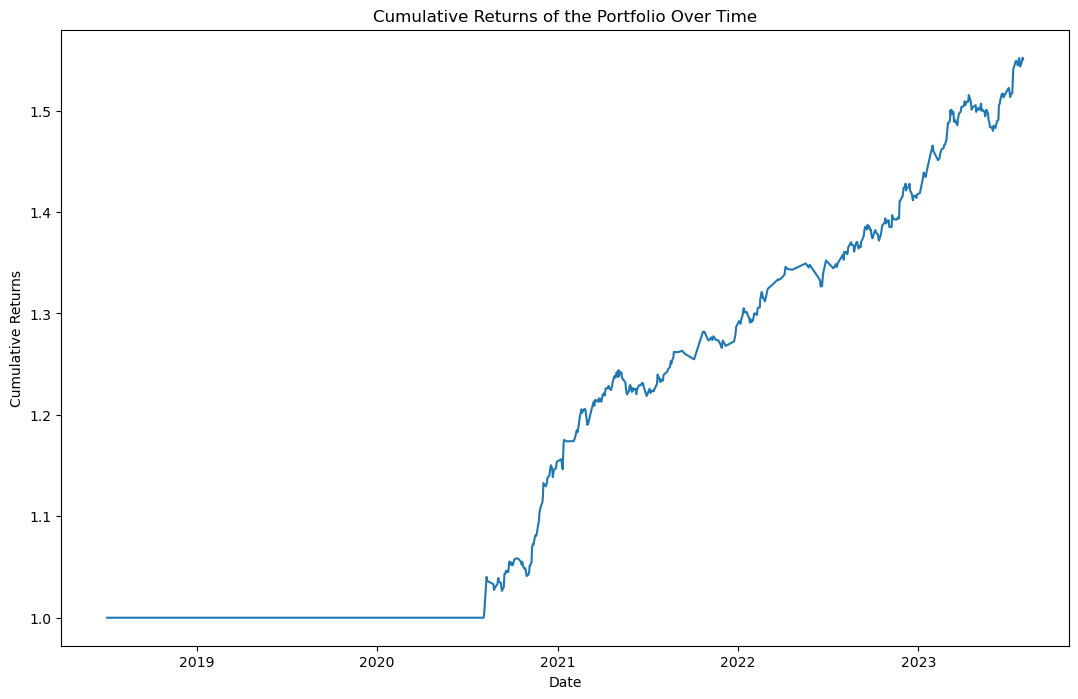

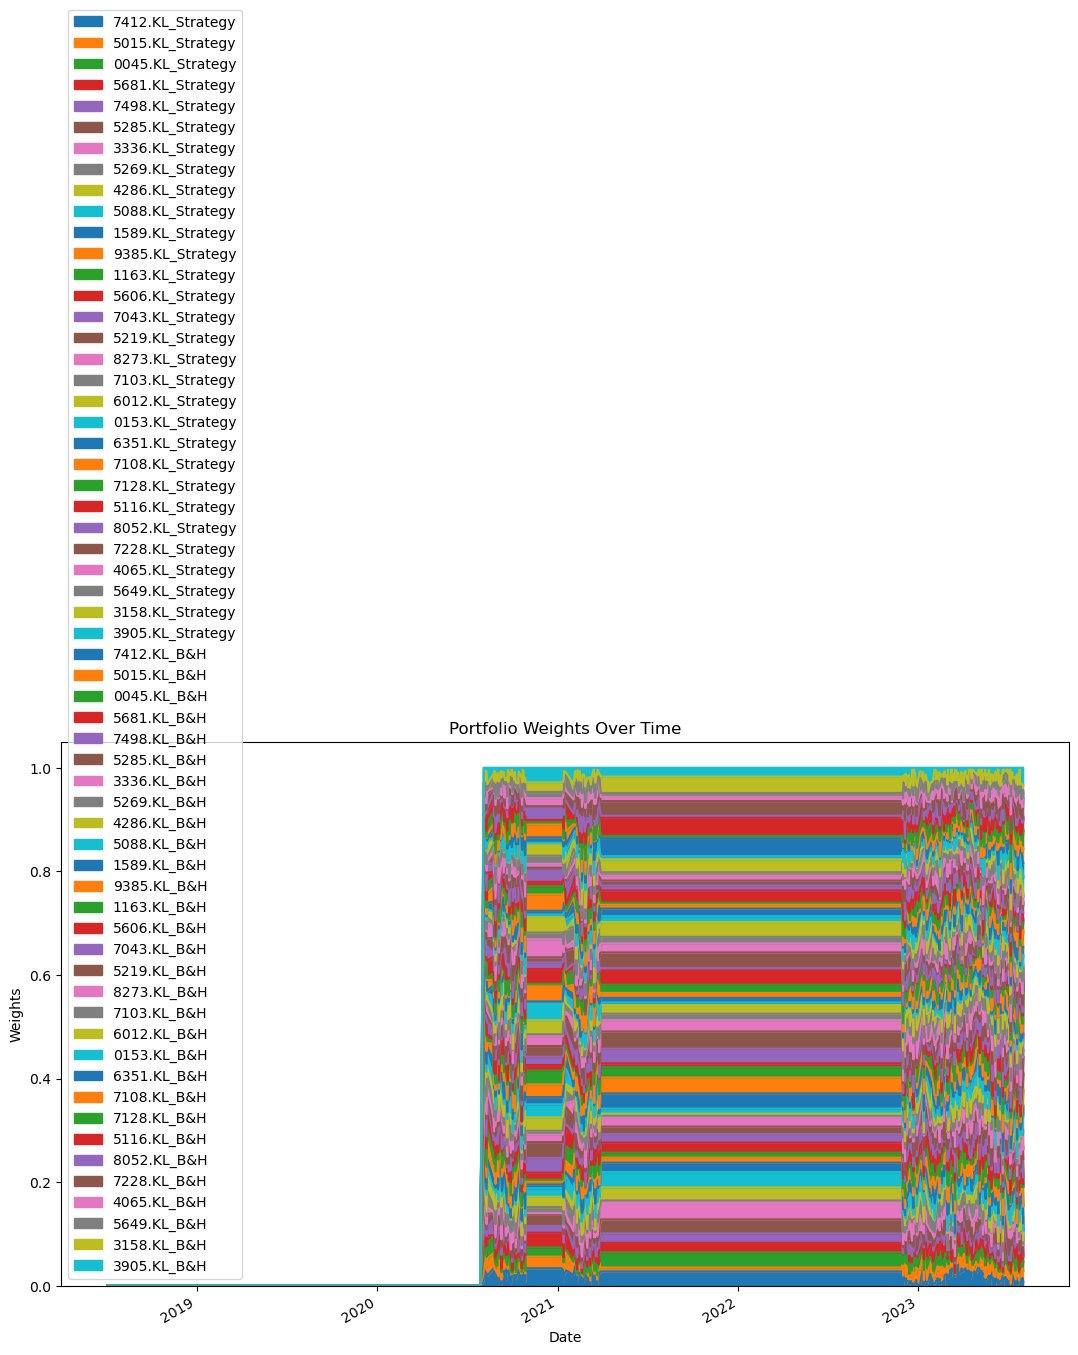

Final portfolio weights:
7412.KL_Strategy    7.38e-03
5015.KL_Strategy    2.16e-02
0045.KL_Strategy    1.97e-02
5681.KL_Strategy    6.74e-03
7498.KL_Strategy    3.02e-03
5285.KL_Strategy    9.48e-04
3336.KL_Strategy    1.92e-02
5269.KL_Strategy    3.02e-03
4286.KL_Strategy    6.38e-03
5088.KL_Strategy    1.88e-02
1589.KL_Strategy    1.40e-02
9385.KL_Strategy    3.22e-02
1163.KL_Strategy    3.76e-02
5606.KL_Strategy    6.14e-03
7043.KL_Strategy    1.29e-02
5219.KL_Strategy    3.59e-02
8273.KL_Strategy    1.79e-02
7103.KL_Strategy    3.47e-02
6012.KL_Strategy    3.76e-02
0153.KL_Strategy    6.59e-03
6351.KL_Strategy    6.62e-03
7108.KL_Strategy    3.06e-02
7128.KL_Strategy    3.25e-02
5116.KL_Strategy    3.20e-02
8052.KL_Strategy    1.38e-02
7228.KL_Strategy    3.13e-02
4065.KL_Strategy    2.88e-02
5649.KL_Strategy    2.44e-02
3158.KL_Strategy    2.24e-02
3905.KL_Strategy    1.31e-02
7412.KL_B&H         5.20e-03
5015.KL_B&H         9.97e-04
0045.KL_B&H         3.79e-03
5681.KL_B&H       

In [18]:
import matplotlib.pyplot as plt

# Plot the cumulative returns of the portfolio
plt.figure(figsize=(13, 8))
plt.plot(rolling_portfolio_df['Cumulative_Returns'])
plt.title('Cumulative Returns of the Portfolio Over Time')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.grid(False)
plt.show()

# Plot the portfolio weights over time
rolling_weights_df.plot(kind='area', stacked=True, figsize=(13, 8))
plt.title('Portfolio Weights Over Time')
plt.xlabel('Date')
plt.ylabel('Weights')
plt.grid(False)
plt.show()

# Print the final portfolio weights
print('Final portfolio weights:')
print(rolling_weights_df.iloc[-1])

In [19]:
df = final_df
print(df)

# Plot Strategy Return / Equity Curve History
df['2019':].iplot(kind='line', title='Equity Curve or Compounded Returns Plot')

            7412.KL_Strategy  5015.KL_Strategy  0045.KL_Strategy  \
Date                                                               
2018-07-04               NaN              1.00              1.00   
2018-07-06              1.00              1.00               NaN   
2018-07-09              1.00               NaN              1.00   
2018-07-20              1.00              1.00              1.00   
2018-07-24              1.00              1.00              1.00   
...                      ...               ...               ...   
2023-07-26              2.03              1.72              2.85   
2023-07-27              2.03              1.72              2.85   
2023-07-28              2.03              1.72              2.85   
2023-07-31              2.14              1.72              2.85   
2023-08-01              2.14              1.72              2.85   

            5681.KL_Strategy  7498.KL_Strategy  5285.KL_Strategy  \
Date                                           

In [20]:
# Dataframe of returns and volatility
returns = df.pct_change().dropna()
df1 = pd.DataFrame({
    'Ann Strategy Ret': round(returns.mean()*252*100,2),
    'Ann Strategy Vol': round(returns.std()*np.sqrt(252)*100,2)
})
df1

Ann Strategy Ret  Ann Strategy Vol
7412.KL_Strategy             33.49             25.53
5015.KL_Strategy             22.39             14.46
0045.KL_Strategy             48.77             39.87
5681.KL_Strategy             30.20             16.87
7498.KL_Strategy              2.29             16.70
5285.KL_Strategy             23.50             17.97
3336.KL_Strategy             17.57             17.41
5269.KL_Strategy             15.02             18.41
4286.KL_Strategy              0.91             32.13
5088.KL_Strategy             11.52             18.46
1589.KL_Strategy             11.40             18.07
9385.KL_Strategy             14.94             19.08
1163.KL_Strategy              4.05              5.37
5606.KL_Strategy              7.34             18.09
7043.KL_Strategy             14.66             18.16
5219.KL_Strategy             13.86             19.52
8273.KL_Strategy              8.06             17.17
7103.KL_Strategy              7.02             13.43
6012.KL_Strategy             13.36             14.34
0153.KL_Strategy             29.26             43.39
6351.KL_Strategy              3.78              7.27
7108.KL_Strategy             24.40             25.84
7128.KL_Strategy             10.83             19.39
5116.KL_Strategy              5.02             10.94
8052.KL_Strategy             -3.15             11.93
7228.KL_Strategy              4.92             20.61
4065.KL_Strategy              7.74             10.68
5649.KL_Strategy             12.43             35.41
3158.KL_Strategy              7.08             15.38
3905.KL_Strategy              7.48             14.20
7412.KL_B&H                  77.97             92.16
5015.KL_B&H                  -6.31             30.56
0045.KL_B&H                   5.89            105.29
5681.KL_B&H                   5.91             34.89
7498.KL_B&H                  71.81             95.49
5285.KL_B&H                   7.27             41.96
3336.KL_B&H                   7.86             45.21
5269.KL_B&H                  -4.57             41.65
4286.KL_B&H                  34.67             69.42
5088.KL_B&H                  28.14             56.75
1589.KL_B&H                   4.72             78.50
9385.KL_B&H                 -18.26             60.89
1163.KL_B&H                  16.63             22.48
5606.KL_B&H                  18.61             34.38
7043.KL_B&H                  -9.83             77.90
5219.KL_B&H                 -37.19             68.01
8273.KL_B&H                  44.06             72.20
7103.KL_B&H                  13.14             45.36
6012.KL_B&H                  -0.50             32.28
0153.KL_B&H                  84.21            135.12
6351.KL_B&H                  -2.67             20.87
7108.KL_B&H                  48.28            103.00
7128.KL_B&H                  45.93             70.85
5116.KL_B&H                  13.71             20.01
8052.KL_B&H                  78.34             95.53
7228.KL_B&H                  17.28             55.41
4065.KL_B&H                   6.66             23.90
5649.KL_B&H                  57.19             98.26
3158.KL_B&H                  61.87             42.91
3905.KL_B&H                  15.05             38.54

In [21]:
# Plot annualized return and volatility
df1.iplot(
    kind='bar', 
    title='Annualized Return & Volatility (%)', 
    shared_xaxes = True,  
    orientation="h") #subplots=True

In [22]:
df1.reset_index().iplot(
    kind="pie", 
    title='Annualized Strategy Return (%)', 
    labels='index', 
    values="Ann Strategy Ret",
    textinfo='percent+label', 
    hole=.4)